<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-27 19:35:02.408100: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 19:35:02.440096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-27 19:35:02.440122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-27 19:35:02.441149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-27 19:35:02.446483: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 19:35:02.447342: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-27 19:35:03.172317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-27 19:35:05.534266: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 92ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

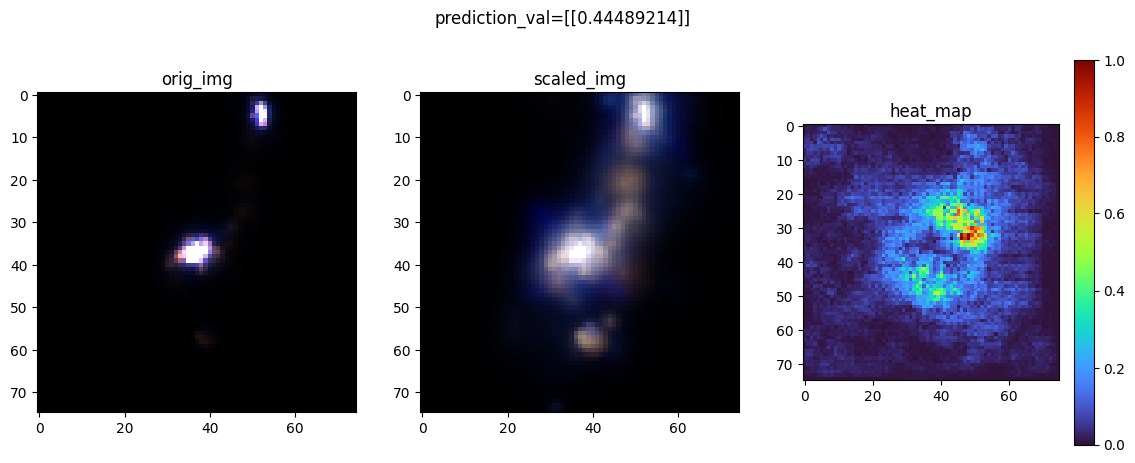

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

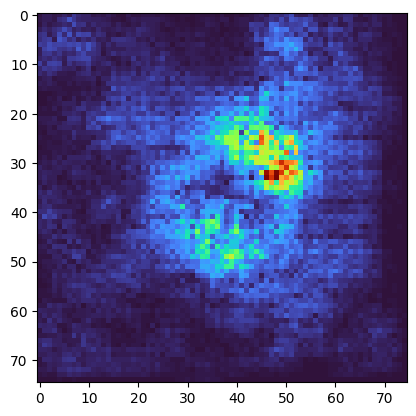

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-27 19:35:08.489666: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-27 19:35:09.327149: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-27 19:35:09.400632: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-27 19:35:09.440644: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-27 19:35:10.912677: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

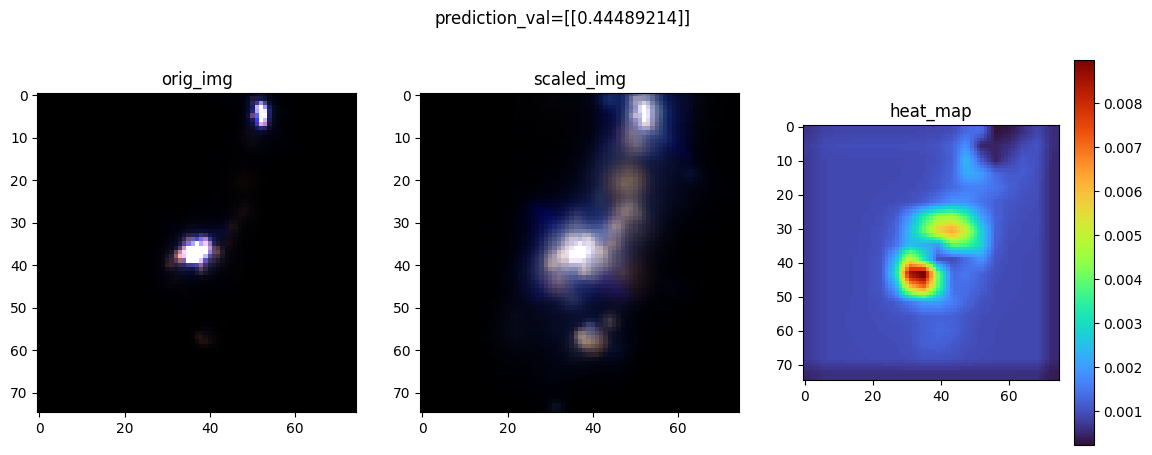

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

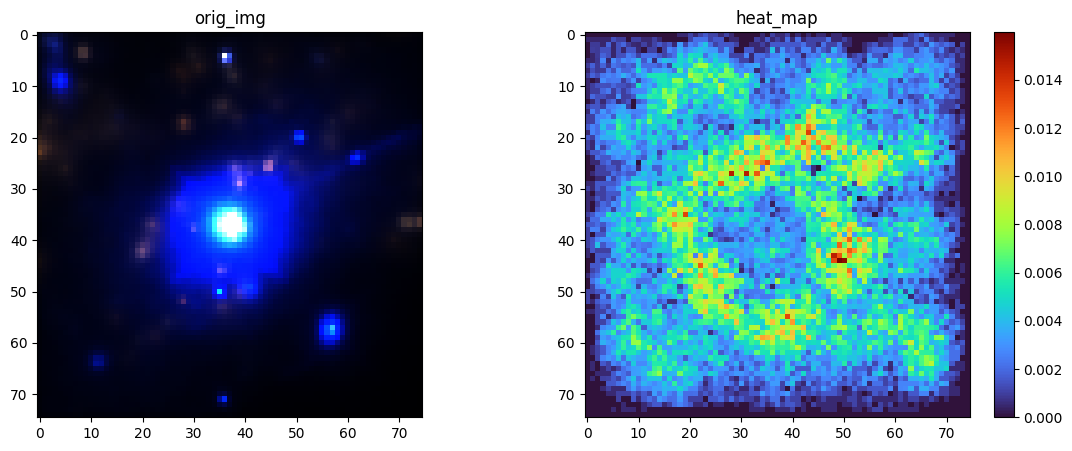

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:12 - loss: 0.7096 - accuracy: 0.5000

  2/338 [..............................] - ETA: 20s - loss: 0.7093 - accuracy: 0.5156 

  3/338 [..............................] - ETA: 19s - loss: 0.7087 - accuracy: 0.5312

  4/338 [..............................] - ETA: 19s - loss: 0.7085 - accuracy: 0.5312

  5/338 [..............................] - ETA: 19s - loss: 0.7087 - accuracy: 0.5063

  6/338 [..............................] - ETA: 19s - loss: 0.7089 - accuracy: 0.4844

  7/338 [..............................] - ETA: 19s - loss: 0.7084 - accuracy: 0.4955

  8/338 [..............................] - ETA: 18s - loss: 0.7082 - accuracy: 0.5000

  9/338 [..............................] - ETA: 18s - loss: 0.7079 - accuracy: 0.5035

 10/338 [..............................] - ETA: 18s - loss: 0.7078 - accuracy: 0.4875

 11/338 [..............................] - ETA: 18s - loss: 0.7076 - accuracy: 0.4858

 12/338 [>.............................] - ETA: 18s - loss: 0.7074 - accuracy: 0.4870

 13/338 [>.............................] - ETA: 18s - loss: 0.7071 - accuracy: 0.4808

 14/338 [>.............................] - ETA: 18s - loss: 0.7069 - accuracy: 0.4754

 15/338 [>.............................] - ETA: 18s - loss: 0.7067 - accuracy: 0.4688

 16/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.4688

 17/338 [>.............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.4688

 18/338 [>.............................] - ETA: 18s - loss: 0.7061 - accuracy: 0.4757

 19/338 [>.............................] - ETA: 18s - loss: 0.7058 - accuracy: 0.4753

 20/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.4859

 21/338 [>.............................] - ETA: 18s - loss: 0.7054 - accuracy: 0.4851

 22/338 [>.............................] - ETA: 18s - loss: 0.7052 - accuracy: 0.4901

 23/338 [=>............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.4932

 24/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.4961

 25/338 [=>............................] - ETA: 17s - loss: 0.7045 - accuracy: 0.4963

 26/338 [=>............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.4964

 27/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.4942

 28/338 [=>............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.4922

 29/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.4903

 30/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.4917

 31/338 [=>............................] - ETA: 17s - loss: 0.7034 - accuracy: 0.4980

 32/338 [=>............................] - ETA: 17s - loss: 0.7033 - accuracy: 0.4971

 33/338 [=>............................] - ETA: 17s - loss: 0.7031 - accuracy: 0.4991

 34/338 [==>...........................] - ETA: 17s - loss: 0.7029 - accuracy: 0.5009

 35/338 [==>...........................] - ETA: 17s - loss: 0.7028 - accuracy: 0.4991

 36/338 [==>...........................] - ETA: 17s - loss: 0.7026 - accuracy: 0.5026

 37/338 [==>...........................] - ETA: 17s - loss: 0.7024 - accuracy: 0.5051

 38/338 [==>...........................] - ETA: 17s - loss: 0.7023 - accuracy: 0.5066

 39/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5096

 40/338 [==>...........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.5141

 41/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.5145

 42/338 [==>...........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5141

 43/338 [==>...........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5138

 44/338 [==>...........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5163

 45/338 [==>...........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5181

 46/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5183

 47/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5186

 48/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5176

 49/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5147

 50/338 [===>..........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.5150

 51/338 [===>..........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5159

 52/338 [===>..........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5150

 53/338 [===>..........................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5165

 54/338 [===>..........................] - ETA: 16s - loss: 0.7004 - accuracy: 0.5150

 55/338 [===>..........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.5142

 56/338 [===>..........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.5151

 57/338 [====>.........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5148

 58/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5167

 59/338 [====>.........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.5169

 60/338 [====>.........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.5151

 61/338 [====>.........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5159

 62/338 [====>.........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5146

 63/338 [====>.........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.5139

 64/338 [====>.........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.5146

 65/338 [====>.........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5144

 66/338 [====>.........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.5137

 67/338 [====>.........................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5145

 68/338 [=====>........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5165

 69/338 [=====>........................] - ETA: 15s - loss: 0.6992 - accuracy: 0.5177

 70/338 [=====>........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5196

 71/338 [=====>........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5180

 72/338 [=====>........................] - ETA: 15s - loss: 0.6991 - accuracy: 0.5174

 73/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5167

 74/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5160

 75/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5167

 76/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5152

 77/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5142

 78/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5140

 79/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5158

 80/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5156

 81/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5150

 82/338 [======>.......................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5156

 83/338 [======>.......................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5154

 84/338 [======>.......................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5153

 85/338 [======>.......................] - ETA: 14s - loss: 0.6985 - accuracy: 0.5147

 86/338 [======>.......................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5145

 87/338 [======>.......................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5144

 88/338 [======>.......................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5146

 89/338 [======>.......................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5133

 90/338 [======>.......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5149

 91/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5155

 92/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5156

 93/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5141

 94/338 [=======>......................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5140

 95/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5145

 96/338 [=======>......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5146

 97/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5142

 98/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5134

 99/338 [=======>......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5142

100/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5147

101/338 [=======>......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5139

102/338 [========>.....................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5135

103/338 [========>.....................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5137

104/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5135

105/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5128

106/338 [========>.....................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5121

107/338 [========>.....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5123

108/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5127

109/338 [========>.....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5115

110/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5128

111/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5118

112/338 [========>.....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5117

113/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5108

114/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5115

115/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5109

116/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5094

117/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5101

118/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5101

119/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5108

120/338 [=========>....................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5115

121/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5124

122/338 [=========>....................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5123

123/338 [=========>....................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5135

124/338 [==========>...................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5141

125/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5148

126/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5151

127/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5150

128/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5144

129/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5150

130/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5139

131/338 [==========>...................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5143

132/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5147

133/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5139

134/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5135

135/338 [==========>...................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5137

136/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5140

137/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5144

138/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5143

139/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5137

140/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5134

141/338 [===========>..................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5146

142/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5152

143/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5160

144/338 [===========>..................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5174

145/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5183

146/338 [===========>..................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5186

147/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5181

148/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5175

149/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5178

150/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5167

151/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5159

152/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5171

153/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5172

154/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5168

155/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5169

156/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5160

157/338 [============>.................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5171

158/338 [=============>................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5176

159/338 [=============>................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5169

160/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5174 

161/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5171

162/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5164

163/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5161

164/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5171

165/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5167

166/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5162

167/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5167

168/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5164

169/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5166

170/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5165

171/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5166

172/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5169

173/338 [==============>...............] - ETA: 9s - loss: 0.6959 - accuracy: 0.5164

174/338 [==============>...............] - ETA: 9s - loss: 0.6958 - accuracy: 0.5172

175/338 [==============>...............] - ETA: 9s - loss: 0.6958 - accuracy: 0.5170

176/338 [==============>...............] - ETA: 9s - loss: 0.6958 - accuracy: 0.5172

177/338 [==============>...............] - ETA: 9s - loss: 0.6958 - accuracy: 0.5171

178/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5169

179/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5164

180/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5158

181/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5164

182/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5165

183/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5171

184/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5168

185/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5167

186/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5170

187/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5172

188/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5178

189/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5177

190/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5176

191/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5180

192/338 [================>.............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5184

193/338 [================>.............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5183

194/338 [================>.............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5182

195/338 [================>.............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5170

196/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5169

197/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5171

198/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5172

199/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5173

200/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5178

201/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5188

202/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5183

203/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5179

204/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5176

205/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5177

206/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5179

207/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5181

208/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5177

209/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5182

210/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5192

211/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5197

212/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5203

213/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5202

214/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5206

215/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5212

216/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5208

217/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5212

218/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5221

219/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5217

220/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5213

221/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5216

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5217

223/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5219

224/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5220

225/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5214

226/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5225

227/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5224

228/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5225

229/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5228

230/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5226

231/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5221

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5220

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5219

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5215

235/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5215

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5221

237/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5215

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5217

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5220

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5219

241/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5219

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5217

243/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5219

244/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5218

245/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5214

246/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5218

247/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5218

248/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5214

249/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5221

250/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5221

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5219

252/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5219

253/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5217

254/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5215

255/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5212

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5215

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5214

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5218

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5218

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5220

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5212

262/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5212

263/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5216

264/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5215

265/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5218

266/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5220

267/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5219

268/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5218

269/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5215

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5212

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5211

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5209

273/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5203

274/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5208

275/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5210

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5211

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5206

278/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5212

279/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5211

280/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5218

281/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5217

282/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5217

283/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5213

284/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5212

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5216

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5216

287/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5223

288/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5219

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5215

290/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5217

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5215

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5214

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5212

294/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5215

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5218

296/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5223

297/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5224

298/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5222

299/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5222

300/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5223

301/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5222

302/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5221

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5224

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5226

305/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5232

306/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5235

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5237

308/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5235

309/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5233

310/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5238

311/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5239

312/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5238

313/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5239

314/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5237

315/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5237

316/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5231

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5231

318/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5232

319/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5232

320/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5229

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5229

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5228

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5227

324/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5228

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5230

326/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5231

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5233

328/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5237

329/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5236

330/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5240

331/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5238

332/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5232

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5236

334/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5231

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5231

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5228

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5226

338/338 [==============================] - 22s 61ms/step - loss: 0.6933 - accuracy: 0.5228 - val_loss: 0.6908 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6982 - accuracy: 0.5000

  2/338 [..............................] - ETA: 18s - loss: 0.6895 - accuracy: 0.5312

  3/338 [..............................] - ETA: 19s - loss: 0.6933 - accuracy: 0.5104

  4/338 [..............................] - ETA: 19s - loss: 0.6901 - accuracy: 0.5391

  5/338 [..............................] - ETA: 19s - loss: 0.6897 - accuracy: 0.5375

  6/338 [..............................] - ETA: 18s - loss: 0.6881 - accuracy: 0.5521

  7/338 [..............................] - ETA: 18s - loss: 0.6883 - accuracy: 0.5491

  8/338 [..............................] - ETA: 18s - loss: 0.6867 - accuracy: 0.5625

  9/338 [..............................] - ETA: 18s - loss: 0.6874 - accuracy: 0.5521

 10/338 [..............................] - ETA: 18s - loss: 0.6858 - accuracy: 0.5688

 11/338 [..............................] - ETA: 18s - loss: 0.6853 - accuracy: 0.5739

 12/338 [>.............................] - ETA: 18s - loss: 0.6850 - accuracy: 0.5781

 13/338 [>.............................] - ETA: 18s - loss: 0.6848 - accuracy: 0.5769

 14/338 [>.............................] - ETA: 18s - loss: 0.6852 - accuracy: 0.5714

 15/338 [>.............................] - ETA: 18s - loss: 0.6860 - accuracy: 0.5667

 16/338 [>.............................] - ETA: 18s - loss: 0.6860 - accuracy: 0.5664

 17/338 [>.............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5790

 18/338 [>.............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5642

 19/338 [>.............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5691

 20/338 [>.............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5641

 21/338 [>.............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5625

 22/338 [>.............................] - ETA: 17s - loss: 0.6851 - accuracy: 0.5710

 23/338 [=>............................] - ETA: 17s - loss: 0.6852 - accuracy: 0.5693

 24/338 [=>............................] - ETA: 17s - loss: 0.6852 - accuracy: 0.5690

 25/338 [=>............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5650

 26/338 [=>............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5625

 27/338 [=>............................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5648

 28/338 [=>............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5592

 29/338 [=>............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5593

 30/338 [=>............................] - ETA: 17s - loss: 0.6862 - accuracy: 0.5604

 31/338 [=>............................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5575

 32/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5537

 33/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5521

 34/338 [==>...........................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5506

 35/338 [==>...........................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5536

 36/338 [==>...........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5547

 37/338 [==>...........................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5557

 38/338 [==>...........................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5551

 39/338 [==>...........................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5529

 40/338 [==>...........................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5445

 41/338 [==>...........................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5404

 42/338 [==>...........................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5379

 43/338 [==>...........................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5392

 44/338 [==>...........................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5376

 45/338 [==>...........................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5389

 46/338 [===>..........................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5380

 47/338 [===>..........................] - ETA: 16s - loss: 0.6894 - accuracy: 0.5359

 48/338 [===>..........................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5378

 49/338 [===>..........................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5389

 50/338 [===>..........................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5381

 51/338 [===>..........................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5411

 52/338 [===>..........................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5403

 53/338 [===>..........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5371

 54/338 [===>..........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5399

 55/338 [===>..........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5403

 56/338 [===>..........................] - ETA: 15s - loss: 0.6887 - accuracy: 0.5396

 57/338 [====>.........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5406

 58/338 [====>.........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5431

 59/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5413

 60/338 [====>.........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5437

 61/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5415

 62/338 [====>.........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5418

 63/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5417

 64/338 [====>.........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5415

 65/338 [====>.........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5394

 66/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5407

 67/338 [====>.........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5396

 68/338 [=====>........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5391

 69/338 [=====>........................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5380

 70/338 [=====>........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5375

 71/338 [=====>........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5361

 72/338 [=====>........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5369

 73/338 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5381

 74/338 [=====>........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5380

 75/338 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5383

 76/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5399

 77/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5398

 78/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5397

 79/338 [======>.......................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5407

 80/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5391

 81/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5390

 82/338 [======>.......................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5400

 83/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5392

 84/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5394

 85/338 [======>.......................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5401

 86/338 [======>.......................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5400

 87/338 [======>.......................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5402

 88/338 [======>.......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5401

 89/338 [======>.......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5397

 90/338 [======>.......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5424

 91/338 [=======>......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5422

 92/338 [=======>......................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5408

 93/338 [=======>......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5410

 94/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5392

 95/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5385

 96/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5374

 97/338 [=======>......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5377

 98/338 [=======>......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5399

 99/338 [=======>......................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5398

100/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5387

101/338 [=======>......................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5377

102/338 [========>.....................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5377

103/338 [========>.....................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5388

104/338 [========>.....................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5382

105/338 [========>.....................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5387

106/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5369

107/338 [========>.....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5359

108/338 [========>.....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5365

109/338 [========>.....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5350

110/338 [========>.....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5338

111/338 [========>.....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5329

112/338 [========>.....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5321

113/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5321

114/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5326

115/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5326

116/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5315

117/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5331

118/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5328

119/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5326

120/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5328

121/338 [=========>....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5312

122/338 [=========>....................] - ETA: 12s - loss: 0.6889 - accuracy: 0.5312

123/338 [=========>....................] - ETA: 12s - loss: 0.6890 - accuracy: 0.5305

124/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5297

125/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5303

126/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5285

127/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5285

128/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5291

129/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5293

130/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5298

131/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5289

132/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5284

133/338 [==========>...................] - ETA: 11s - loss: 0.6890 - accuracy: 0.5282

134/338 [==========>...................] - ETA: 11s - loss: 0.6889 - accuracy: 0.5280

135/338 [==========>...................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5285

136/338 [===========>..................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5292

137/338 [===========>..................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5297

138/338 [===========>..................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5303

139/338 [===========>..................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5306

140/338 [===========>..................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5310

141/338 [===========>..................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5299

142/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5304

143/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5306

144/338 [===========>..................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5312

145/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5312

146/338 [===========>..................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5317

147/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5310

148/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5310

149/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5306

150/338 [============>.................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5300

151/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5304

152/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5300

153/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5298

154/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5300

155/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5298

156/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5294

157/338 [============>.................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5299

158/338 [=============>................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5293

159/338 [=============>................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5289 

160/338 [=============>................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5291

161/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5291

162/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5291

163/338 [=============>................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5289

164/338 [=============>................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5297

165/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5305

166/338 [=============>................] - ETA: 9s - loss: 0.6883 - accuracy: 0.5309

167/338 [=============>................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5312

168/338 [=============>................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5316

169/338 [==============>...............] - ETA: 9s - loss: 0.6882 - accuracy: 0.5312

170/338 [==============>...............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5318

171/338 [==============>...............] - ETA: 9s - loss: 0.6880 - accuracy: 0.5320

172/338 [==============>...............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5312

173/338 [==============>...............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5311

174/338 [==============>...............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5316

175/338 [==============>...............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5311

176/338 [==============>...............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5309

177/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5312

178/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5312

179/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5319

180/338 [==============>...............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5323

181/338 [===============>..............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5325

182/338 [===============>..............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5331

183/338 [===============>..............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5326

184/338 [===============>..............] - ETA: 8s - loss: 0.6878 - accuracy: 0.5326

185/338 [===============>..............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5323

186/338 [===============>..............] - ETA: 8s - loss: 0.6878 - accuracy: 0.5321

187/338 [===============>..............] - ETA: 8s - loss: 0.6878 - accuracy: 0.5321

188/338 [===============>..............] - ETA: 8s - loss: 0.6878 - accuracy: 0.5319

189/338 [===============>..............] - ETA: 8s - loss: 0.6877 - accuracy: 0.5321

190/338 [===============>..............] - ETA: 8s - loss: 0.6877 - accuracy: 0.5321

191/338 [===============>..............] - ETA: 8s - loss: 0.6878 - accuracy: 0.5312

192/338 [================>.............] - ETA: 8s - loss: 0.6878 - accuracy: 0.5312

193/338 [================>.............] - ETA: 8s - loss: 0.6877 - accuracy: 0.5317

194/338 [================>.............] - ETA: 8s - loss: 0.6877 - accuracy: 0.5312

195/338 [================>.............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5306

196/338 [================>.............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5316

197/338 [================>.............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5306

198/338 [================>.............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5301

199/338 [================>.............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5302

200/338 [================>.............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5302

201/338 [================>.............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5309

202/338 [================>.............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5311

203/338 [=================>............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5317

204/338 [=================>............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5311

205/338 [=================>............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5305

206/338 [=================>............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5303

207/338 [=================>............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5303

208/338 [=================>............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5303

209/338 [=================>............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5302

210/338 [=================>............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5301

211/338 [=================>............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5302

212/338 [=================>............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5298

213/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5299

214/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5304

215/338 [==================>...........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5302

216/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5311

217/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5312

218/338 [==================>...........] - ETA: 6s - loss: 0.6872 - accuracy: 0.5311

219/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5312

220/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5307

221/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5307

222/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5305

223/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5301

224/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5304

225/338 [==================>...........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5301

226/338 [===================>..........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5301

227/338 [===================>..........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5297

228/338 [===================>..........] - ETA: 6s - loss: 0.6873 - accuracy: 0.5293

229/338 [===================>..........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5293

230/338 [===================>..........] - ETA: 6s - loss: 0.6874 - accuracy: 0.5296

231/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5294

232/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5287

233/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5286

234/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5283

235/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5279

236/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5283

237/338 [====================>.........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5282

238/338 [====================>.........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5281

239/338 [====================>.........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5284

240/338 [====================>.........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5290

241/338 [====================>.........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5293

242/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5300

243/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5301

244/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5307

245/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5311

246/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5311

247/338 [====================>.........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5318

248/338 [=====================>........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5321

249/338 [=====================>........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5329

250/338 [=====================>........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5334

251/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5339

252/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5341

253/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5338

254/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5335

255/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5332

256/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5338

257/338 [=====================>........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5343

258/338 [=====================>........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5344

259/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5340

260/338 [======================>.......] - ETA: 4s - loss: 0.6872 - accuracy: 0.5347

261/338 [======================>.......] - ETA: 4s - loss: 0.6872 - accuracy: 0.5350

262/338 [======================>.......] - ETA: 4s - loss: 0.6872 - accuracy: 0.5351

263/338 [======================>.......] - ETA: 4s - loss: 0.6872 - accuracy: 0.5354

264/338 [======================>.......] - ETA: 4s - loss: 0.6872 - accuracy: 0.5357

265/338 [======================>.......] - ETA: 4s - loss: 0.6871 - accuracy: 0.5367

266/338 [======================>.......] - ETA: 4s - loss: 0.6870 - accuracy: 0.5370

267/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5376

268/338 [======================>.......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5378

269/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5381

270/338 [======================>.......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5387

271/338 [=======================>......] - ETA: 3s - loss: 0.6869 - accuracy: 0.5393

272/338 [=======================>......] - ETA: 3s - loss: 0.6868 - accuracy: 0.5399

273/338 [=======================>......] - ETA: 3s - loss: 0.6867 - accuracy: 0.5404

274/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5412

275/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5420

276/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5418

277/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5421

278/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5422

279/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5425

280/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5429

281/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5431

282/338 [========================>.....] - ETA: 3s - loss: 0.6866 - accuracy: 0.5432

283/338 [========================>.....] - ETA: 3s - loss: 0.6866 - accuracy: 0.5432

284/338 [========================>.....] - ETA: 3s - loss: 0.6865 - accuracy: 0.5439

285/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5445

286/338 [========================>.....] - ETA: 2s - loss: 0.6865 - accuracy: 0.5450

287/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5457

288/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5459

289/338 [========================>.....] - ETA: 2s - loss: 0.6864 - accuracy: 0.5468

290/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5473

291/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5476

292/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5481

293/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5486

294/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5489

295/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5496

296/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5500

297/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5506

298/338 [=========================>....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5507

299/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5512

300/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5518

301/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5514

302/338 [=========================>....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5518

303/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5523

304/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5528

305/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5532

306/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5537

307/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5546

308/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5550

309/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5555

310/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5554

311/338 [==========================>...] - ETA: 1s - loss: 0.6856 - accuracy: 0.5562

312/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5565

313/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5568

314/338 [==========================>...] - ETA: 1s - loss: 0.6855 - accuracy: 0.5571

315/338 [==========================>...] - ETA: 1s - loss: 0.6854 - accuracy: 0.5579

316/338 [===========================>..] - ETA: 1s - loss: 0.6853 - accuracy: 0.5585

317/338 [===========================>..] - ETA: 1s - loss: 0.6853 - accuracy: 0.5589

318/338 [===========================>..] - ETA: 1s - loss: 0.6853 - accuracy: 0.5590

319/338 [===========================>..] - ETA: 1s - loss: 0.6853 - accuracy: 0.5593

320/338 [===========================>..] - ETA: 1s - loss: 0.6852 - accuracy: 0.5595

321/338 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5601

322/338 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5603

323/338 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5602

324/338 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5603

325/338 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.5606

326/338 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5609

327/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5607

328/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5608

329/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5606

330/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5608

331/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5609

332/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5613

333/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5614

334/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5616

335/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5618

336/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5622

337/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5620

338/338 [==============================] - 20s 60ms/step - loss: 0.6850 - accuracy: 0.5619 - val_loss: 0.6894 - val_accuracy: 0.5401


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6715 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6818 - accuracy: 0.6719

  3/338 [..............................] - ETA: 18s - loss: 0.6888 - accuracy: 0.6250

  4/338 [..............................] - ETA: 18s - loss: 0.6832 - accuracy: 0.6484

  5/338 [..............................] - ETA: 18s - loss: 0.6791 - accuracy: 0.6687

  6/338 [..............................] - ETA: 18s - loss: 0.6758 - accuracy: 0.6719

  7/338 [..............................] - ETA: 18s - loss: 0.6803 - accuracy: 0.6473

  8/338 [..............................] - ETA: 18s - loss: 0.6826 - accuracy: 0.6328

  9/338 [..............................] - ETA: 18s - loss: 0.6814 - accuracy: 0.6389

 10/338 [..............................] - ETA: 18s - loss: 0.6812 - accuracy: 0.6344

 11/338 [..............................] - ETA: 18s - loss: 0.6831 - accuracy: 0.6278

 12/338 [>.............................] - ETA: 18s - loss: 0.6853 - accuracy: 0.6120

 13/338 [>.............................] - ETA: 18s - loss: 0.6841 - accuracy: 0.6154

 14/338 [>.............................] - ETA: 17s - loss: 0.6833 - accuracy: 0.6161

 15/338 [>.............................] - ETA: 17s - loss: 0.6821 - accuracy: 0.6187

 16/338 [>.............................] - ETA: 17s - loss: 0.6828 - accuracy: 0.6152

 17/338 [>.............................] - ETA: 17s - loss: 0.6820 - accuracy: 0.6176

 18/338 [>.............................] - ETA: 17s - loss: 0.6816 - accuracy: 0.6198

 19/338 [>.............................] - ETA: 17s - loss: 0.6814 - accuracy: 0.6234

 20/338 [>.............................] - ETA: 17s - loss: 0.6812 - accuracy: 0.6203

 21/338 [>.............................] - ETA: 17s - loss: 0.6825 - accuracy: 0.6131

 22/338 [>.............................] - ETA: 17s - loss: 0.6826 - accuracy: 0.6122

 23/338 [=>............................] - ETA: 17s - loss: 0.6821 - accuracy: 0.6168

 24/338 [=>............................] - ETA: 17s - loss: 0.6825 - accuracy: 0.6133

 25/338 [=>............................] - ETA: 17s - loss: 0.6833 - accuracy: 0.6075

 26/338 [=>............................] - ETA: 17s - loss: 0.6840 - accuracy: 0.6022

 27/338 [=>............................] - ETA: 17s - loss: 0.6833 - accuracy: 0.6042

 28/338 [=>............................] - ETA: 17s - loss: 0.6839 - accuracy: 0.6004

 29/338 [=>............................] - ETA: 17s - loss: 0.6839 - accuracy: 0.6013

 30/338 [=>............................] - ETA: 17s - loss: 0.6847 - accuracy: 0.5958

 31/338 [=>............................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5938

 32/338 [=>............................] - ETA: 16s - loss: 0.6839 - accuracy: 0.6006

 33/338 [=>............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.6004

 34/338 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5993

 35/338 [==>...........................] - ETA: 16s - loss: 0.6834 - accuracy: 0.6018

 36/338 [==>...........................] - ETA: 16s - loss: 0.6833 - accuracy: 0.6033

 37/338 [==>...........................] - ETA: 16s - loss: 0.6834 - accuracy: 0.6022

 38/338 [==>...........................] - ETA: 16s - loss: 0.6833 - accuracy: 0.6036

 39/338 [==>...........................] - ETA: 16s - loss: 0.6832 - accuracy: 0.6050

 40/338 [==>...........................] - ETA: 16s - loss: 0.6828 - accuracy: 0.6062

 41/338 [==>...........................] - ETA: 16s - loss: 0.6827 - accuracy: 0.6067

 42/338 [==>...........................] - ETA: 16s - loss: 0.6822 - accuracy: 0.6101

 43/338 [==>...........................] - ETA: 16s - loss: 0.6822 - accuracy: 0.6112

 44/338 [==>...........................] - ETA: 16s - loss: 0.6823 - accuracy: 0.6115

 45/338 [==>...........................] - ETA: 16s - loss: 0.6829 - accuracy: 0.6090

 46/338 [===>..........................] - ETA: 16s - loss: 0.6836 - accuracy: 0.6060

 47/338 [===>..........................] - ETA: 16s - loss: 0.6834 - accuracy: 0.6077

 48/338 [===>..........................] - ETA: 16s - loss: 0.6832 - accuracy: 0.6087

 49/338 [===>..........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.6091

 50/338 [===>..........................] - ETA: 15s - loss: 0.6828 - accuracy: 0.6106

 51/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6127

 52/338 [===>..........................] - ETA: 15s - loss: 0.6824 - accuracy: 0.6130

 53/338 [===>..........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6150

 54/338 [===>..........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6146

 55/338 [===>..........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6153

 56/338 [===>..........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6138

 57/338 [====>.........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6135

 58/338 [====>.........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6126

 59/338 [====>.........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6133

 60/338 [====>.........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6146

 61/338 [====>.........................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6148

 62/338 [====>.........................] - ETA: 15s - loss: 0.6814 - accuracy: 0.6159

 63/338 [====>.........................] - ETA: 15s - loss: 0.6812 - accuracy: 0.6171

 64/338 [====>.........................] - ETA: 15s - loss: 0.6813 - accuracy: 0.6167

 65/338 [====>.........................] - ETA: 15s - loss: 0.6810 - accuracy: 0.6183

 66/338 [====>.........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.6174

 67/338 [====>.........................] - ETA: 15s - loss: 0.6810 - accuracy: 0.6175

 68/338 [=====>........................] - ETA: 14s - loss: 0.6814 - accuracy: 0.6153

 69/338 [=====>........................] - ETA: 14s - loss: 0.6813 - accuracy: 0.6155

 70/338 [=====>........................] - ETA: 14s - loss: 0.6812 - accuracy: 0.6156

 71/338 [=====>........................] - ETA: 14s - loss: 0.6812 - accuracy: 0.6153

 72/338 [=====>........................] - ETA: 14s - loss: 0.6808 - accuracy: 0.6181

 73/338 [=====>........................] - ETA: 14s - loss: 0.6808 - accuracy: 0.6169

 74/338 [=====>........................] - ETA: 14s - loss: 0.6809 - accuracy: 0.6161

 75/338 [=====>........................] - ETA: 14s - loss: 0.6811 - accuracy: 0.6150

 76/338 [=====>........................] - ETA: 14s - loss: 0.6813 - accuracy: 0.6147

 77/338 [=====>........................] - ETA: 14s - loss: 0.6811 - accuracy: 0.6153

 78/338 [=====>........................] - ETA: 14s - loss: 0.6808 - accuracy: 0.6166

 79/338 [======>.......................] - ETA: 14s - loss: 0.6808 - accuracy: 0.6167

 80/338 [======>.......................] - ETA: 14s - loss: 0.6804 - accuracy: 0.6187

 81/338 [======>.......................] - ETA: 14s - loss: 0.6803 - accuracy: 0.6192

 82/338 [======>.......................] - ETA: 14s - loss: 0.6806 - accuracy: 0.6178

 83/338 [======>.......................] - ETA: 14s - loss: 0.6805 - accuracy: 0.6175

 84/338 [======>.......................] - ETA: 14s - loss: 0.6804 - accuracy: 0.6179

 85/338 [======>.......................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6195

 86/338 [======>.......................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6199

 87/338 [======>.......................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6200

 88/338 [======>.......................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6197

 89/338 [======>.......................] - ETA: 13s - loss: 0.6802 - accuracy: 0.6183

 90/338 [======>.......................] - ETA: 13s - loss: 0.6802 - accuracy: 0.6181

 91/338 [=======>......................] - ETA: 13s - loss: 0.6803 - accuracy: 0.6174

 92/338 [=======>......................] - ETA: 13s - loss: 0.6802 - accuracy: 0.6175

 93/338 [=======>......................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6190

 94/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6197

 95/338 [=======>......................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6191

 96/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6198

 97/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6202

 98/338 [=======>......................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6199

 99/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6203

100/338 [=======>......................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6194

101/338 [=======>......................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6197

102/338 [========>.....................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6198

103/338 [========>.....................] - ETA: 12s - loss: 0.6799 - accuracy: 0.6208

104/338 [========>.....................] - ETA: 12s - loss: 0.6798 - accuracy: 0.6214

105/338 [========>.....................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6214

106/338 [========>.....................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6218

107/338 [========>.....................] - ETA: 12s - loss: 0.6793 - accuracy: 0.6232

108/338 [========>.....................] - ETA: 12s - loss: 0.6793 - accuracy: 0.6233

109/338 [========>.....................] - ETA: 12s - loss: 0.6792 - accuracy: 0.6236

110/338 [========>.....................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6250

111/338 [========>.....................] - ETA: 12s - loss: 0.6787 - accuracy: 0.6258

112/338 [========>.....................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6272

113/338 [=========>....................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6269

114/338 [=========>....................] - ETA: 12s - loss: 0.6784 - accuracy: 0.6272

115/338 [=========>....................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6272

116/338 [=========>....................] - ETA: 12s - loss: 0.6784 - accuracy: 0.6269

117/338 [=========>....................] - ETA: 12s - loss: 0.6784 - accuracy: 0.6269

118/338 [=========>....................] - ETA: 12s - loss: 0.6780 - accuracy: 0.6282

119/338 [=========>....................] - ETA: 12s - loss: 0.6780 - accuracy: 0.6284

120/338 [=========>....................] - ETA: 12s - loss: 0.6779 - accuracy: 0.6281

121/338 [=========>....................] - ETA: 12s - loss: 0.6781 - accuracy: 0.6271

122/338 [=========>....................] - ETA: 11s - loss: 0.6781 - accuracy: 0.6270

123/338 [=========>....................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6283

124/338 [==========>...................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6283

125/338 [==========>...................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6285

126/338 [==========>...................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6290

127/338 [==========>...................] - ETA: 11s - loss: 0.6775 - accuracy: 0.6292

128/338 [==========>...................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6282

129/338 [==========>...................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6284

130/338 [==========>...................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6288

131/338 [==========>...................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6288

132/338 [==========>...................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6286

133/338 [==========>...................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6283

134/338 [==========>...................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6273

135/338 [==========>...................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6271

136/338 [===========>..................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6273

137/338 [===========>..................] - ETA: 11s - loss: 0.6779 - accuracy: 0.6261

138/338 [===========>..................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6266

139/338 [===========>..................] - ETA: 11s - loss: 0.6777 - accuracy: 0.6270

140/338 [===========>..................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6272

141/338 [===========>..................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6274

142/338 [===========>..................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6263

143/338 [===========>..................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6254

144/338 [===========>..................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6248

145/338 [===========>..................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6254

146/338 [===========>..................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6250

147/338 [============>.................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6256

148/338 [============>.................] - ETA: 10s - loss: 0.6777 - accuracy: 0.6261

149/338 [============>.................] - ETA: 10s - loss: 0.6777 - accuracy: 0.6263

150/338 [============>.................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6258

151/338 [============>.................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6254

152/338 [============>.................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6256

153/338 [============>.................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6252

154/338 [============>.................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6260

155/338 [============>.................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6262

156/338 [============>.................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6264

157/338 [============>.................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6246

158/338 [=============>................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6250 

159/338 [=============>................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6260

160/338 [=============>................] - ETA: 9s - loss: 0.6776 - accuracy: 0.6262

161/338 [=============>................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6269

162/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6279

163/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6281

164/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6280

165/338 [=============>................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6292

166/338 [=============>................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6301

167/338 [=============>................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6301

168/338 [=============>................] - ETA: 9s - loss: 0.6767 - accuracy: 0.6304

169/338 [==============>...............] - ETA: 9s - loss: 0.6768 - accuracy: 0.6302

170/338 [==============>...............] - ETA: 9s - loss: 0.6769 - accuracy: 0.6298

171/338 [==============>...............] - ETA: 9s - loss: 0.6768 - accuracy: 0.6303

172/338 [==============>...............] - ETA: 9s - loss: 0.6767 - accuracy: 0.6306

173/338 [==============>...............] - ETA: 9s - loss: 0.6769 - accuracy: 0.6295

174/338 [==============>...............] - ETA: 9s - loss: 0.6768 - accuracy: 0.6298

175/338 [==============>...............] - ETA: 9s - loss: 0.6768 - accuracy: 0.6298

176/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6294

177/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6292

178/338 [==============>...............] - ETA: 8s - loss: 0.6770 - accuracy: 0.6287

179/338 [==============>...............] - ETA: 8s - loss: 0.6768 - accuracy: 0.6294

180/338 [==============>...............] - ETA: 8s - loss: 0.6766 - accuracy: 0.6300

181/338 [===============>..............] - ETA: 8s - loss: 0.6766 - accuracy: 0.6304

182/338 [===============>..............] - ETA: 8s - loss: 0.6763 - accuracy: 0.6314

183/338 [===============>..............] - ETA: 8s - loss: 0.6761 - accuracy: 0.6323

184/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6335

185/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6340

186/338 [===============>..............] - ETA: 8s - loss: 0.6759 - accuracy: 0.6331

187/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6332

188/338 [===============>..............] - ETA: 8s - loss: 0.6759 - accuracy: 0.6330

189/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6334

190/338 [===============>..............] - ETA: 8s - loss: 0.6758 - accuracy: 0.6331

191/338 [===============>..............] - ETA: 8s - loss: 0.6757 - accuracy: 0.6335

192/338 [================>.............] - ETA: 8s - loss: 0.6756 - accuracy: 0.6338

193/338 [================>.............] - ETA: 8s - loss: 0.6755 - accuracy: 0.6339

194/338 [================>.............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6342

195/338 [================>.............] - ETA: 7s - loss: 0.6755 - accuracy: 0.6338

196/338 [================>.............] - ETA: 7s - loss: 0.6757 - accuracy: 0.6333

197/338 [================>.............] - ETA: 7s - loss: 0.6755 - accuracy: 0.6339

198/338 [================>.............] - ETA: 7s - loss: 0.6755 - accuracy: 0.6338

199/338 [================>.............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6341

200/338 [================>.............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6350

201/338 [================>.............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6343

202/338 [================>.............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6341

203/338 [=================>............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6338

204/338 [=================>............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6342

205/338 [=================>............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6340

206/338 [=================>............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6335

207/338 [=================>............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6341

208/338 [=================>............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6340

209/338 [=================>............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6344

210/338 [=================>............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6344

211/338 [=================>............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6348

212/338 [=================>............] - ETA: 6s - loss: 0.6749 - accuracy: 0.6352

213/338 [=================>............] - ETA: 6s - loss: 0.6748 - accuracy: 0.6357

214/338 [=================>............] - ETA: 6s - loss: 0.6748 - accuracy: 0.6357

215/338 [==================>...........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6356

216/338 [==================>...........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6360

217/338 [==================>...........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6361

218/338 [==================>...........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6358

219/338 [==================>...........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6356

220/338 [==================>...........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6352

221/338 [==================>...........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6356

222/338 [==================>...........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6354

223/338 [==================>...........] - ETA: 6s - loss: 0.6746 - accuracy: 0.6355

224/338 [==================>...........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6349

225/338 [==================>...........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6346

226/338 [===================>..........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6343

227/338 [===================>..........] - ETA: 6s - loss: 0.6748 - accuracy: 0.6339

228/338 [===================>..........] - ETA: 6s - loss: 0.6747 - accuracy: 0.6343

229/338 [===================>..........] - ETA: 6s - loss: 0.6749 - accuracy: 0.6336

230/338 [===================>..........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6334

231/338 [===================>..........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6333

232/338 [===================>..........] - ETA: 5s - loss: 0.6748 - accuracy: 0.6334

233/338 [===================>..........] - ETA: 5s - loss: 0.6748 - accuracy: 0.6332

234/338 [===================>..........] - ETA: 5s - loss: 0.6747 - accuracy: 0.6334

235/338 [===================>..........] - ETA: 5s - loss: 0.6747 - accuracy: 0.6334

236/338 [===================>..........] - ETA: 5s - loss: 0.6748 - accuracy: 0.6332

237/338 [====================>.........] - ETA: 5s - loss: 0.6747 - accuracy: 0.6336

238/338 [====================>.........] - ETA: 5s - loss: 0.6746 - accuracy: 0.6339

239/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6340

240/338 [====================>.........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6344

241/338 [====================>.........] - ETA: 5s - loss: 0.6746 - accuracy: 0.6338

242/338 [====================>.........] - ETA: 5s - loss: 0.6746 - accuracy: 0.6337

243/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6336

244/338 [====================>.........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6342

245/338 [====================>.........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6344

246/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6339

247/338 [====================>.........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6341

248/338 [=====================>........] - ETA: 4s - loss: 0.6744 - accuracy: 0.6339

249/338 [=====================>........] - ETA: 4s - loss: 0.6743 - accuracy: 0.6339

250/338 [=====================>........] - ETA: 4s - loss: 0.6743 - accuracy: 0.6338

251/338 [=====================>........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6340

252/338 [=====================>........] - ETA: 4s - loss: 0.6741 - accuracy: 0.6342

253/338 [=====================>........] - ETA: 4s - loss: 0.6741 - accuracy: 0.6344

254/338 [=====================>........] - ETA: 4s - loss: 0.6741 - accuracy: 0.6344

255/338 [=====================>........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6349

256/338 [=====================>........] - ETA: 4s - loss: 0.6738 - accuracy: 0.6354

257/338 [=====================>........] - ETA: 4s - loss: 0.6737 - accuracy: 0.6352

258/338 [=====================>........] - ETA: 4s - loss: 0.6736 - accuracy: 0.6355

259/338 [=====================>........] - ETA: 4s - loss: 0.6734 - accuracy: 0.6361

260/338 [======================>.......] - ETA: 4s - loss: 0.6734 - accuracy: 0.6365

261/338 [======================>.......] - ETA: 4s - loss: 0.6735 - accuracy: 0.6361

262/338 [======================>.......] - ETA: 4s - loss: 0.6736 - accuracy: 0.6357

263/338 [======================>.......] - ETA: 4s - loss: 0.6735 - accuracy: 0.6361

264/338 [======================>.......] - ETA: 4s - loss: 0.6734 - accuracy: 0.6362

265/338 [======================>.......] - ETA: 4s - loss: 0.6734 - accuracy: 0.6364

266/338 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6364

267/338 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6361

268/338 [======================>.......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6358

269/338 [======================>.......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6362

270/338 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6360

271/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6361

272/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6363

273/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6363

274/338 [=======================>......] - ETA: 3s - loss: 0.6730 - accuracy: 0.6369

275/338 [=======================>......] - ETA: 3s - loss: 0.6731 - accuracy: 0.6366

276/338 [=======================>......] - ETA: 3s - loss: 0.6731 - accuracy: 0.6363

277/338 [=======================>......] - ETA: 3s - loss: 0.6730 - accuracy: 0.6365

278/338 [=======================>......] - ETA: 3s - loss: 0.6729 - accuracy: 0.6366

279/338 [=======================>......] - ETA: 3s - loss: 0.6728 - accuracy: 0.6372

280/338 [=======================>......] - ETA: 3s - loss: 0.6728 - accuracy: 0.6367

281/338 [=======================>......] - ETA: 3s - loss: 0.6727 - accuracy: 0.6369

282/338 [========================>.....] - ETA: 3s - loss: 0.6726 - accuracy: 0.6371

283/338 [========================>.....] - ETA: 3s - loss: 0.6726 - accuracy: 0.6373

284/338 [========================>.....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6378

285/338 [========================>.....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6377

286/338 [========================>.....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6381

287/338 [========================>.....] - ETA: 2s - loss: 0.6722 - accuracy: 0.6386

288/338 [========================>.....] - ETA: 2s - loss: 0.6721 - accuracy: 0.6389

289/338 [========================>.....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6391

290/338 [========================>.....] - ETA: 2s - loss: 0.6721 - accuracy: 0.6387

291/338 [========================>.....] - ETA: 2s - loss: 0.6721 - accuracy: 0.6386

292/338 [========================>.....] - ETA: 2s - loss: 0.6721 - accuracy: 0.6387

293/338 [=========================>....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6387

294/338 [=========================>....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6386

295/338 [=========================>....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6385

296/338 [=========================>....] - ETA: 2s - loss: 0.6719 - accuracy: 0.6387

297/338 [=========================>....] - ETA: 2s - loss: 0.6719 - accuracy: 0.6386

298/338 [=========================>....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6383

299/338 [=========================>....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6382

300/338 [=========================>....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6381

301/338 [=========================>....] - ETA: 2s - loss: 0.6720 - accuracy: 0.6380

302/338 [=========================>....] - ETA: 1s - loss: 0.6720 - accuracy: 0.6378

303/338 [=========================>....] - ETA: 1s - loss: 0.6720 - accuracy: 0.6379

304/338 [=========================>....] - ETA: 1s - loss: 0.6719 - accuracy: 0.6378

305/338 [==========================>...] - ETA: 1s - loss: 0.6720 - accuracy: 0.6376

306/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6377

307/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6376

308/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6376

309/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6374

310/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6376

311/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6377

312/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6375

313/338 [==========================>...] - ETA: 1s - loss: 0.6718 - accuracy: 0.6378

314/338 [==========================>...] - ETA: 1s - loss: 0.6717 - accuracy: 0.6380

315/338 [==========================>...] - ETA: 1s - loss: 0.6717 - accuracy: 0.6380

316/338 [===========================>..] - ETA: 1s - loss: 0.6716 - accuracy: 0.6383

317/338 [===========================>..] - ETA: 1s - loss: 0.6717 - accuracy: 0.6379

318/338 [===========================>..] - ETA: 1s - loss: 0.6716 - accuracy: 0.6383

319/338 [===========================>..] - ETA: 1s - loss: 0.6716 - accuracy: 0.6379

320/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6376

321/338 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.6375

322/338 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.6372

323/338 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.6379

324/338 [===========================>..] - ETA: 0s - loss: 0.6715 - accuracy: 0.6382

325/338 [===========================>..] - ETA: 0s - loss: 0.6714 - accuracy: 0.6385

326/338 [===========================>..] - ETA: 0s - loss: 0.6713 - accuracy: 0.6386

327/338 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6382

328/338 [============================>.] - ETA: 0s - loss: 0.6714 - accuracy: 0.6381

329/338 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.6388

330/338 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.6385

331/338 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.6390

332/338 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.6386

333/338 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.6385

334/338 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.6385

335/338 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.6387

336/338 [============================>.] - ETA: 0s - loss: 0.6711 - accuracy: 0.6389

337/338 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.6385

338/338 [==============================] - 20s 60ms/step - loss: 0.6711 - accuracy: 0.6387 - val_loss: 0.6880 - val_accuracy: 0.5560


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6889 - accuracy: 0.5469

  3/338 [..............................] - ETA: 18s - loss: 0.6771 - accuracy: 0.5938

  4/338 [..............................] - ETA: 18s - loss: 0.6697 - accuracy: 0.6172

  5/338 [..............................] - ETA: 18s - loss: 0.6681 - accuracy: 0.6250

  6/338 [..............................] - ETA: 18s - loss: 0.6744 - accuracy: 0.6042

  7/338 [..............................] - ETA: 18s - loss: 0.6694 - accuracy: 0.6205

  8/338 [..............................] - ETA: 18s - loss: 0.6700 - accuracy: 0.6172

  9/338 [..............................] - ETA: 18s - loss: 0.6686 - accuracy: 0.6181

 10/338 [..............................] - ETA: 18s - loss: 0.6650 - accuracy: 0.6313

 11/338 [..............................] - ETA: 18s - loss: 0.6682 - accuracy: 0.6222

 12/338 [>.............................] - ETA: 18s - loss: 0.6686 - accuracy: 0.6224

 13/338 [>.............................] - ETA: 18s - loss: 0.6696 - accuracy: 0.6202

 14/338 [>.............................] - ETA: 17s - loss: 0.6682 - accuracy: 0.6250

 15/338 [>.............................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6187

 16/338 [>.............................] - ETA: 17s - loss: 0.6716 - accuracy: 0.6113

 17/338 [>.............................] - ETA: 17s - loss: 0.6697 - accuracy: 0.6195

 18/338 [>.............................] - ETA: 17s - loss: 0.6679 - accuracy: 0.6267

 19/338 [>.............................] - ETA: 17s - loss: 0.6679 - accuracy: 0.6250

 20/338 [>.............................] - ETA: 17s - loss: 0.6660 - accuracy: 0.6328

 21/338 [>.............................] - ETA: 17s - loss: 0.6650 - accuracy: 0.6354

 22/338 [>.............................] - ETA: 17s - loss: 0.6660 - accuracy: 0.6335

 23/338 [=>............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6277

 24/338 [=>............................] - ETA: 17s - loss: 0.6669 - accuracy: 0.6276

 25/338 [=>............................] - ETA: 17s - loss: 0.6666 - accuracy: 0.6288

 26/338 [=>............................] - ETA: 17s - loss: 0.6648 - accuracy: 0.6346

 27/338 [=>............................] - ETA: 17s - loss: 0.6636 - accuracy: 0.6389

 28/338 [=>............................] - ETA: 17s - loss: 0.6630 - accuracy: 0.6395

 29/338 [=>............................] - ETA: 17s - loss: 0.6631 - accuracy: 0.6390

 30/338 [=>............................] - ETA: 17s - loss: 0.6631 - accuracy: 0.6375

 31/338 [=>............................] - ETA: 17s - loss: 0.6640 - accuracy: 0.6341

 32/338 [=>............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6348

 33/338 [=>............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6335

 34/338 [==>...........................] - ETA: 16s - loss: 0.6637 - accuracy: 0.6351

 35/338 [==>...........................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6375

 36/338 [==>...........................] - ETA: 16s - loss: 0.6627 - accuracy: 0.6389

 37/338 [==>...........................] - ETA: 16s - loss: 0.6627 - accuracy: 0.6402

 38/338 [==>...........................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6398

 39/338 [==>...........................] - ETA: 16s - loss: 0.6640 - accuracy: 0.6362

 40/338 [==>...........................] - ETA: 16s - loss: 0.6639 - accuracy: 0.6367

 41/338 [==>...........................] - ETA: 16s - loss: 0.6628 - accuracy: 0.6402

 42/338 [==>...........................] - ETA: 16s - loss: 0.6626 - accuracy: 0.6414

 43/338 [==>...........................] - ETA: 16s - loss: 0.6628 - accuracy: 0.6403

 44/338 [==>...........................] - ETA: 16s - loss: 0.6633 - accuracy: 0.6392

 45/338 [==>...........................] - ETA: 16s - loss: 0.6630 - accuracy: 0.6403

 46/338 [===>..........................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6440

 47/338 [===>..........................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6436

 48/338 [===>..........................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6445

 49/338 [===>..........................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6435

 50/338 [===>..........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6438

 51/338 [===>..........................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6452

 52/338 [===>..........................] - ETA: 15s - loss: 0.6621 - accuracy: 0.6454

 53/338 [===>..........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6462

 54/338 [===>..........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6464

 55/338 [===>..........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6455

 56/338 [===>..........................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6484

 57/338 [====>.........................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6458

 58/338 [====>.........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6476

 59/338 [====>.........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6478

 60/338 [====>.........................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6490

 61/338 [====>.........................] - ETA: 15s - loss: 0.6609 - accuracy: 0.6491

 62/338 [====>.........................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6487

 63/338 [====>.........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6478

 64/338 [====>.........................] - ETA: 15s - loss: 0.6607 - accuracy: 0.6499

 65/338 [====>.........................] - ETA: 15s - loss: 0.6607 - accuracy: 0.6500

 66/338 [====>.........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6477

 67/338 [====>.........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6483

 68/338 [=====>........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6498

 69/338 [=====>........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6490

 70/338 [=====>........................] - ETA: 14s - loss: 0.6611 - accuracy: 0.6496

 71/338 [=====>........................] - ETA: 14s - loss: 0.6616 - accuracy: 0.6483

 72/338 [=====>........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6471

 73/338 [=====>........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6460

 74/338 [=====>........................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6474

 75/338 [=====>........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6450

 76/338 [=====>........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6451

 77/338 [=====>........................] - ETA: 14s - loss: 0.6625 - accuracy: 0.6457

 78/338 [=====>........................] - ETA: 14s - loss: 0.6625 - accuracy: 0.6450

 79/338 [======>.......................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6468

 80/338 [======>.......................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6477

 81/338 [======>.......................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6462

 82/338 [======>.......................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6467

 83/338 [======>.......................] - ETA: 14s - loss: 0.6619 - accuracy: 0.6465

 84/338 [======>.......................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6462

 85/338 [======>.......................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6456

 86/338 [======>.......................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6450

 87/338 [======>.......................] - ETA: 13s - loss: 0.6628 - accuracy: 0.6444

 88/338 [======>.......................] - ETA: 13s - loss: 0.6629 - accuracy: 0.6438

 89/338 [======>.......................] - ETA: 13s - loss: 0.6629 - accuracy: 0.6433

 90/338 [======>.......................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6410

 91/338 [=======>......................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6415

 92/338 [=======>......................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6416

 93/338 [=======>......................] - ETA: 13s - loss: 0.6632 - accuracy: 0.6425

 94/338 [=======>......................] - ETA: 13s - loss: 0.6631 - accuracy: 0.6426

 95/338 [=======>......................] - ETA: 13s - loss: 0.6629 - accuracy: 0.6431

 96/338 [=======>......................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6442

 97/338 [=======>......................] - ETA: 13s - loss: 0.6630 - accuracy: 0.6430

 98/338 [=======>......................] - ETA: 13s - loss: 0.6631 - accuracy: 0.6429

 99/338 [=======>......................] - ETA: 13s - loss: 0.6629 - accuracy: 0.6433

100/338 [=======>......................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6444

101/338 [=======>......................] - ETA: 13s - loss: 0.6627 - accuracy: 0.6442

102/338 [========>.....................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6446

103/338 [========>.....................] - ETA: 12s - loss: 0.6626 - accuracy: 0.6444

104/338 [========>.....................] - ETA: 12s - loss: 0.6628 - accuracy: 0.6436

105/338 [========>.....................] - ETA: 12s - loss: 0.6628 - accuracy: 0.6435

106/338 [========>.....................] - ETA: 12s - loss: 0.6626 - accuracy: 0.6442

107/338 [========>.....................] - ETA: 12s - loss: 0.6622 - accuracy: 0.6454

108/338 [========>.....................] - ETA: 12s - loss: 0.6622 - accuracy: 0.6447

109/338 [========>.....................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6454

110/338 [========>.....................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6469

111/338 [========>.....................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6481

112/338 [========>.....................] - ETA: 12s - loss: 0.6609 - accuracy: 0.6482

113/338 [=========>....................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6480

114/338 [=========>....................] - ETA: 12s - loss: 0.6609 - accuracy: 0.6478

115/338 [=========>....................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6481

116/338 [=========>....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6482

117/338 [=========>....................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6480

118/338 [=========>....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6478

119/338 [=========>....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6484

120/338 [=========>....................] - ETA: 12s - loss: 0.6608 - accuracy: 0.6477

121/338 [=========>....................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6480

122/338 [=========>....................] - ETA: 11s - loss: 0.6612 - accuracy: 0.6463

123/338 [=========>....................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6466

124/338 [==========>...................] - ETA: 11s - loss: 0.6613 - accuracy: 0.6457

125/338 [==========>...................] - ETA: 11s - loss: 0.6616 - accuracy: 0.6445

126/338 [==========>...................] - ETA: 11s - loss: 0.6615 - accuracy: 0.6448

127/338 [==========>...................] - ETA: 11s - loss: 0.6612 - accuracy: 0.6457

128/338 [==========>...................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6465

129/338 [==========>...................] - ETA: 11s - loss: 0.6615 - accuracy: 0.6446

130/338 [==========>...................] - ETA: 11s - loss: 0.6617 - accuracy: 0.6440

131/338 [==========>...................] - ETA: 11s - loss: 0.6618 - accuracy: 0.6438

132/338 [==========>...................] - ETA: 11s - loss: 0.6623 - accuracy: 0.6428

133/338 [==========>...................] - ETA: 11s - loss: 0.6622 - accuracy: 0.6431

134/338 [==========>...................] - ETA: 11s - loss: 0.6619 - accuracy: 0.6441

135/338 [==========>...................] - ETA: 11s - loss: 0.6618 - accuracy: 0.6444

136/338 [===========>..................] - ETA: 11s - loss: 0.6615 - accuracy: 0.6452

137/338 [===========>..................] - ETA: 11s - loss: 0.6614 - accuracy: 0.6458

138/338 [===========>..................] - ETA: 11s - loss: 0.6611 - accuracy: 0.6465

139/338 [===========>..................] - ETA: 11s - loss: 0.6612 - accuracy: 0.6466

140/338 [===========>..................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6464

141/338 [===========>..................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6472

142/338 [===========>..................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6459

143/338 [===========>..................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6464

144/338 [===========>..................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6471

145/338 [===========>..................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6474

146/338 [===========>..................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6468

147/338 [============>.................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6473

148/338 [============>.................] - ETA: 10s - loss: 0.6606 - accuracy: 0.6476

149/338 [============>.................] - ETA: 10s - loss: 0.6606 - accuracy: 0.6477

150/338 [============>.................] - ETA: 10s - loss: 0.6609 - accuracy: 0.6469

151/338 [============>.................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6476

152/338 [============>.................] - ETA: 10s - loss: 0.6605 - accuracy: 0.6484

153/338 [============>.................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6483

154/338 [============>.................] - ETA: 10s - loss: 0.6609 - accuracy: 0.6469

155/338 [============>.................] - ETA: 10s - loss: 0.6611 - accuracy: 0.6466

156/338 [============>.................] - ETA: 10s - loss: 0.6609 - accuracy: 0.6470

157/338 [============>.................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6475

158/338 [=============>................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6466 

159/338 [=============>................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6462

160/338 [=============>................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6463

161/338 [=============>................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6467

162/338 [=============>................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6466

163/338 [=============>................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6469

164/338 [=============>................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6463

165/338 [=============>................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6464

166/338 [=============>................] - ETA: 9s - loss: 0.6608 - accuracy: 0.6472

167/338 [=============>................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6461

168/338 [=============>................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6469

169/338 [==============>...............] - ETA: 9s - loss: 0.6608 - accuracy: 0.6468

170/338 [==============>...............] - ETA: 9s - loss: 0.6608 - accuracy: 0.6471

171/338 [==============>...............] - ETA: 9s - loss: 0.6607 - accuracy: 0.6471

172/338 [==============>...............] - ETA: 9s - loss: 0.6605 - accuracy: 0.6477

173/338 [==============>...............] - ETA: 9s - loss: 0.6608 - accuracy: 0.6469

174/338 [==============>...............] - ETA: 9s - loss: 0.6606 - accuracy: 0.6473

175/338 [==============>...............] - ETA: 9s - loss: 0.6607 - accuracy: 0.6471

176/338 [==============>...............] - ETA: 8s - loss: 0.6608 - accuracy: 0.6470

177/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6472

178/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6473

179/338 [==============>...............] - ETA: 8s - loss: 0.6608 - accuracy: 0.6468

180/338 [==============>...............] - ETA: 8s - loss: 0.6606 - accuracy: 0.6474

181/338 [===============>..............] - ETA: 8s - loss: 0.6608 - accuracy: 0.6468

182/338 [===============>..............] - ETA: 8s - loss: 0.6605 - accuracy: 0.6475

183/338 [===============>..............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6470

184/338 [===============>..............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6464

185/338 [===============>..............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6463

186/338 [===============>..............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6462

187/338 [===============>..............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6464

188/338 [===============>..............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6461

189/338 [===============>..............] - ETA: 8s - loss: 0.6612 - accuracy: 0.6460

190/338 [===============>..............] - ETA: 8s - loss: 0.6613 - accuracy: 0.6459

191/338 [===============>..............] - ETA: 8s - loss: 0.6613 - accuracy: 0.6456

192/338 [================>.............] - ETA: 8s - loss: 0.6614 - accuracy: 0.6455

193/338 [================>.............] - ETA: 8s - loss: 0.6613 - accuracy: 0.6456

194/338 [================>.............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6451

195/338 [================>.............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6449

196/338 [================>.............] - ETA: 7s - loss: 0.6613 - accuracy: 0.6452

197/338 [================>.............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6447

198/338 [================>.............] - ETA: 7s - loss: 0.6613 - accuracy: 0.6454

199/338 [================>.............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6446

200/338 [================>.............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6447

201/338 [================>.............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6452

202/338 [================>.............] - ETA: 7s - loss: 0.6613 - accuracy: 0.6456

203/338 [=================>............] - ETA: 7s - loss: 0.6612 - accuracy: 0.6458

204/338 [=================>............] - ETA: 7s - loss: 0.6611 - accuracy: 0.6460

205/338 [=================>............] - ETA: 7s - loss: 0.6611 - accuracy: 0.6462

206/338 [=================>............] - ETA: 7s - loss: 0.6609 - accuracy: 0.6465

207/338 [=================>............] - ETA: 7s - loss: 0.6610 - accuracy: 0.6464

208/338 [=================>............] - ETA: 7s - loss: 0.6611 - accuracy: 0.6460

209/338 [=================>............] - ETA: 7s - loss: 0.6610 - accuracy: 0.6465

210/338 [=================>............] - ETA: 7s - loss: 0.6610 - accuracy: 0.6463

211/338 [=================>............] - ETA: 7s - loss: 0.6608 - accuracy: 0.6465

212/338 [=================>............] - ETA: 6s - loss: 0.6609 - accuracy: 0.6464

213/338 [=================>............] - ETA: 6s - loss: 0.6610 - accuracy: 0.6461

214/338 [=================>............] - ETA: 6s - loss: 0.6611 - accuracy: 0.6457

215/338 [==================>...........] - ETA: 6s - loss: 0.6612 - accuracy: 0.6455

216/338 [==================>...........] - ETA: 6s - loss: 0.6612 - accuracy: 0.6454

217/338 [==================>...........] - ETA: 6s - loss: 0.6614 - accuracy: 0.6450

218/338 [==================>...........] - ETA: 6s - loss: 0.6615 - accuracy: 0.6448

219/338 [==================>...........] - ETA: 6s - loss: 0.6615 - accuracy: 0.6447

220/338 [==================>...........] - ETA: 6s - loss: 0.6616 - accuracy: 0.6445

221/338 [==================>...........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6441

222/338 [==================>...........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6440

223/338 [==================>...........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6438

224/338 [==================>...........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6436

225/338 [==================>...........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6439

226/338 [===================>..........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6438

227/338 [===================>..........] - ETA: 6s - loss: 0.6617 - accuracy: 0.6440

228/338 [===================>..........] - ETA: 6s - loss: 0.6618 - accuracy: 0.6438

229/338 [===================>..........] - ETA: 6s - loss: 0.6619 - accuracy: 0.6436

230/338 [===================>..........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6439

231/338 [===================>..........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6433

232/338 [===================>..........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6435

233/338 [===================>..........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6436

234/338 [===================>..........] - ETA: 5s - loss: 0.6620 - accuracy: 0.6432

235/338 [===================>..........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6424

236/338 [===================>..........] - ETA: 5s - loss: 0.6622 - accuracy: 0.6426

237/338 [====================>.........] - ETA: 5s - loss: 0.6619 - accuracy: 0.6433

238/338 [====================>.........] - ETA: 5s - loss: 0.6618 - accuracy: 0.6435

239/338 [====================>.........] - ETA: 5s - loss: 0.6616 - accuracy: 0.6442

240/338 [====================>.........] - ETA: 5s - loss: 0.6615 - accuracy: 0.6443

241/338 [====================>.........] - ETA: 5s - loss: 0.6612 - accuracy: 0.6451

242/338 [====================>.........] - ETA: 5s - loss: 0.6611 - accuracy: 0.6451

243/338 [====================>.........] - ETA: 5s - loss: 0.6611 - accuracy: 0.6452

244/338 [====================>.........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6455

245/338 [====================>.........] - ETA: 5s - loss: 0.6611 - accuracy: 0.6452

246/338 [====================>.........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6455

247/338 [====================>.........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6454

248/338 [=====================>........] - ETA: 4s - loss: 0.6610 - accuracy: 0.6455

249/338 [=====================>........] - ETA: 4s - loss: 0.6611 - accuracy: 0.6453

250/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6459

251/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6459

252/338 [=====================>........] - ETA: 4s - loss: 0.6610 - accuracy: 0.6456

253/338 [=====================>........] - ETA: 4s - loss: 0.6610 - accuracy: 0.6456

254/338 [=====================>........] - ETA: 4s - loss: 0.6612 - accuracy: 0.6452

255/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6449

256/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6445

257/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6447

258/338 [=====================>........] - ETA: 4s - loss: 0.6614 - accuracy: 0.6447

259/338 [=====================>........] - ETA: 4s - loss: 0.6613 - accuracy: 0.6448

260/338 [======================>.......] - ETA: 4s - loss: 0.6612 - accuracy: 0.6451

261/338 [======================>.......] - ETA: 4s - loss: 0.6614 - accuracy: 0.6446

262/338 [======================>.......] - ETA: 4s - loss: 0.6612 - accuracy: 0.6449

263/338 [======================>.......] - ETA: 4s - loss: 0.6613 - accuracy: 0.6447

264/338 [======================>.......] - ETA: 4s - loss: 0.6612 - accuracy: 0.6449

265/338 [======================>.......] - ETA: 4s - loss: 0.6611 - accuracy: 0.6449

266/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6446

267/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6447

268/338 [======================>.......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6448

269/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6446

270/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6447

271/338 [=======================>......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6448

272/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6452

273/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6454

274/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6455

275/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6456

276/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6449

277/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6454

278/338 [=======================>......] - ETA: 3s - loss: 0.6604 - accuracy: 0.6460

279/338 [=======================>......] - ETA: 3s - loss: 0.6603 - accuracy: 0.6463

280/338 [=======================>......] - ETA: 3s - loss: 0.6602 - accuracy: 0.6464

281/338 [=======================>......] - ETA: 3s - loss: 0.6601 - accuracy: 0.6468

282/338 [========================>.....] - ETA: 3s - loss: 0.6604 - accuracy: 0.6461

283/338 [========================>.....] - ETA: 3s - loss: 0.6603 - accuracy: 0.6461

284/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6459

285/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6457

286/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6460

287/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6459

288/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6456

289/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6458

290/338 [========================>.....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6456

291/338 [========================>.....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6455

292/338 [========================>.....] - ETA: 2s - loss: 0.6606 - accuracy: 0.6453

293/338 [=========================>....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6456

294/338 [=========================>....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6455

295/338 [=========================>....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6456

296/338 [=========================>....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6454

297/338 [=========================>....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6449

298/338 [=========================>....] - ETA: 2s - loss: 0.6605 - accuracy: 0.6453

299/338 [=========================>....] - ETA: 2s - loss: 0.6604 - accuracy: 0.6456

300/338 [=========================>....] - ETA: 2s - loss: 0.6602 - accuracy: 0.6460

301/338 [=========================>....] - ETA: 2s - loss: 0.6603 - accuracy: 0.6458

302/338 [=========================>....] - ETA: 1s - loss: 0.6600 - accuracy: 0.6462

303/338 [=========================>....] - ETA: 1s - loss: 0.6602 - accuracy: 0.6458

304/338 [=========================>....] - ETA: 1s - loss: 0.6602 - accuracy: 0.6457

305/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6456

306/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6455

307/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6457

308/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6455

309/338 [==========================>...] - ETA: 1s - loss: 0.6602 - accuracy: 0.6455

310/338 [==========================>...] - ETA: 1s - loss: 0.6603 - accuracy: 0.6455

311/338 [==========================>...] - ETA: 1s - loss: 0.6604 - accuracy: 0.6452

312/338 [==========================>...] - ETA: 1s - loss: 0.6603 - accuracy: 0.6455

313/338 [==========================>...] - ETA: 1s - loss: 0.6603 - accuracy: 0.6454

314/338 [==========================>...] - ETA: 1s - loss: 0.6603 - accuracy: 0.6455

315/338 [==========================>...] - ETA: 1s - loss: 0.6601 - accuracy: 0.6458

316/338 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.6455

317/338 [===========================>..] - ETA: 1s - loss: 0.6604 - accuracy: 0.6452

318/338 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.6452

319/338 [===========================>..] - ETA: 1s - loss: 0.6603 - accuracy: 0.6453

320/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6453

321/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6453

322/338 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6455

323/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6452

324/338 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6454

325/338 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6455

326/338 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.6461

327/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6462

328/338 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6465

329/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6463

330/338 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.6461

331/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6467

332/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6467

333/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6467

334/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6466

335/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6467

336/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6466

337/338 [============================>.] - ETA: 0s - loss: 0.6596 - accuracy: 0.6468

338/338 [==============================] - 21s 63ms/step - loss: 0.6594 - accuracy: 0.6472 - val_loss: 0.6958 - val_accuracy: 0.5553


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.5962 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6252 - accuracy: 0.7031

  3/338 [..............................] - ETA: 18s - loss: 0.6546 - accuracy: 0.6458

  4/338 [..............................] - ETA: 18s - loss: 0.6553 - accuracy: 0.6484

  5/338 [..............................] - ETA: 18s - loss: 0.6567 - accuracy: 0.6438

  6/338 [..............................] - ETA: 18s - loss: 0.6552 - accuracy: 0.6510

  7/338 [..............................] - ETA: 18s - loss: 0.6545 - accuracy: 0.6518

  8/338 [..............................] - ETA: 17s - loss: 0.6626 - accuracy: 0.6328

  9/338 [..............................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6354

 10/338 [..............................] - ETA: 17s - loss: 0.6616 - accuracy: 0.6313

 11/338 [..............................] - ETA: 17s - loss: 0.6634 - accuracy: 0.6278

 12/338 [>.............................] - ETA: 17s - loss: 0.6658 - accuracy: 0.6250

 13/338 [>.............................] - ETA: 17s - loss: 0.6679 - accuracy: 0.6178

 14/338 [>.............................] - ETA: 17s - loss: 0.6675 - accuracy: 0.6205

 15/338 [>.............................] - ETA: 17s - loss: 0.6635 - accuracy: 0.6292

 16/338 [>.............................] - ETA: 17s - loss: 0.6630 - accuracy: 0.6309

 17/338 [>.............................] - ETA: 17s - loss: 0.6633 - accuracy: 0.6305

 18/338 [>.............................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6354

 19/338 [>.............................] - ETA: 17s - loss: 0.6587 - accuracy: 0.6398

 20/338 [>.............................] - ETA: 17s - loss: 0.6595 - accuracy: 0.6375

 21/338 [>.............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6354

 22/338 [>.............................] - ETA: 17s - loss: 0.6614 - accuracy: 0.6335

 23/338 [=>............................] - ETA: 17s - loss: 0.6592 - accuracy: 0.6399

 24/338 [=>............................] - ETA: 17s - loss: 0.6596 - accuracy: 0.6393

 25/338 [=>............................] - ETA: 17s - loss: 0.6649 - accuracy: 0.6275

 26/338 [=>............................] - ETA: 17s - loss: 0.6672 - accuracy: 0.6238

 27/338 [=>............................] - ETA: 17s - loss: 0.6655 - accuracy: 0.6273

 28/338 [=>............................] - ETA: 16s - loss: 0.6645 - accuracy: 0.6283

 29/338 [=>............................] - ETA: 16s - loss: 0.6667 - accuracy: 0.6228

 30/338 [=>............................] - ETA: 16s - loss: 0.6668 - accuracy: 0.6229

 31/338 [=>............................] - ETA: 16s - loss: 0.6665 - accuracy: 0.6240

 32/338 [=>............................] - ETA: 16s - loss: 0.6635 - accuracy: 0.6309

 33/338 [=>............................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6288

 34/338 [==>...........................] - ETA: 16s - loss: 0.6632 - accuracy: 0.6314

 35/338 [==>...........................] - ETA: 16s - loss: 0.6640 - accuracy: 0.6295

 36/338 [==>...........................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6267

 37/338 [==>...........................] - ETA: 16s - loss: 0.6644 - accuracy: 0.6275

 38/338 [==>...........................] - ETA: 16s - loss: 0.6639 - accuracy: 0.6291

 39/338 [==>...........................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6322

 40/338 [==>...........................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6313

 41/338 [==>...........................] - ETA: 16s - loss: 0.6633 - accuracy: 0.6311

 42/338 [==>...........................] - ETA: 16s - loss: 0.6632 - accuracy: 0.6317

 43/338 [==>...........................] - ETA: 16s - loss: 0.6639 - accuracy: 0.6308

 44/338 [==>...........................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6286

 45/338 [==>...........................] - ETA: 16s - loss: 0.6654 - accuracy: 0.6271

 46/338 [===>..........................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6277

 47/338 [===>..........................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6297

 48/338 [===>..........................] - ETA: 15s - loss: 0.6651 - accuracy: 0.6276

 49/338 [===>..........................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6269

 50/338 [===>..........................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6263

 51/338 [===>..........................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6268

 52/338 [===>..........................] - ETA: 15s - loss: 0.6646 - accuracy: 0.6280

 53/338 [===>..........................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6285

 54/338 [===>..........................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6302

 55/338 [===>..........................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6307

 56/338 [===>..........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6345

 57/338 [====>.........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6343

 58/338 [====>.........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6352

 59/338 [====>.........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6367

 60/338 [====>.........................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6391

 61/338 [====>.........................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6383

 62/338 [====>.........................] - ETA: 15s - loss: 0.6597 - accuracy: 0.6381

 63/338 [====>.........................] - ETA: 15s - loss: 0.6605 - accuracy: 0.6364

 64/338 [====>.........................] - ETA: 15s - loss: 0.6599 - accuracy: 0.6377

 65/338 [====>.........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6370

 66/338 [====>.........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6368

 67/338 [====>.........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6371

 68/338 [=====>........................] - ETA: 14s - loss: 0.6595 - accuracy: 0.6392

 69/338 [=====>........................] - ETA: 14s - loss: 0.6592 - accuracy: 0.6395

 70/338 [=====>........................] - ETA: 14s - loss: 0.6590 - accuracy: 0.6393

 71/338 [=====>........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6404

 72/338 [=====>........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6398

 73/338 [=====>........................] - ETA: 14s - loss: 0.6589 - accuracy: 0.6396

 74/338 [=====>........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6402

 75/338 [=====>........................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6413

 76/338 [=====>........................] - ETA: 14s - loss: 0.6582 - accuracy: 0.6410

 77/338 [=====>........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6400

 78/338 [=====>........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6410

 79/338 [======>.......................] - ETA: 14s - loss: 0.6589 - accuracy: 0.6400

 80/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6418

 81/338 [======>.......................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6404

 82/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6418

 83/338 [======>.......................] - ETA: 13s - loss: 0.6591 - accuracy: 0.6393

 84/338 [======>.......................] - ETA: 13s - loss: 0.6588 - accuracy: 0.6399

 85/338 [======>.......................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6412

 86/338 [======>.......................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6421

 87/338 [======>.......................] - ETA: 13s - loss: 0.6574 - accuracy: 0.6430

 88/338 [======>.......................] - ETA: 13s - loss: 0.6569 - accuracy: 0.6442

 89/338 [======>.......................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6447

 90/338 [======>.......................] - ETA: 13s - loss: 0.6575 - accuracy: 0.6431

 91/338 [=======>......................] - ETA: 13s - loss: 0.6575 - accuracy: 0.6432

 92/338 [=======>......................] - ETA: 13s - loss: 0.6566 - accuracy: 0.6450

 93/338 [=======>......................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6468

 94/338 [=======>......................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6463

 95/338 [=======>......................] - ETA: 13s - loss: 0.6560 - accuracy: 0.6461

 96/338 [=======>......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6471

 97/338 [=======>......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6476

 98/338 [=======>......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6470

 99/338 [=======>......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6474

100/338 [=======>......................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6469

101/338 [=======>......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6467

102/338 [========>.....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6480

103/338 [========>.....................] - ETA: 12s - loss: 0.6546 - accuracy: 0.6487

104/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6487

105/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6488

106/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6492

107/338 [========>.....................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6501

108/338 [========>.....................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6499

109/338 [========>.....................] - ETA: 12s - loss: 0.6534 - accuracy: 0.6517

110/338 [========>.....................] - ETA: 12s - loss: 0.6530 - accuracy: 0.6523

111/338 [========>.....................] - ETA: 12s - loss: 0.6530 - accuracy: 0.6523

112/338 [========>.....................] - ETA: 12s - loss: 0.6536 - accuracy: 0.6507

113/338 [=========>....................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6502

114/338 [=========>....................] - ETA: 12s - loss: 0.6534 - accuracy: 0.6510

115/338 [=========>....................] - ETA: 12s - loss: 0.6539 - accuracy: 0.6500

116/338 [=========>....................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6498

117/338 [=========>....................] - ETA: 12s - loss: 0.6542 - accuracy: 0.6496

118/338 [=========>....................] - ETA: 12s - loss: 0.6540 - accuracy: 0.6502

119/338 [=========>....................] - ETA: 12s - loss: 0.6539 - accuracy: 0.6502

120/338 [=========>....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6500

121/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6493

122/338 [=========>....................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6504

123/338 [=========>....................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6502

124/338 [==========>...................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6499

125/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6510

126/338 [==========>...................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6513

127/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6511

128/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6511

129/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6507

130/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6507

131/338 [==========>...................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6508

132/338 [==========>...................] - ETA: 11s - loss: 0.6543 - accuracy: 0.6499

133/338 [==========>...................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6485

134/338 [==========>...................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6483

135/338 [==========>...................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6477

136/338 [===========>..................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6484

137/338 [===========>..................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6487

138/338 [===========>..................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6495

139/338 [===========>..................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6493

140/338 [===========>..................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6496

141/338 [===========>..................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6496

142/338 [===========>..................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6496

143/338 [===========>..................] - ETA: 10s - loss: 0.6535 - accuracy: 0.6510

144/338 [===========>..................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6510

145/338 [===========>..................] - ETA: 10s - loss: 0.6537 - accuracy: 0.6502

146/338 [===========>..................] - ETA: 10s - loss: 0.6533 - accuracy: 0.6509

147/338 [============>.................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6509

148/338 [============>.................] - ETA: 10s - loss: 0.6540 - accuracy: 0.6495

149/338 [============>.................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6500

150/338 [============>.................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6494

151/338 [============>.................] - ETA: 10s - loss: 0.6538 - accuracy: 0.6500

152/338 [============>.................] - ETA: 10s - loss: 0.6543 - accuracy: 0.6491

153/338 [============>.................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6493

154/338 [============>.................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6483

155/338 [============>.................] - ETA: 10s - loss: 0.6544 - accuracy: 0.6486

156/338 [============>.................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6482

157/338 [============>.................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6489 

158/338 [=============>................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6497

159/338 [=============>................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6494

160/338 [=============>................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6496

161/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6491

162/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6489

163/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6492

164/338 [=============>................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6492

165/338 [=============>................] - ETA: 9s - loss: 0.6545 - accuracy: 0.6487

166/338 [=============>................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6482

167/338 [=============>................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6478

168/338 [=============>................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6471

169/338 [==============>...............] - ETA: 9s - loss: 0.6552 - accuracy: 0.6470

170/338 [==============>...............] - ETA: 9s - loss: 0.6551 - accuracy: 0.6474

171/338 [==============>...............] - ETA: 9s - loss: 0.6549 - accuracy: 0.6478

172/338 [==============>...............] - ETA: 9s - loss: 0.6547 - accuracy: 0.6483

173/338 [==============>...............] - ETA: 9s - loss: 0.6550 - accuracy: 0.6476

174/338 [==============>...............] - ETA: 9s - loss: 0.6549 - accuracy: 0.6476

175/338 [==============>...............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6475

176/338 [==============>...............] - ETA: 8s - loss: 0.6551 - accuracy: 0.6472

177/338 [==============>...............] - ETA: 8s - loss: 0.6552 - accuracy: 0.6469

178/338 [==============>...............] - ETA: 8s - loss: 0.6549 - accuracy: 0.6476

179/338 [==============>...............] - ETA: 8s - loss: 0.6548 - accuracy: 0.6477

180/338 [==============>...............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6479

181/338 [===============>..............] - ETA: 8s - loss: 0.6546 - accuracy: 0.6481

182/338 [===============>..............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6478

183/338 [===============>..............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6486

184/338 [===============>..............] - ETA: 8s - loss: 0.6544 - accuracy: 0.6483

185/338 [===============>..............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6490

186/338 [===============>..............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6485

187/338 [===============>..............] - ETA: 8s - loss: 0.6544 - accuracy: 0.6482

188/338 [===============>..............] - ETA: 8s - loss: 0.6545 - accuracy: 0.6479

189/338 [===============>..............] - ETA: 8s - loss: 0.6545 - accuracy: 0.6480

190/338 [===============>..............] - ETA: 8s - loss: 0.6548 - accuracy: 0.6470

191/338 [===============>..............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6473

192/338 [================>.............] - ETA: 8s - loss: 0.6543 - accuracy: 0.6481

193/338 [================>.............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6482

194/338 [================>.............] - ETA: 7s - loss: 0.6538 - accuracy: 0.6492

195/338 [================>.............] - ETA: 7s - loss: 0.6536 - accuracy: 0.6495

196/338 [================>.............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6502

197/338 [================>.............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6499

198/338 [================>.............] - ETA: 7s - loss: 0.6534 - accuracy: 0.6498

199/338 [================>.............] - ETA: 7s - loss: 0.6536 - accuracy: 0.6495

200/338 [================>.............] - ETA: 7s - loss: 0.6532 - accuracy: 0.6505

201/338 [================>.............] - ETA: 7s - loss: 0.6530 - accuracy: 0.6507

202/338 [================>.............] - ETA: 7s - loss: 0.6531 - accuracy: 0.6505

203/338 [=================>............] - ETA: 7s - loss: 0.6530 - accuracy: 0.6509

204/338 [=================>............] - ETA: 7s - loss: 0.6529 - accuracy: 0.6510

205/338 [=================>............] - ETA: 7s - loss: 0.6527 - accuracy: 0.6512

206/338 [=================>............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6520

207/338 [=================>............] - ETA: 7s - loss: 0.6526 - accuracy: 0.6514

208/338 [=================>............] - ETA: 7s - loss: 0.6525 - accuracy: 0.6517

209/338 [=================>............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6513

210/338 [=================>............] - ETA: 7s - loss: 0.6529 - accuracy: 0.6509

211/338 [=================>............] - ETA: 6s - loss: 0.6528 - accuracy: 0.6511

212/338 [=================>............] - ETA: 6s - loss: 0.6530 - accuracy: 0.6506

213/338 [=================>............] - ETA: 6s - loss: 0.6527 - accuracy: 0.6511

214/338 [=================>............] - ETA: 6s - loss: 0.6528 - accuracy: 0.6507

215/338 [==================>...........] - ETA: 6s - loss: 0.6527 - accuracy: 0.6507

216/338 [==================>...........] - ETA: 6s - loss: 0.6524 - accuracy: 0.6510

217/338 [==================>...........] - ETA: 6s - loss: 0.6527 - accuracy: 0.6505

218/338 [==================>...........] - ETA: 6s - loss: 0.6527 - accuracy: 0.6504

219/338 [==================>...........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6497

220/338 [==================>...........] - ETA: 6s - loss: 0.6531 - accuracy: 0.6494

221/338 [==================>...........] - ETA: 6s - loss: 0.6531 - accuracy: 0.6496

222/338 [==================>...........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6499

223/338 [==================>...........] - ETA: 6s - loss: 0.6528 - accuracy: 0.6504

224/338 [==================>...........] - ETA: 6s - loss: 0.6526 - accuracy: 0.6508

225/338 [==================>...........] - ETA: 6s - loss: 0.6524 - accuracy: 0.6511

226/338 [===================>..........] - ETA: 6s - loss: 0.6526 - accuracy: 0.6509

227/338 [===================>..........] - ETA: 6s - loss: 0.6525 - accuracy: 0.6510

228/338 [===================>..........] - ETA: 6s - loss: 0.6525 - accuracy: 0.6508

229/338 [===================>..........] - ETA: 5s - loss: 0.6527 - accuracy: 0.6504

230/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6511

231/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6512

232/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6510

233/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6516

234/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6516

235/338 [===================>..........] - ETA: 5s - loss: 0.6522 - accuracy: 0.6516

236/338 [===================>..........] - ETA: 5s - loss: 0.6519 - accuracy: 0.6521

237/338 [====================>.........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6519

238/338 [====================>.........] - ETA: 5s - loss: 0.6517 - accuracy: 0.6526

239/338 [====================>.........] - ETA: 5s - loss: 0.6519 - accuracy: 0.6521

240/338 [====================>.........] - ETA: 5s - loss: 0.6517 - accuracy: 0.6523

241/338 [====================>.........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6521

242/338 [====================>.........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6520

243/338 [====================>.........] - ETA: 5s - loss: 0.6518 - accuracy: 0.6521

244/338 [====================>.........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6518

245/338 [====================>.........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6517

246/338 [====================>.........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6517

247/338 [====================>.........] - ETA: 5s - loss: 0.6520 - accuracy: 0.6517

248/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6516

249/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6514

250/338 [=====================>........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6513

251/338 [=====================>........] - ETA: 4s - loss: 0.6523 - accuracy: 0.6510

252/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6514

253/338 [=====================>........] - ETA: 4s - loss: 0.6520 - accuracy: 0.6516

254/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6515

255/338 [=====================>........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6513

256/338 [=====================>........] - ETA: 4s - loss: 0.6520 - accuracy: 0.6516

257/338 [=====================>........] - ETA: 4s - loss: 0.6517 - accuracy: 0.6522

258/338 [=====================>........] - ETA: 4s - loss: 0.6516 - accuracy: 0.6525

259/338 [=====================>........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6528

260/338 [======================>.......] - ETA: 4s - loss: 0.6515 - accuracy: 0.6526

261/338 [======================>.......] - ETA: 4s - loss: 0.6512 - accuracy: 0.6531

262/338 [======================>.......] - ETA: 4s - loss: 0.6513 - accuracy: 0.6529

263/338 [======================>.......] - ETA: 4s - loss: 0.6514 - accuracy: 0.6527

264/338 [======================>.......] - ETA: 4s - loss: 0.6513 - accuracy: 0.6529

265/338 [======================>.......] - ETA: 4s - loss: 0.6513 - accuracy: 0.6528

266/338 [======================>.......] - ETA: 3s - loss: 0.6513 - accuracy: 0.6528

267/338 [======================>.......] - ETA: 3s - loss: 0.6514 - accuracy: 0.6527

268/338 [======================>.......] - ETA: 3s - loss: 0.6514 - accuracy: 0.6528

269/338 [======================>.......] - ETA: 3s - loss: 0.6513 - accuracy: 0.6529

270/338 [======================>.......] - ETA: 3s - loss: 0.6515 - accuracy: 0.6525

271/338 [=======================>......] - ETA: 3s - loss: 0.6514 - accuracy: 0.6527

272/338 [=======================>......] - ETA: 3s - loss: 0.6514 - accuracy: 0.6525

273/338 [=======================>......] - ETA: 3s - loss: 0.6513 - accuracy: 0.6527

274/338 [=======================>......] - ETA: 3s - loss: 0.6513 - accuracy: 0.6527

275/338 [=======================>......] - ETA: 3s - loss: 0.6510 - accuracy: 0.6534

276/338 [=======================>......] - ETA: 3s - loss: 0.6510 - accuracy: 0.6532

277/338 [=======================>......] - ETA: 3s - loss: 0.6512 - accuracy: 0.6529

278/338 [=======================>......] - ETA: 3s - loss: 0.6509 - accuracy: 0.6533

279/338 [=======================>......] - ETA: 3s - loss: 0.6508 - accuracy: 0.6534

280/338 [=======================>......] - ETA: 3s - loss: 0.6507 - accuracy: 0.6537

281/338 [=======================>......] - ETA: 3s - loss: 0.6507 - accuracy: 0.6536

282/338 [========================>.....] - ETA: 3s - loss: 0.6508 - accuracy: 0.6534

283/338 [========================>.....] - ETA: 3s - loss: 0.6507 - accuracy: 0.6537

284/338 [========================>.....] - ETA: 2s - loss: 0.6508 - accuracy: 0.6535

285/338 [========================>.....] - ETA: 2s - loss: 0.6509 - accuracy: 0.6532

286/338 [========================>.....] - ETA: 2s - loss: 0.6510 - accuracy: 0.6531

287/338 [========================>.....] - ETA: 2s - loss: 0.6509 - accuracy: 0.6531

288/338 [========================>.....] - ETA: 2s - loss: 0.6512 - accuracy: 0.6527

289/338 [========================>.....] - ETA: 2s - loss: 0.6510 - accuracy: 0.6530

290/338 [========================>.....] - ETA: 2s - loss: 0.6509 - accuracy: 0.6532

291/338 [========================>.....] - ETA: 2s - loss: 0.6510 - accuracy: 0.6530

292/338 [========================>.....] - ETA: 2s - loss: 0.6511 - accuracy: 0.6528

293/338 [=========================>....] - ETA: 2s - loss: 0.6511 - accuracy: 0.6531

294/338 [=========================>....] - ETA: 2s - loss: 0.6511 - accuracy: 0.6530

295/338 [=========================>....] - ETA: 2s - loss: 0.6510 - accuracy: 0.6533

296/338 [=========================>....] - ETA: 2s - loss: 0.6511 - accuracy: 0.6531

297/338 [=========================>....] - ETA: 2s - loss: 0.6510 - accuracy: 0.6533

298/338 [=========================>....] - ETA: 2s - loss: 0.6510 - accuracy: 0.6532

299/338 [=========================>....] - ETA: 2s - loss: 0.6513 - accuracy: 0.6526

300/338 [=========================>....] - ETA: 2s - loss: 0.6514 - accuracy: 0.6525

301/338 [=========================>....] - ETA: 2s - loss: 0.6513 - accuracy: 0.6526

302/338 [=========================>....] - ETA: 1s - loss: 0.6511 - accuracy: 0.6530

303/338 [=========================>....] - ETA: 1s - loss: 0.6510 - accuracy: 0.6531

304/338 [=========================>....] - ETA: 1s - loss: 0.6510 - accuracy: 0.6532

305/338 [==========================>...] - ETA: 1s - loss: 0.6512 - accuracy: 0.6529

306/338 [==========================>...] - ETA: 1s - loss: 0.6513 - accuracy: 0.6527

307/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6524

308/338 [==========================>...] - ETA: 1s - loss: 0.6515 - accuracy: 0.6522

309/338 [==========================>...] - ETA: 1s - loss: 0.6516 - accuracy: 0.6521

310/338 [==========================>...] - ETA: 1s - loss: 0.6515 - accuracy: 0.6522

311/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6525

312/338 [==========================>...] - ETA: 1s - loss: 0.6515 - accuracy: 0.6524

313/338 [==========================>...] - ETA: 1s - loss: 0.6515 - accuracy: 0.6525

314/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6526

315/338 [==========================>...] - ETA: 1s - loss: 0.6511 - accuracy: 0.6532

316/338 [===========================>..] - ETA: 1s - loss: 0.6509 - accuracy: 0.6536

317/338 [===========================>..] - ETA: 1s - loss: 0.6507 - accuracy: 0.6540

318/338 [===========================>..] - ETA: 1s - loss: 0.6508 - accuracy: 0.6539

319/338 [===========================>..] - ETA: 1s - loss: 0.6507 - accuracy: 0.6540

320/338 [===========================>..] - ETA: 0s - loss: 0.6509 - accuracy: 0.6535

321/338 [===========================>..] - ETA: 0s - loss: 0.6509 - accuracy: 0.6534

322/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6534

323/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6534

324/338 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6534

325/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6533

326/338 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.6531

327/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6527

328/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6528

329/338 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.6529

330/338 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.6530

331/338 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.6528

332/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6528

333/338 [============================>.] - ETA: 0s - loss: 0.6512 - accuracy: 0.6529

334/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6531

335/338 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.6531

336/338 [============================>.] - ETA: 0s - loss: 0.6509 - accuracy: 0.6534

337/338 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.6532

338/338 [==============================] - 20s 59ms/step - loss: 0.6511 - accuracy: 0.6531 - val_loss: 0.6621 - val_accuracy: 0.6325


 1/97 [..............................] - ETA: 2s - loss: 0.5968 - accuracy: 0.7500

 5/97 [>.............................] - ETA: 1s - loss: 0.6739 - accuracy: 0.6125

 9/97 [=>............................] - ETA: 1s - loss: 0.6806 - accuracy: 0.6007

13/97 [===>..........................] - ETA: 1s - loss: 0.6716 - accuracy: 0.6130

17/97 [====>.........................] - ETA: 1s - loss: 0.6703 - accuracy: 0.6176

21/97 [=====>........................] - ETA: 1s - loss: 0.6700 - accuracy: 0.6205

25/97 [======>.......................] - ETA: 1s - loss: 0.6686 - accuracy: 0.6237

29/97 [=======>......................] - ETA: 1s - loss: 0.6687 - accuracy: 0.6228

33/97 [=========>....................] - ETA: 1s - loss: 0.6649 - accuracy: 0.6297

37/97 [==========>...................] - ETA: 0s - loss: 0.6622 - accuracy: 0.6351

41/97 [===========>..................] - ETA: 0s - loss: 0.6629 - accuracy: 0.6334

45/97 [============>.................] - ETA: 0s - loss: 0.6648 - accuracy: 0.6319

49/97 [==============>...............] - ETA: 0s - loss: 0.6657 - accuracy: 0.6301

53/97 [===============>..............] - ETA: 0s - loss: 0.6650 - accuracy: 0.6285

57/97 [================>.............] - ETA: 0s - loss: 0.6638 - accuracy: 0.6305

61/97 [=================>............] - ETA: 0s - loss: 0.6660 - accuracy: 0.6281

65/97 [===================>..........] - ETA: 0s - loss: 0.6654 - accuracy: 0.6293

69/97 [====================>.........] - ETA: 0s - loss: 0.6655 - accuracy: 0.6295

73/97 [=====================>........] - ETA: 0s - loss: 0.6649 - accuracy: 0.6293

77/97 [======================>.......] - ETA: 0s - loss: 0.6649 - accuracy: 0.6291

81/97 [========================>.....] - ETA: 0s - loss: 0.6635 - accuracy: 0.6316

85/97 [=========================>....] - ETA: 0s - loss: 0.6634 - accuracy: 0.6313

89/97 [==========================>...] - ETA: 0s - loss: 0.6641 - accuracy: 0.6299

93/97 [===========================>..] - ETA: 0s - loss: 0.6634 - accuracy: 0.6304

97/97 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.6325

97/97 [==============================] - 2s 15ms/step - loss: 0.6621 - accuracy: 0.6325


Epoch 1/5


  1/338 [..............................] - ETA: 5:29 - loss: 0.7101 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.7095 - accuracy: 0.5104 

  5/338 [..............................] - ETA: 11s - loss: 0.7089 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.7086 - accuracy: 0.4866

  9/338 [..............................] - ETA: 11s - loss: 0.7082 - accuracy: 0.4688

 11/338 [..............................] - ETA: 11s - loss: 0.7077 - accuracy: 0.4659

 13/338 [>.............................] - ETA: 11s - loss: 0.7072 - accuracy: 0.4615

 15/338 [>.............................] - ETA: 11s - loss: 0.7067 - accuracy: 0.4625

 17/338 [>.............................] - ETA: 10s - loss: 0.7062 - accuracy: 0.4743

 19/338 [>.............................] - ETA: 10s - loss: 0.7057 - accuracy: 0.4901

 21/338 [>.............................] - ETA: 10s - loss: 0.7053 - accuracy: 0.4896

 23/338 [=>............................] - ETA: 10s - loss: 0.7047 - accuracy: 0.4973

 25/338 [=>............................] - ETA: 10s - loss: 0.7044 - accuracy: 0.4975

 27/338 [=>............................] - ETA: 10s - loss: 0.7040 - accuracy: 0.5000

 29/338 [=>............................] - ETA: 10s - loss: 0.7035 - accuracy: 0.5065

 31/338 [=>............................] - ETA: 10s - loss: 0.7030 - accuracy: 0.5161

 33/338 [=>............................] - ETA: 10s - loss: 0.7027 - accuracy: 0.5189

 35/338 [==>...........................] - ETA: 10s - loss: 0.7025 - accuracy: 0.5161

 37/338 [==>...........................] - ETA: 10s - loss: 0.7020 - accuracy: 0.5211

 39/338 [==>...........................] - ETA: 10s - loss: 0.7020 - accuracy: 0.5160

 41/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5130

 43/338 [==>...........................] - ETA: 9s - loss: 0.7017 - accuracy: 0.5124 

 45/338 [==>...........................] - ETA: 9s - loss: 0.7014 - accuracy: 0.5139

 47/338 [===>..........................] - ETA: 9s - loss: 0.7011 - accuracy: 0.5160

 49/338 [===>..........................] - ETA: 9s - loss: 0.7009 - accuracy: 0.5166

 51/338 [===>..........................] - ETA: 9s - loss: 0.7007 - accuracy: 0.5153

 53/338 [===>..........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.5147

 55/338 [===>..........................] - ETA: 9s - loss: 0.7004 - accuracy: 0.5148

 57/338 [====>.........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5148

 59/338 [====>.........................] - ETA: 9s - loss: 0.7001 - accuracy: 0.5154

 61/338 [====>.........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5143

 63/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5134

 65/338 [====>.........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5159

 67/338 [====>.........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5126

 69/338 [=====>........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5131

 71/338 [=====>........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5128

 73/338 [=====>........................] - ETA: 8s - loss: 0.6992 - accuracy: 0.5141

 75/338 [=====>........................] - ETA: 8s - loss: 0.6991 - accuracy: 0.5138

 77/338 [=====>........................] - ETA: 8s - loss: 0.6989 - accuracy: 0.5158

 79/338 [======>.......................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5178

 81/338 [======>.......................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5158

 83/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5158

 85/338 [======>.......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5154

 87/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5165

 89/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5151

 91/338 [=======>......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5165

 93/338 [=======>......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5165

 95/338 [=======>......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5148

 97/338 [=======>......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5142

 99/338 [=======>......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5148

101/338 [=======>......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5173

103/338 [========>.....................] - ETA: 7s - loss: 0.6976 - accuracy: 0.5191

105/338 [========>.....................] - ETA: 7s - loss: 0.6976 - accuracy: 0.5182

107/338 [========>.....................] - ETA: 7s - loss: 0.6975 - accuracy: 0.5184

109/338 [========>.....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5195

111/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5200

113/338 [=========>....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5191

115/338 [=========>....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5190

117/338 [=========>....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5179

119/338 [=========>....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5186

121/338 [=========>....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5173

123/338 [=========>....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5175

125/338 [==========>...................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5178

127/338 [==========>...................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5197

129/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5206

131/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5208

133/338 [==========>...................] - ETA: 6s - loss: 0.6966 - accuracy: 0.5200

135/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5201

137/338 [===========>..................] - ETA: 6s - loss: 0.6966 - accuracy: 0.5187

139/338 [===========>..................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5187

141/338 [===========>..................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5184

143/338 [===========>..................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5186

145/338 [===========>..................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5188

147/338 [============>.................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5196

149/338 [============>.................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5187

151/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5205

153/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5212

155/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5200

157/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5207

159/338 [=============>................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5208

161/338 [=============>................] - ETA: 5s - loss: 0.6959 - accuracy: 0.5210

163/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5215

165/338 [=============>................] - ETA: 5s - loss: 0.6959 - accuracy: 0.5199

167/338 [=============>................] - ETA: 5s - loss: 0.6959 - accuracy: 0.5189

169/338 [==============>...............] - ETA: 5s - loss: 0.6959 - accuracy: 0.5185

171/338 [==============>...............] - ETA: 5s - loss: 0.6958 - accuracy: 0.5201

173/338 [==============>...............] - ETA: 5s - loss: 0.6957 - accuracy: 0.5206

175/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5214

177/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5217

179/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5230

181/338 [===============>..............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5223

183/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5224

185/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5226

187/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5227

189/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5235

191/338 [===============>..............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5239

193/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5238

195/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5231

197/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5224

199/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5231

201/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5218

203/338 [=================>............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5219

205/338 [=================>............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5218

207/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5226

209/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5224

211/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5219

213/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5219

215/338 [==================>...........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5209

217/338 [==================>...........] - ETA: 4s - loss: 0.6951 - accuracy: 0.5210

219/338 [==================>...........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5214

221/338 [==================>...........] - ETA: 3s - loss: 0.6950 - accuracy: 0.5208

223/338 [==================>...........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5219

225/338 [==================>...........] - ETA: 3s - loss: 0.6949 - accuracy: 0.5221

227/338 [===================>..........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5231

229/338 [===================>..........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5232

231/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5238

233/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5243

235/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5241

237/338 [====================>.........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5241

239/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5248

241/338 [====================>.........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5236

243/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5246

245/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5249

247/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5245

249/338 [=====================>........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5246

251/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5245

253/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5246

255/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5251

257/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5249

259/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5247

261/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5247

263/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5246

265/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5250

267/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5250

269/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5252

271/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5253

273/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5259

275/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5258

277/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5257

279/338 [=======================>......] - ETA: 1s - loss: 0.6938 - accuracy: 0.5269

281/338 [=======================>......] - ETA: 1s - loss: 0.6938 - accuracy: 0.5266

283/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5269

285/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5268

287/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5270

289/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5271

291/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5268

293/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5268

295/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5271

297/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5271

299/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5273

301/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5271

303/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5273

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5278

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5274

309/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5274

311/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5279

313/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5273

315/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5273

317/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5271

319/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5269

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5262

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5260

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5252

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5251

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5253

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5247

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5245

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5244

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5238

338/338 [==============================] - 13s 36ms/step - loss: 0.6935 - accuracy: 0.5240 - val_loss: 0.6906 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6841 - accuracy: 0.5938

  3/338 [..............................] - ETA: 11s - loss: 0.6904 - accuracy: 0.5104

  5/338 [..............................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5375

  7/338 [..............................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5491

  9/338 [..............................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5451

 11/338 [..............................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5426

 13/338 [>.............................] - ETA: 10s - loss: 0.6864 - accuracy: 0.5577

 15/338 [>.............................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5521

 17/338 [>.............................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5404

 19/338 [>.............................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5461

 21/338 [>.............................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5387

 23/338 [=>............................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5421

 25/338 [=>............................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5312

 27/338 [=>............................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5301

 29/338 [=>............................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5280

 31/338 [=>............................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5302

 33/338 [=>............................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5322

 35/338 [==>...........................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5259

 37/338 [==>...........................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5329

 39/338 [==>...........................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5272

 41/338 [==>...........................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5229

 43/338 [==>...........................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5225

 45/338 [==>...........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5278 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5279

 49/338 [===>..........................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5236

 51/338 [===>..........................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5251

 53/338 [===>..........................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5218

 55/338 [===>..........................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5199

 57/338 [====>.........................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5192

 59/338 [====>.........................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5201

 61/338 [====>.........................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5195

 63/338 [====>.........................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5193

 65/338 [====>.........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5221

 67/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5243

 69/338 [=====>........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5245

 71/338 [=====>........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5229

 73/338 [=====>........................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5235

 75/338 [=====>........................] - ETA: 8s - loss: 0.6901 - accuracy: 0.5200

 77/338 [=====>........................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5215

 79/338 [======>.......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5233

 81/338 [======>.......................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5231

 83/338 [======>.......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5192

 85/338 [======>.......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5184

 87/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5176

 89/338 [======>.......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5193

 91/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5199

 93/338 [=======>......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5198

 95/338 [=======>......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5201

 97/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5197

 99/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5208

101/338 [=======>......................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5201

103/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5200

105/338 [========>.....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5193

107/338 [========>.....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5204

109/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5212

111/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5203

113/338 [=========>....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5205

115/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5209

117/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5203

119/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5200

121/338 [=========>....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5191

123/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5198

125/338 [==========>...................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5200

127/338 [==========>...................] - ETA: 7s - loss: 0.6891 - accuracy: 0.5219

129/338 [==========>...................] - ETA: 7s - loss: 0.6891 - accuracy: 0.5218

131/338 [==========>...................] - ETA: 7s - loss: 0.6889 - accuracy: 0.5229

133/338 [==========>...................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5226

135/338 [==========>...................] - ETA: 6s - loss: 0.6889 - accuracy: 0.5220

137/338 [===========>..................] - ETA: 6s - loss: 0.6887 - accuracy: 0.5224

139/338 [===========>..................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5232

141/338 [===========>..................] - ETA: 6s - loss: 0.6884 - accuracy: 0.5228

143/338 [===========>..................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5234

145/338 [===========>..................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5239

147/338 [============>.................] - ETA: 6s - loss: 0.6882 - accuracy: 0.5234

149/338 [============>.................] - ETA: 6s - loss: 0.6881 - accuracy: 0.5231

151/338 [============>.................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5246

153/338 [============>.................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5245

155/338 [============>.................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5244

157/338 [============>.................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5239

159/338 [=============>................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5244

161/338 [=============>................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5243

163/338 [=============>................] - ETA: 5s - loss: 0.6877 - accuracy: 0.5230

165/338 [=============>................] - ETA: 5s - loss: 0.6877 - accuracy: 0.5227

167/338 [=============>................] - ETA: 5s - loss: 0.6877 - accuracy: 0.5223

169/338 [==============>...............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5222

171/338 [==============>...............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5225

173/338 [==============>...............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5229

175/338 [==============>...............] - ETA: 5s - loss: 0.6874 - accuracy: 0.5241

177/338 [==============>...............] - ETA: 5s - loss: 0.6873 - accuracy: 0.5251

179/338 [==============>...............] - ETA: 5s - loss: 0.6873 - accuracy: 0.5248

181/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5250

183/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5248

185/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5248

187/338 [===============>..............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5246

189/338 [===============>..............] - ETA: 5s - loss: 0.6873 - accuracy: 0.5238

191/338 [===============>..............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5239

193/338 [================>.............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5238

195/338 [================>.............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5236

197/338 [================>.............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5236

199/338 [================>.............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5253

201/338 [================>.............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5258

203/338 [=================>............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5269

205/338 [=================>............] - ETA: 4s - loss: 0.6870 - accuracy: 0.5273

207/338 [=================>............] - ETA: 4s - loss: 0.6870 - accuracy: 0.5279

209/338 [=================>............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5278

211/338 [=================>............] - ETA: 4s - loss: 0.6872 - accuracy: 0.5280

213/338 [=================>............] - ETA: 4s - loss: 0.6871 - accuracy: 0.5288

215/338 [==================>...........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5299

217/338 [==================>...........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5302

219/338 [==================>...........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5305

221/338 [==================>...........] - ETA: 3s - loss: 0.6870 - accuracy: 0.5307

223/338 [==================>...........] - ETA: 3s - loss: 0.6870 - accuracy: 0.5305

225/338 [==================>...........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5311

227/338 [===================>..........] - ETA: 3s - loss: 0.6870 - accuracy: 0.5310

229/338 [===================>..........] - ETA: 3s - loss: 0.6871 - accuracy: 0.5297

231/338 [===================>..........] - ETA: 3s - loss: 0.6871 - accuracy: 0.5302

233/338 [===================>..........] - ETA: 3s - loss: 0.6872 - accuracy: 0.5299

235/338 [===================>..........] - ETA: 3s - loss: 0.6872 - accuracy: 0.5298

237/338 [====================>.........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5295

239/338 [====================>.........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5294

241/338 [====================>.........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5289

243/338 [====================>.........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5296

245/338 [====================>.........] - ETA: 3s - loss: 0.6872 - accuracy: 0.5304

247/338 [====================>.........] - ETA: 3s - loss: 0.6872 - accuracy: 0.5307

249/338 [=====================>........] - ETA: 3s - loss: 0.6871 - accuracy: 0.5312

251/338 [=====================>........] - ETA: 2s - loss: 0.6870 - accuracy: 0.5325

253/338 [=====================>........] - ETA: 2s - loss: 0.6870 - accuracy: 0.5331

255/338 [=====================>........] - ETA: 2s - loss: 0.6870 - accuracy: 0.5332

257/338 [=====================>........] - ETA: 2s - loss: 0.6870 - accuracy: 0.5338

259/338 [=====================>........] - ETA: 2s - loss: 0.6868 - accuracy: 0.5347

261/338 [======================>.......] - ETA: 2s - loss: 0.6866 - accuracy: 0.5359

263/338 [======================>.......] - ETA: 2s - loss: 0.6866 - accuracy: 0.5364

265/338 [======================>.......] - ETA: 2s - loss: 0.6866 - accuracy: 0.5366

267/338 [======================>.......] - ETA: 2s - loss: 0.6865 - accuracy: 0.5368

269/338 [======================>.......] - ETA: 2s - loss: 0.6865 - accuracy: 0.5368

271/338 [=======================>......] - ETA: 2s - loss: 0.6864 - accuracy: 0.5382

273/338 [=======================>......] - ETA: 2s - loss: 0.6863 - accuracy: 0.5393

275/338 [=======================>......] - ETA: 2s - loss: 0.6863 - accuracy: 0.5393

277/338 [=======================>......] - ETA: 2s - loss: 0.6863 - accuracy: 0.5396

279/338 [=======================>......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5407

281/338 [=======================>......] - ETA: 1s - loss: 0.6861 - accuracy: 0.5407

283/338 [========================>.....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5412

285/338 [========================>.....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5419

287/338 [========================>.....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5426

289/338 [========================>.....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5431

291/338 [========================>.....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5440

293/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5450

295/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5454

297/338 [=========================>....] - ETA: 1s - loss: 0.6858 - accuracy: 0.5459

299/338 [=========================>....] - ETA: 1s - loss: 0.6858 - accuracy: 0.5465

301/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5472

303/338 [=========================>....] - ETA: 1s - loss: 0.6858 - accuracy: 0.5472

305/338 [==========================>...] - ETA: 1s - loss: 0.6857 - accuracy: 0.5477

307/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5477

309/338 [==========================>...] - ETA: 0s - loss: 0.6857 - accuracy: 0.5488

311/338 [==========================>...] - ETA: 0s - loss: 0.6855 - accuracy: 0.5498

313/338 [==========================>...] - ETA: 0s - loss: 0.6854 - accuracy: 0.5501

315/338 [==========================>...] - ETA: 0s - loss: 0.6855 - accuracy: 0.5499

317/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5511

319/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5519

321/338 [===========================>..] - ETA: 0s - loss: 0.6854 - accuracy: 0.5524

323/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5532

325/338 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5534

327/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5538

329/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5541

331/338 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.5544

333/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5550

335/338 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5556

337/338 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5556

338/338 [==============================] - 12s 36ms/step - loss: 0.6849 - accuracy: 0.5557 - val_loss: 0.6818 - val_accuracy: 0.6140


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6562

  3/338 [..............................] - ETA: 11s - loss: 0.6800 - accuracy: 0.6354

  5/338 [..............................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6375

  7/338 [..............................] - ETA: 11s - loss: 0.6752 - accuracy: 0.6429

  9/338 [..............................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6354

 11/338 [..............................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6222

 13/338 [>.............................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6058

 15/338 [>.............................] - ETA: 10s - loss: 0.6801 - accuracy: 0.6042

 17/338 [>.............................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6029

 19/338 [>.............................] - ETA: 10s - loss: 0.6793 - accuracy: 0.5987

 21/338 [>.............................] - ETA: 10s - loss: 0.6805 - accuracy: 0.5967

 23/338 [=>............................] - ETA: 10s - loss: 0.6792 - accuracy: 0.6033

 25/338 [=>............................] - ETA: 10s - loss: 0.6789 - accuracy: 0.6037

 27/338 [=>............................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6065

 29/338 [=>............................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6024

 31/338 [=>............................] - ETA: 10s - loss: 0.6801 - accuracy: 0.5988

 33/338 [=>............................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6013

 35/338 [==>...........................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6045

 37/338 [==>...........................] - ETA: 10s - loss: 0.6788 - accuracy: 0.6090

 39/338 [==>...........................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6026

 41/338 [==>...........................] - ETA: 10s - loss: 0.6800 - accuracy: 0.5998

 43/338 [==>...........................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6017 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6797 - accuracy: 0.6014

 47/338 [===>..........................] - ETA: 9s - loss: 0.6799 - accuracy: 0.6024

 49/338 [===>..........................] - ETA: 9s - loss: 0.6805 - accuracy: 0.6008

 51/338 [===>..........................] - ETA: 9s - loss: 0.6806 - accuracy: 0.6005

 53/338 [===>..........................] - ETA: 9s - loss: 0.6801 - accuracy: 0.6044

 55/338 [===>..........................] - ETA: 9s - loss: 0.6802 - accuracy: 0.6051

 57/338 [====>.........................] - ETA: 9s - loss: 0.6800 - accuracy: 0.6058

 59/338 [====>.........................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6102

 61/338 [====>.........................] - ETA: 9s - loss: 0.6790 - accuracy: 0.6137

 63/338 [====>.........................] - ETA: 9s - loss: 0.6788 - accuracy: 0.6146

 65/338 [====>.........................] - ETA: 9s - loss: 0.6782 - accuracy: 0.6173

 67/338 [====>.........................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6194

 69/338 [=====>........................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6200

 71/338 [=====>........................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6202

 73/338 [=====>........................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6224

 75/338 [=====>........................] - ETA: 8s - loss: 0.6779 - accuracy: 0.6192

 77/338 [=====>........................] - ETA: 8s - loss: 0.6774 - accuracy: 0.6230

 79/338 [======>.......................] - ETA: 8s - loss: 0.6773 - accuracy: 0.6242

 81/338 [======>.......................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6258

 83/338 [======>.......................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6254

 85/338 [======>.......................] - ETA: 8s - loss: 0.6768 - accuracy: 0.6257

 87/338 [======>.......................] - ETA: 8s - loss: 0.6772 - accuracy: 0.6228

 89/338 [======>.......................] - ETA: 8s - loss: 0.6766 - accuracy: 0.6257

 91/338 [=======>......................] - ETA: 8s - loss: 0.6767 - accuracy: 0.6243

 93/338 [=======>......................] - ETA: 8s - loss: 0.6766 - accuracy: 0.6247

 95/338 [=======>......................] - ETA: 8s - loss: 0.6767 - accuracy: 0.6240

 97/338 [=======>......................] - ETA: 8s - loss: 0.6764 - accuracy: 0.6260

 99/338 [=======>......................] - ETA: 8s - loss: 0.6764 - accuracy: 0.6259

101/338 [=======>......................] - ETA: 7s - loss: 0.6763 - accuracy: 0.6275

103/338 [========>.....................] - ETA: 7s - loss: 0.6765 - accuracy: 0.6274

105/338 [========>.....................] - ETA: 7s - loss: 0.6762 - accuracy: 0.6277

107/338 [========>.....................] - ETA: 7s - loss: 0.6761 - accuracy: 0.6279

109/338 [========>.....................] - ETA: 7s - loss: 0.6759 - accuracy: 0.6282

111/338 [========>.....................] - ETA: 7s - loss: 0.6762 - accuracy: 0.6267

113/338 [=========>....................] - ETA: 7s - loss: 0.6759 - accuracy: 0.6278

115/338 [=========>....................] - ETA: 7s - loss: 0.6761 - accuracy: 0.6274

117/338 [=========>....................] - ETA: 7s - loss: 0.6761 - accuracy: 0.6263

119/338 [=========>....................] - ETA: 7s - loss: 0.6761 - accuracy: 0.6263

121/338 [=========>....................] - ETA: 7s - loss: 0.6758 - accuracy: 0.6271

123/338 [=========>....................] - ETA: 7s - loss: 0.6759 - accuracy: 0.6263

125/338 [==========>...................] - ETA: 7s - loss: 0.6760 - accuracy: 0.6263

127/338 [==========>...................] - ETA: 7s - loss: 0.6761 - accuracy: 0.6250

129/338 [==========>...................] - ETA: 7s - loss: 0.6762 - accuracy: 0.6245

131/338 [==========>...................] - ETA: 6s - loss: 0.6765 - accuracy: 0.6231

133/338 [==========>...................] - ETA: 6s - loss: 0.6768 - accuracy: 0.6219

135/338 [==========>...................] - ETA: 6s - loss: 0.6764 - accuracy: 0.6234

137/338 [===========>..................] - ETA: 6s - loss: 0.6761 - accuracy: 0.6245

139/338 [===========>..................] - ETA: 6s - loss: 0.6760 - accuracy: 0.6252

141/338 [===========>..................] - ETA: 6s - loss: 0.6761 - accuracy: 0.6243

143/338 [===========>..................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6250

145/338 [===========>..................] - ETA: 6s - loss: 0.6761 - accuracy: 0.6246

147/338 [============>.................] - ETA: 6s - loss: 0.6757 - accuracy: 0.6265

149/338 [============>.................] - ETA: 6s - loss: 0.6755 - accuracy: 0.6273

151/338 [============>.................] - ETA: 6s - loss: 0.6754 - accuracy: 0.6279

153/338 [============>.................] - ETA: 6s - loss: 0.6755 - accuracy: 0.6275

155/338 [============>.................] - ETA: 6s - loss: 0.6753 - accuracy: 0.6284

157/338 [============>.................] - ETA: 6s - loss: 0.6750 - accuracy: 0.6296

159/338 [=============>................] - ETA: 6s - loss: 0.6750 - accuracy: 0.6295

161/338 [=============>................] - ETA: 5s - loss: 0.6751 - accuracy: 0.6295

163/338 [=============>................] - ETA: 5s - loss: 0.6751 - accuracy: 0.6294

165/338 [=============>................] - ETA: 5s - loss: 0.6750 - accuracy: 0.6297

167/338 [=============>................] - ETA: 5s - loss: 0.6750 - accuracy: 0.6295

169/338 [==============>...............] - ETA: 5s - loss: 0.6752 - accuracy: 0.6285

171/338 [==============>...............] - ETA: 5s - loss: 0.6751 - accuracy: 0.6283

173/338 [==============>...............] - ETA: 5s - loss: 0.6749 - accuracy: 0.6290

175/338 [==============>...............] - ETA: 5s - loss: 0.6748 - accuracy: 0.6293

177/338 [==============>...............] - ETA: 5s - loss: 0.6748 - accuracy: 0.6292

179/338 [==============>...............] - ETA: 5s - loss: 0.6749 - accuracy: 0.6288

181/338 [===============>..............] - ETA: 5s - loss: 0.6749 - accuracy: 0.6281

183/338 [===============>..............] - ETA: 5s - loss: 0.6748 - accuracy: 0.6282

185/338 [===============>..............] - ETA: 5s - loss: 0.6749 - accuracy: 0.6282

187/338 [===============>..............] - ETA: 5s - loss: 0.6748 - accuracy: 0.6280

189/338 [===============>..............] - ETA: 5s - loss: 0.6745 - accuracy: 0.6290

191/338 [===============>..............] - ETA: 4s - loss: 0.6745 - accuracy: 0.6288

193/338 [================>.............] - ETA: 4s - loss: 0.6746 - accuracy: 0.6284

195/338 [================>.............] - ETA: 4s - loss: 0.6743 - accuracy: 0.6293

197/338 [================>.............] - ETA: 4s - loss: 0.6745 - accuracy: 0.6282

199/338 [================>.............] - ETA: 4s - loss: 0.6742 - accuracy: 0.6289

201/338 [================>.............] - ETA: 4s - loss: 0.6742 - accuracy: 0.6284

203/338 [=================>............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6287

205/338 [=================>............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6291

207/338 [=================>............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6291

209/338 [=================>............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6289

211/338 [=================>............] - ETA: 4s - loss: 0.6744 - accuracy: 0.6277

213/338 [=================>............] - ETA: 4s - loss: 0.6744 - accuracy: 0.6276

215/338 [==================>...........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6285

217/338 [==================>...........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6286

219/338 [==================>...........] - ETA: 4s - loss: 0.6741 - accuracy: 0.6289

221/338 [==================>...........] - ETA: 3s - loss: 0.6740 - accuracy: 0.6290

223/338 [==================>...........] - ETA: 3s - loss: 0.6740 - accuracy: 0.6288

225/338 [==================>...........] - ETA: 3s - loss: 0.6741 - accuracy: 0.6286

227/338 [===================>..........] - ETA: 3s - loss: 0.6741 - accuracy: 0.6282

229/338 [===================>..........] - ETA: 3s - loss: 0.6742 - accuracy: 0.6279

231/338 [===================>..........] - ETA: 3s - loss: 0.6740 - accuracy: 0.6288

233/338 [===================>..........] - ETA: 3s - loss: 0.6740 - accuracy: 0.6293

235/338 [===================>..........] - ETA: 3s - loss: 0.6739 - accuracy: 0.6301

237/338 [====================>.........] - ETA: 3s - loss: 0.6741 - accuracy: 0.6291

239/338 [====================>.........] - ETA: 3s - loss: 0.6739 - accuracy: 0.6296

241/338 [====================>.........] - ETA: 3s - loss: 0.6740 - accuracy: 0.6288

243/338 [====================>.........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6294

245/338 [====================>.........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6296

247/338 [====================>.........] - ETA: 3s - loss: 0.6735 - accuracy: 0.6303

249/338 [=====================>........] - ETA: 2s - loss: 0.6735 - accuracy: 0.6300

251/338 [=====================>........] - ETA: 2s - loss: 0.6737 - accuracy: 0.6297

253/338 [=====================>........] - ETA: 2s - loss: 0.6736 - accuracy: 0.6296

255/338 [=====================>........] - ETA: 2s - loss: 0.6736 - accuracy: 0.6299

257/338 [=====================>........] - ETA: 2s - loss: 0.6737 - accuracy: 0.6293

259/338 [=====================>........] - ETA: 2s - loss: 0.6737 - accuracy: 0.6292

261/338 [======================>.......] - ETA: 2s - loss: 0.6736 - accuracy: 0.6294

263/338 [======================>.......] - ETA: 2s - loss: 0.6737 - accuracy: 0.6293

265/338 [======================>.......] - ETA: 2s - loss: 0.6736 - accuracy: 0.6295

267/338 [======================>.......] - ETA: 2s - loss: 0.6734 - accuracy: 0.6298

269/338 [======================>.......] - ETA: 2s - loss: 0.6733 - accuracy: 0.6301

271/338 [=======================>......] - ETA: 2s - loss: 0.6734 - accuracy: 0.6300

273/338 [=======================>......] - ETA: 2s - loss: 0.6734 - accuracy: 0.6297

275/338 [=======================>......] - ETA: 2s - loss: 0.6734 - accuracy: 0.6298

277/338 [=======================>......] - ETA: 2s - loss: 0.6733 - accuracy: 0.6296

279/338 [=======================>......] - ETA: 1s - loss: 0.6734 - accuracy: 0.6295

281/338 [=======================>......] - ETA: 1s - loss: 0.6734 - accuracy: 0.6293

283/338 [========================>.....] - ETA: 1s - loss: 0.6734 - accuracy: 0.6292

285/338 [========================>.....] - ETA: 1s - loss: 0.6735 - accuracy: 0.6289

287/338 [========================>.....] - ETA: 1s - loss: 0.6734 - accuracy: 0.6291

289/338 [========================>.....] - ETA: 1s - loss: 0.6734 - accuracy: 0.6291

291/338 [========================>.....] - ETA: 1s - loss: 0.6733 - accuracy: 0.6293

293/338 [=========================>....] - ETA: 1s - loss: 0.6732 - accuracy: 0.6294

295/338 [=========================>....] - ETA: 1s - loss: 0.6731 - accuracy: 0.6294

297/338 [=========================>....] - ETA: 1s - loss: 0.6733 - accuracy: 0.6289

299/338 [=========================>....] - ETA: 1s - loss: 0.6734 - accuracy: 0.6281

301/338 [=========================>....] - ETA: 1s - loss: 0.6733 - accuracy: 0.6283

303/338 [=========================>....] - ETA: 1s - loss: 0.6731 - accuracy: 0.6285

305/338 [==========================>...] - ETA: 1s - loss: 0.6731 - accuracy: 0.6284

307/338 [==========================>...] - ETA: 1s - loss: 0.6731 - accuracy: 0.6285

309/338 [==========================>...] - ETA: 0s - loss: 0.6730 - accuracy: 0.6285

311/338 [==========================>...] - ETA: 0s - loss: 0.6729 - accuracy: 0.6285

313/338 [==========================>...] - ETA: 0s - loss: 0.6728 - accuracy: 0.6289

315/338 [==========================>...] - ETA: 0s - loss: 0.6726 - accuracy: 0.6298

317/338 [===========================>..] - ETA: 0s - loss: 0.6726 - accuracy: 0.6296

319/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6301

321/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6300

323/338 [===========================>..] - ETA: 0s - loss: 0.6725 - accuracy: 0.6295

325/338 [===========================>..] - ETA: 0s - loss: 0.6725 - accuracy: 0.6295

327/338 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.6295

329/338 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6292

331/338 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.6293

333/338 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.6292

335/338 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.6295

337/338 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.6293

338/338 [==============================] - 12s 36ms/step - loss: 0.6724 - accuracy: 0.6294 - val_loss: 0.6655 - val_accuracy: 0.6390


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6875

  3/338 [..............................] - ETA: 11s - loss: 0.6395 - accuracy: 0.7292

  5/338 [..............................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6687

  7/338 [..............................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6473

  9/338 [..............................] - ETA: 11s - loss: 0.6704 - accuracy: 0.6285

 11/338 [..............................] - ETA: 11s - loss: 0.6696 - accuracy: 0.6307

 13/338 [>.............................] - ETA: 10s - loss: 0.6704 - accuracy: 0.6298

 15/338 [>.............................] - ETA: 10s - loss: 0.6700 - accuracy: 0.6313

 17/338 [>.............................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6415

 19/338 [>.............................] - ETA: 10s - loss: 0.6685 - accuracy: 0.6349

 21/338 [>.............................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6295

 23/338 [=>............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6304

 25/338 [=>............................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6263

 27/338 [=>............................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6181

 29/338 [=>............................] - ETA: 10s - loss: 0.6735 - accuracy: 0.6185

 31/338 [=>............................] - ETA: 10s - loss: 0.6722 - accuracy: 0.6220

 33/338 [=>............................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6269

 35/338 [==>...........................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6321

 37/338 [==>...........................] - ETA: 10s - loss: 0.6707 - accuracy: 0.6275

 39/338 [==>...........................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6274

 41/338 [==>...........................] - ETA: 9s - loss: 0.6704 - accuracy: 0.6288 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6279

 45/338 [==>...........................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6243

 47/338 [===>..........................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6230

 49/338 [===>..........................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6231

 51/338 [===>..........................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6213

 53/338 [===>..........................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6215

 55/338 [===>..........................] - ETA: 9s - loss: 0.6721 - accuracy: 0.6210

 57/338 [====>.........................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6217

 59/338 [====>.........................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6224

 61/338 [====>.........................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6235

 63/338 [====>.........................] - ETA: 9s - loss: 0.6707 - accuracy: 0.6260

 65/338 [====>.........................] - ETA: 9s - loss: 0.6715 - accuracy: 0.6231

 67/338 [====>.........................] - ETA: 9s - loss: 0.6716 - accuracy: 0.6236

 69/338 [=====>........................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6255

 71/338 [=====>........................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6272

 73/338 [=====>........................] - ETA: 8s - loss: 0.6688 - accuracy: 0.6318

 75/338 [=====>........................] - ETA: 8s - loss: 0.6690 - accuracy: 0.6313

 77/338 [=====>........................] - ETA: 8s - loss: 0.6696 - accuracy: 0.6295

 79/338 [======>.......................] - ETA: 8s - loss: 0.6695 - accuracy: 0.6294

 81/338 [======>.......................] - ETA: 8s - loss: 0.6693 - accuracy: 0.6296

 83/338 [======>.......................] - ETA: 8s - loss: 0.6692 - accuracy: 0.6295

 85/338 [======>.......................] - ETA: 8s - loss: 0.6691 - accuracy: 0.6298

 87/338 [======>.......................] - ETA: 8s - loss: 0.6686 - accuracy: 0.6311

 89/338 [======>.......................] - ETA: 8s - loss: 0.6685 - accuracy: 0.6317

 91/338 [=======>......................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6315

 93/338 [=======>......................] - ETA: 8s - loss: 0.6681 - accuracy: 0.6324

 95/338 [=======>......................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6332

 97/338 [=======>......................] - ETA: 8s - loss: 0.6679 - accuracy: 0.6331

 99/338 [=======>......................] - ETA: 8s - loss: 0.6678 - accuracy: 0.6335

101/338 [=======>......................] - ETA: 7s - loss: 0.6676 - accuracy: 0.6337

103/338 [========>.....................] - ETA: 7s - loss: 0.6679 - accuracy: 0.6326

105/338 [========>.....................] - ETA: 7s - loss: 0.6685 - accuracy: 0.6313

107/338 [========>.....................] - ETA: 7s - loss: 0.6683 - accuracy: 0.6320

109/338 [========>.....................] - ETA: 7s - loss: 0.6684 - accuracy: 0.6316

111/338 [========>.....................] - ETA: 7s - loss: 0.6685 - accuracy: 0.6315

113/338 [=========>....................] - ETA: 7s - loss: 0.6688 - accuracy: 0.6305

115/338 [=========>....................] - ETA: 7s - loss: 0.6691 - accuracy: 0.6299

117/338 [=========>....................] - ETA: 7s - loss: 0.6694 - accuracy: 0.6290

119/338 [=========>....................] - ETA: 7s - loss: 0.6690 - accuracy: 0.6303

121/338 [=========>....................] - ETA: 7s - loss: 0.6684 - accuracy: 0.6320

123/338 [=========>....................] - ETA: 7s - loss: 0.6684 - accuracy: 0.6319

125/338 [==========>...................] - ETA: 7s - loss: 0.6687 - accuracy: 0.6305

127/338 [==========>...................] - ETA: 7s - loss: 0.6685 - accuracy: 0.6312

129/338 [==========>...................] - ETA: 7s - loss: 0.6686 - accuracy: 0.6311

131/338 [==========>...................] - ETA: 6s - loss: 0.6685 - accuracy: 0.6312

133/338 [==========>...................] - ETA: 6s - loss: 0.6686 - accuracy: 0.6313

135/338 [==========>...................] - ETA: 6s - loss: 0.6687 - accuracy: 0.6310

137/338 [===========>..................] - ETA: 6s - loss: 0.6686 - accuracy: 0.6316

139/338 [===========>..................] - ETA: 6s - loss: 0.6687 - accuracy: 0.6313

141/338 [===========>..................] - ETA: 6s - loss: 0.6691 - accuracy: 0.6299

143/338 [===========>..................] - ETA: 6s - loss: 0.6691 - accuracy: 0.6298

145/338 [===========>..................] - ETA: 6s - loss: 0.6689 - accuracy: 0.6302

147/338 [============>.................] - ETA: 6s - loss: 0.6690 - accuracy: 0.6299

149/338 [============>.................] - ETA: 6s - loss: 0.6689 - accuracy: 0.6298

151/338 [============>.................] - ETA: 6s - loss: 0.6691 - accuracy: 0.6289

153/338 [============>.................] - ETA: 6s - loss: 0.6692 - accuracy: 0.6287

155/338 [============>.................] - ETA: 6s - loss: 0.6693 - accuracy: 0.6278

157/338 [============>.................] - ETA: 6s - loss: 0.6695 - accuracy: 0.6272

159/338 [=============>................] - ETA: 6s - loss: 0.6694 - accuracy: 0.6276

161/338 [=============>................] - ETA: 5s - loss: 0.6696 - accuracy: 0.6267

163/338 [=============>................] - ETA: 5s - loss: 0.6696 - accuracy: 0.6267

165/338 [=============>................] - ETA: 5s - loss: 0.6698 - accuracy: 0.6261

167/338 [=============>................] - ETA: 5s - loss: 0.6700 - accuracy: 0.6252

169/338 [==============>...............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6254

171/338 [==============>...............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6255

173/338 [==============>...............] - ETA: 5s - loss: 0.6700 - accuracy: 0.6252

175/338 [==============>...............] - ETA: 5s - loss: 0.6699 - accuracy: 0.6255

177/338 [==============>...............] - ETA: 5s - loss: 0.6697 - accuracy: 0.6257

179/338 [==============>...............] - ETA: 5s - loss: 0.6698 - accuracy: 0.6255

181/338 [===============>..............] - ETA: 5s - loss: 0.6700 - accuracy: 0.6248

183/338 [===============>..............] - ETA: 5s - loss: 0.6698 - accuracy: 0.6255

185/338 [===============>..............] - ETA: 5s - loss: 0.6696 - accuracy: 0.6262

187/338 [===============>..............] - ETA: 5s - loss: 0.6697 - accuracy: 0.6258

189/338 [===============>..............] - ETA: 5s - loss: 0.6694 - accuracy: 0.6268

191/338 [===============>..............] - ETA: 4s - loss: 0.6693 - accuracy: 0.6271

193/338 [================>.............] - ETA: 4s - loss: 0.6688 - accuracy: 0.6281

195/338 [================>.............] - ETA: 4s - loss: 0.6689 - accuracy: 0.6279

197/338 [================>.............] - ETA: 4s - loss: 0.6690 - accuracy: 0.6272

199/338 [================>.............] - ETA: 4s - loss: 0.6690 - accuracy: 0.6274

201/338 [================>.............] - ETA: 4s - loss: 0.6694 - accuracy: 0.6262

203/338 [=================>............] - ETA: 4s - loss: 0.6692 - accuracy: 0.6265

205/338 [=================>............] - ETA: 4s - loss: 0.6691 - accuracy: 0.6268

207/338 [=================>............] - ETA: 4s - loss: 0.6684 - accuracy: 0.6289

209/338 [=================>............] - ETA: 4s - loss: 0.6681 - accuracy: 0.6298

211/338 [=================>............] - ETA: 4s - loss: 0.6684 - accuracy: 0.6287

213/338 [=================>............] - ETA: 4s - loss: 0.6685 - accuracy: 0.6287

215/338 [==================>...........] - ETA: 4s - loss: 0.6683 - accuracy: 0.6289

217/338 [==================>...........] - ETA: 4s - loss: 0.6684 - accuracy: 0.6287

219/338 [==================>...........] - ETA: 4s - loss: 0.6681 - accuracy: 0.6297

221/338 [==================>...........] - ETA: 3s - loss: 0.6679 - accuracy: 0.6301

223/338 [==================>...........] - ETA: 3s - loss: 0.6680 - accuracy: 0.6299

225/338 [==================>...........] - ETA: 3s - loss: 0.6682 - accuracy: 0.6293

227/338 [===================>..........] - ETA: 3s - loss: 0.6681 - accuracy: 0.6291

229/338 [===================>..........] - ETA: 3s - loss: 0.6683 - accuracy: 0.6285

231/338 [===================>..........] - ETA: 3s - loss: 0.6684 - accuracy: 0.6284

233/338 [===================>..........] - ETA: 3s - loss: 0.6684 - accuracy: 0.6281

235/338 [===================>..........] - ETA: 3s - loss: 0.6684 - accuracy: 0.6281

237/338 [====================>.........] - ETA: 3s - loss: 0.6683 - accuracy: 0.6286

239/338 [====================>.........] - ETA: 3s - loss: 0.6681 - accuracy: 0.6289

241/338 [====================>.........] - ETA: 3s - loss: 0.6679 - accuracy: 0.6295

243/338 [====================>.........] - ETA: 3s - loss: 0.6677 - accuracy: 0.6301

245/338 [====================>.........] - ETA: 3s - loss: 0.6676 - accuracy: 0.6305

247/338 [====================>.........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6311

249/338 [=====================>........] - ETA: 2s - loss: 0.6675 - accuracy: 0.6305

251/338 [=====================>........] - ETA: 2s - loss: 0.6675 - accuracy: 0.6305

253/338 [=====================>........] - ETA: 2s - loss: 0.6678 - accuracy: 0.6297

255/338 [=====================>........] - ETA: 2s - loss: 0.6678 - accuracy: 0.6295

257/338 [=====================>........] - ETA: 2s - loss: 0.6677 - accuracy: 0.6294

259/338 [=====================>........] - ETA: 2s - loss: 0.6680 - accuracy: 0.6287

261/338 [======================>.......] - ETA: 2s - loss: 0.6679 - accuracy: 0.6290

263/338 [======================>.......] - ETA: 2s - loss: 0.6676 - accuracy: 0.6295

265/338 [======================>.......] - ETA: 2s - loss: 0.6676 - accuracy: 0.6296

267/338 [======================>.......] - ETA: 2s - loss: 0.6674 - accuracy: 0.6301

269/338 [======================>.......] - ETA: 2s - loss: 0.6675 - accuracy: 0.6296

271/338 [=======================>......] - ETA: 2s - loss: 0.6680 - accuracy: 0.6282

273/338 [=======================>......] - ETA: 2s - loss: 0.6680 - accuracy: 0.6282

275/338 [=======================>......] - ETA: 2s - loss: 0.6680 - accuracy: 0.6283

277/338 [=======================>......] - ETA: 2s - loss: 0.6683 - accuracy: 0.6276

279/338 [=======================>......] - ETA: 1s - loss: 0.6683 - accuracy: 0.6275

281/338 [=======================>......] - ETA: 1s - loss: 0.6681 - accuracy: 0.6280

283/338 [========================>.....] - ETA: 1s - loss: 0.6679 - accuracy: 0.6282

285/338 [========================>.....] - ETA: 1s - loss: 0.6679 - accuracy: 0.6283

287/338 [========================>.....] - ETA: 1s - loss: 0.6680 - accuracy: 0.6280

289/338 [========================>.....] - ETA: 1s - loss: 0.6678 - accuracy: 0.6287

291/338 [========================>.....] - ETA: 1s - loss: 0.6679 - accuracy: 0.6285

293/338 [=========================>....] - ETA: 1s - loss: 0.6680 - accuracy: 0.6281

295/338 [=========================>....] - ETA: 1s - loss: 0.6680 - accuracy: 0.6281

297/338 [=========================>....] - ETA: 1s - loss: 0.6674 - accuracy: 0.6293

299/338 [=========================>....] - ETA: 1s - loss: 0.6673 - accuracy: 0.6295

301/338 [=========================>....] - ETA: 1s - loss: 0.6673 - accuracy: 0.6296

303/338 [=========================>....] - ETA: 1s - loss: 0.6673 - accuracy: 0.6295

305/338 [==========================>...] - ETA: 1s - loss: 0.6671 - accuracy: 0.6301

307/338 [==========================>...] - ETA: 1s - loss: 0.6672 - accuracy: 0.6298

309/338 [==========================>...] - ETA: 0s - loss: 0.6671 - accuracy: 0.6302

311/338 [==========================>...] - ETA: 0s - loss: 0.6670 - accuracy: 0.6302

313/338 [==========================>...] - ETA: 0s - loss: 0.6668 - accuracy: 0.6308

315/338 [==========================>...] - ETA: 0s - loss: 0.6668 - accuracy: 0.6309

317/338 [===========================>..] - ETA: 0s - loss: 0.6667 - accuracy: 0.6309

319/338 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.6309

321/338 [===========================>..] - ETA: 0s - loss: 0.6667 - accuracy: 0.6310

323/338 [===========================>..] - ETA: 0s - loss: 0.6663 - accuracy: 0.6319

325/338 [===========================>..] - ETA: 0s - loss: 0.6662 - accuracy: 0.6320

327/338 [============================>.] - ETA: 0s - loss: 0.6661 - accuracy: 0.6322

329/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6320

331/338 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.6316

333/338 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.6319

335/338 [============================>.] - ETA: 0s - loss: 0.6660 - accuracy: 0.6322

337/338 [============================>.] - ETA: 0s - loss: 0.6660 - accuracy: 0.6322

338/338 [==============================] - 12s 36ms/step - loss: 0.6660 - accuracy: 0.6322 - val_loss: 0.6609 - val_accuracy: 0.6409


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6643 - accuracy: 0.6458

  5/338 [..............................] - ETA: 11s - loss: 0.6441 - accuracy: 0.6875

  7/338 [..............................] - ETA: 11s - loss: 0.6346 - accuracy: 0.7098

  9/338 [..............................] - ETA: 11s - loss: 0.6336 - accuracy: 0.7083

 11/338 [..............................] - ETA: 11s - loss: 0.6310 - accuracy: 0.7131

 13/338 [>.............................] - ETA: 10s - loss: 0.6403 - accuracy: 0.6899

 15/338 [>.............................] - ETA: 10s - loss: 0.6417 - accuracy: 0.6875

 17/338 [>.............................] - ETA: 10s - loss: 0.6404 - accuracy: 0.6893

 19/338 [>.............................] - ETA: 10s - loss: 0.6428 - accuracy: 0.6826

 21/338 [>.............................] - ETA: 10s - loss: 0.6414 - accuracy: 0.6845

 23/338 [=>............................] - ETA: 10s - loss: 0.6439 - accuracy: 0.6793

 25/338 [=>............................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6737

 27/338 [=>............................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6725

 29/338 [=>............................] - ETA: 10s - loss: 0.6450 - accuracy: 0.6778

 31/338 [=>............................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6704

 33/338 [=>............................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6667

 35/338 [==>...........................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6679

 37/338 [==>...........................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6672

 39/338 [==>...........................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6667

 41/338 [==>...........................] - ETA: 10s - loss: 0.6496 - accuracy: 0.6646

 43/338 [==>...........................] - ETA: 9s - loss: 0.6485 - accuracy: 0.6679 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6490 - accuracy: 0.6660

 47/338 [===>..........................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6642

 49/338 [===>..........................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6652

 51/338 [===>..........................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6648

 53/338 [===>..........................] - ETA: 9s - loss: 0.6492 - accuracy: 0.6657

 55/338 [===>..........................] - ETA: 9s - loss: 0.6510 - accuracy: 0.6602

 57/338 [====>.........................] - ETA: 9s - loss: 0.6523 - accuracy: 0.6573

 59/338 [====>.........................] - ETA: 9s - loss: 0.6518 - accuracy: 0.6594

 61/338 [====>.........................] - ETA: 9s - loss: 0.6524 - accuracy: 0.6578

 63/338 [====>.........................] - ETA: 9s - loss: 0.6523 - accuracy: 0.6582

 65/338 [====>.........................] - ETA: 9s - loss: 0.6522 - accuracy: 0.6587

 67/338 [====>.........................] - ETA: 9s - loss: 0.6522 - accuracy: 0.6586

 69/338 [=====>........................] - ETA: 9s - loss: 0.6515 - accuracy: 0.6594

 71/338 [=====>........................] - ETA: 9s - loss: 0.6524 - accuracy: 0.6576

 73/338 [=====>........................] - ETA: 8s - loss: 0.6541 - accuracy: 0.6533

 75/338 [=====>........................] - ETA: 8s - loss: 0.6547 - accuracy: 0.6513

 77/338 [=====>........................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6498

 79/338 [======>.......................] - ETA: 8s - loss: 0.6555 - accuracy: 0.6495

 81/338 [======>.......................] - ETA: 8s - loss: 0.6549 - accuracy: 0.6508

 83/338 [======>.......................] - ETA: 8s - loss: 0.6547 - accuracy: 0.6517

 85/338 [======>.......................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6504

 87/338 [======>.......................] - ETA: 8s - loss: 0.6556 - accuracy: 0.6498

 89/338 [======>.......................] - ETA: 8s - loss: 0.6559 - accuracy: 0.6492

 91/338 [=======>......................] - ETA: 8s - loss: 0.6557 - accuracy: 0.6487

 93/338 [=======>......................] - ETA: 8s - loss: 0.6561 - accuracy: 0.6478

 95/338 [=======>......................] - ETA: 8s - loss: 0.6563 - accuracy: 0.6474

 97/338 [=======>......................] - ETA: 8s - loss: 0.6557 - accuracy: 0.6488

 99/338 [=======>......................] - ETA: 8s - loss: 0.6547 - accuracy: 0.6512

101/338 [=======>......................] - ETA: 7s - loss: 0.6550 - accuracy: 0.6507

103/338 [========>.....................] - ETA: 7s - loss: 0.6552 - accuracy: 0.6502

105/338 [========>.....................] - ETA: 7s - loss: 0.6554 - accuracy: 0.6500

107/338 [========>.....................] - ETA: 7s - loss: 0.6553 - accuracy: 0.6501

109/338 [========>.....................] - ETA: 7s - loss: 0.6546 - accuracy: 0.6517

111/338 [========>.....................] - ETA: 7s - loss: 0.6550 - accuracy: 0.6512

113/338 [=========>....................] - ETA: 7s - loss: 0.6554 - accuracy: 0.6504

115/338 [=========>....................] - ETA: 7s - loss: 0.6554 - accuracy: 0.6503

117/338 [=========>....................] - ETA: 7s - loss: 0.6555 - accuracy: 0.6501

119/338 [=========>....................] - ETA: 7s - loss: 0.6561 - accuracy: 0.6489

121/338 [=========>....................] - ETA: 7s - loss: 0.6561 - accuracy: 0.6488

123/338 [=========>....................] - ETA: 7s - loss: 0.6563 - accuracy: 0.6484

125/338 [==========>...................] - ETA: 7s - loss: 0.6569 - accuracy: 0.6470

127/338 [==========>...................] - ETA: 7s - loss: 0.6572 - accuracy: 0.6462

129/338 [==========>...................] - ETA: 7s - loss: 0.6566 - accuracy: 0.6473

131/338 [==========>...................] - ETA: 6s - loss: 0.6567 - accuracy: 0.6472

133/338 [==========>...................] - ETA: 6s - loss: 0.6567 - accuracy: 0.6471

135/338 [==========>...................] - ETA: 6s - loss: 0.6562 - accuracy: 0.6484

137/338 [===========>..................] - ETA: 6s - loss: 0.6563 - accuracy: 0.6483

139/338 [===========>..................] - ETA: 6s - loss: 0.6570 - accuracy: 0.6466

141/338 [===========>..................] - ETA: 6s - loss: 0.6566 - accuracy: 0.6476

143/338 [===========>..................] - ETA: 6s - loss: 0.6564 - accuracy: 0.6482

145/338 [===========>..................] - ETA: 6s - loss: 0.6557 - accuracy: 0.6498

147/338 [============>.................] - ETA: 6s - loss: 0.6559 - accuracy: 0.6494

149/338 [============>.................] - ETA: 6s - loss: 0.6562 - accuracy: 0.6485

151/338 [============>.................] - ETA: 6s - loss: 0.6566 - accuracy: 0.6476

153/338 [============>.................] - ETA: 6s - loss: 0.6567 - accuracy: 0.6473

155/338 [============>.................] - ETA: 6s - loss: 0.6570 - accuracy: 0.6468

157/338 [============>.................] - ETA: 6s - loss: 0.6570 - accuracy: 0.6467

159/338 [=============>................] - ETA: 6s - loss: 0.6570 - accuracy: 0.6466

161/338 [=============>................] - ETA: 5s - loss: 0.6565 - accuracy: 0.6477

163/338 [=============>................] - ETA: 5s - loss: 0.6563 - accuracy: 0.6482

165/338 [=============>................] - ETA: 5s - loss: 0.6560 - accuracy: 0.6487

167/338 [=============>................] - ETA: 5s - loss: 0.6563 - accuracy: 0.6478

169/338 [==============>...............] - ETA: 5s - loss: 0.6566 - accuracy: 0.6472

171/338 [==============>...............] - ETA: 5s - loss: 0.6566 - accuracy: 0.6473

173/338 [==============>...............] - ETA: 5s - loss: 0.6566 - accuracy: 0.6474

175/338 [==============>...............] - ETA: 5s - loss: 0.6564 - accuracy: 0.6479

177/338 [==============>...............] - ETA: 5s - loss: 0.6559 - accuracy: 0.6490

179/338 [==============>...............] - ETA: 5s - loss: 0.6562 - accuracy: 0.6484

181/338 [===============>..............] - ETA: 5s - loss: 0.6560 - accuracy: 0.6487

183/338 [===============>..............] - ETA: 5s - loss: 0.6557 - accuracy: 0.6492

185/338 [===============>..............] - ETA: 5s - loss: 0.6558 - accuracy: 0.6492

187/338 [===============>..............] - ETA: 5s - loss: 0.6557 - accuracy: 0.6494

189/338 [===============>..............] - ETA: 5s - loss: 0.6555 - accuracy: 0.6498

191/338 [===============>..............] - ETA: 4s - loss: 0.6558 - accuracy: 0.6491

193/338 [================>.............] - ETA: 4s - loss: 0.6562 - accuracy: 0.6483

195/338 [================>.............] - ETA: 4s - loss: 0.6561 - accuracy: 0.6484

197/338 [================>.............] - ETA: 4s - loss: 0.6563 - accuracy: 0.6482

199/338 [================>.............] - ETA: 4s - loss: 0.6557 - accuracy: 0.6493

201/338 [================>.............] - ETA: 4s - loss: 0.6555 - accuracy: 0.6497

203/338 [=================>............] - ETA: 4s - loss: 0.6559 - accuracy: 0.6490

205/338 [=================>............] - ETA: 4s - loss: 0.6556 - accuracy: 0.6495

207/338 [=================>............] - ETA: 4s - loss: 0.6554 - accuracy: 0.6499

209/338 [=================>............] - ETA: 4s - loss: 0.6554 - accuracy: 0.6500

211/338 [=================>............] - ETA: 4s - loss: 0.6556 - accuracy: 0.6496

213/338 [=================>............] - ETA: 4s - loss: 0.6560 - accuracy: 0.6485

215/338 [==================>...........] - ETA: 4s - loss: 0.6560 - accuracy: 0.6484

217/338 [==================>...........] - ETA: 4s - loss: 0.6561 - accuracy: 0.6483

219/338 [==================>...........] - ETA: 4s - loss: 0.6562 - accuracy: 0.6480

221/338 [==================>...........] - ETA: 3s - loss: 0.6563 - accuracy: 0.6478

223/338 [==================>...........] - ETA: 3s - loss: 0.6567 - accuracy: 0.6470

225/338 [==================>...........] - ETA: 3s - loss: 0.6566 - accuracy: 0.6472

227/338 [===================>..........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6469

229/338 [===================>..........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6468

231/338 [===================>..........] - ETA: 3s - loss: 0.6569 - accuracy: 0.6464

233/338 [===================>..........] - ETA: 3s - loss: 0.6566 - accuracy: 0.6469

235/338 [===================>..........] - ETA: 3s - loss: 0.6566 - accuracy: 0.6468

237/338 [====================>.........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6464

239/338 [====================>.........] - ETA: 3s - loss: 0.6567 - accuracy: 0.6466

241/338 [====================>.........] - ETA: 3s - loss: 0.6567 - accuracy: 0.6465

243/338 [====================>.........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6462

245/338 [====================>.........] - ETA: 3s - loss: 0.6569 - accuracy: 0.6462

247/338 [====================>.........] - ETA: 3s - loss: 0.6568 - accuracy: 0.6465

249/338 [=====================>........] - ETA: 2s - loss: 0.6567 - accuracy: 0.6465

251/338 [=====================>........] - ETA: 2s - loss: 0.6567 - accuracy: 0.6464

253/338 [=====================>........] - ETA: 2s - loss: 0.6567 - accuracy: 0.6465

255/338 [=====================>........] - ETA: 2s - loss: 0.6568 - accuracy: 0.6462

257/338 [=====================>........] - ETA: 2s - loss: 0.6565 - accuracy: 0.6465

259/338 [=====================>........] - ETA: 2s - loss: 0.6566 - accuracy: 0.6461

261/338 [======================>.......] - ETA: 2s - loss: 0.6562 - accuracy: 0.6469

263/338 [======================>.......] - ETA: 2s - loss: 0.6563 - accuracy: 0.6465

265/338 [======================>.......] - ETA: 2s - loss: 0.6567 - accuracy: 0.6455

267/338 [======================>.......] - ETA: 2s - loss: 0.6566 - accuracy: 0.6456

269/338 [======================>.......] - ETA: 2s - loss: 0.6568 - accuracy: 0.6450

271/338 [=======================>......] - ETA: 2s - loss: 0.6568 - accuracy: 0.6449

273/338 [=======================>......] - ETA: 2s - loss: 0.6571 - accuracy: 0.6443

275/338 [=======================>......] - ETA: 2s - loss: 0.6571 - accuracy: 0.6442

277/338 [=======================>......] - ETA: 2s - loss: 0.6572 - accuracy: 0.6441

279/338 [=======================>......] - ETA: 1s - loss: 0.6573 - accuracy: 0.6439

281/338 [=======================>......] - ETA: 1s - loss: 0.6575 - accuracy: 0.6433

283/338 [========================>.....] - ETA: 1s - loss: 0.6578 - accuracy: 0.6429

285/338 [========================>.....] - ETA: 1s - loss: 0.6578 - accuracy: 0.6429

287/338 [========================>.....] - ETA: 1s - loss: 0.6577 - accuracy: 0.6427

289/338 [========================>.....] - ETA: 1s - loss: 0.6578 - accuracy: 0.6424

291/338 [========================>.....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6428

293/338 [=========================>....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6437

295/338 [=========================>....] - ETA: 1s - loss: 0.6572 - accuracy: 0.6435

297/338 [=========================>....] - ETA: 1s - loss: 0.6575 - accuracy: 0.6429

299/338 [=========================>....] - ETA: 1s - loss: 0.6575 - accuracy: 0.6429

301/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6429

303/338 [=========================>....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6422

305/338 [==========================>...] - ETA: 1s - loss: 0.6575 - accuracy: 0.6426

307/338 [==========================>...] - ETA: 1s - loss: 0.6575 - accuracy: 0.6425

309/338 [==========================>...] - ETA: 0s - loss: 0.6578 - accuracy: 0.6419

311/338 [==========================>...] - ETA: 0s - loss: 0.6578 - accuracy: 0.6420

313/338 [==========================>...] - ETA: 0s - loss: 0.6580 - accuracy: 0.6415

315/338 [==========================>...] - ETA: 0s - loss: 0.6583 - accuracy: 0.6408

317/338 [===========================>..] - ETA: 0s - loss: 0.6584 - accuracy: 0.6406

319/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6410

321/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6409

323/338 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.6410

325/338 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6416

327/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6419

329/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6420

331/338 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6418

333/338 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.6412

335/338 [============================>.] - ETA: 0s - loss: 0.6579 - accuracy: 0.6415

337/338 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.6413

338/338 [==============================] - 12s 36ms/step - loss: 0.6579 - accuracy: 0.6415 - val_loss: 0.7162 - val_accuracy: 0.5336


 1/97 [..............................] - ETA: 1s - loss: 0.8287 - accuracy: 0.3125

 9/97 [=>............................] - ETA: 0s - loss: 0.7372 - accuracy: 0.4965

17/97 [====>.........................] - ETA: 0s - loss: 0.7254 - accuracy: 0.5202

25/97 [======>.......................] - ETA: 0s - loss: 0.7131 - accuracy: 0.5425

33/97 [=========>....................] - ETA: 0s - loss: 0.7163 - accuracy: 0.5360

41/97 [===========>..................] - ETA: 0s - loss: 0.7188 - accuracy: 0.5312

49/97 [==============>...............] - ETA: 0s - loss: 0.7134 - accuracy: 0.5402

57/97 [================>.............] - ETA: 0s - loss: 0.7179 - accuracy: 0.5318

65/97 [===================>..........] - ETA: 0s - loss: 0.7138 - accuracy: 0.5385

73/97 [=====================>........] - ETA: 0s - loss: 0.7156 - accuracy: 0.5351

81/97 [========================>.....] - ETA: 0s - loss: 0.7163 - accuracy: 0.5336

89/97 [==========================>...] - ETA: 0s - loss: 0.7161 - accuracy: 0.5341

97/97 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.5336

97/97 [==============================] - 1s 7ms/step - loss: 0.7162 - accuracy: 0.5336


Performance drop after ablating c0: 0.09892964363098145


Epoch 1/5


  1/338 [..............................] - ETA: 5:35 - loss: 0.7065 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.7068 - accuracy: 0.5781 

  4/338 [..............................] - ETA: 16s - loss: 0.7089 - accuracy: 0.5156

  6/338 [..............................] - ETA: 16s - loss: 0.7096 - accuracy: 0.4844

  8/338 [..............................] - ETA: 16s - loss: 0.7082 - accuracy: 0.5039

 10/338 [..............................] - ETA: 16s - loss: 0.7077 - accuracy: 0.5031

 12/338 [>.............................] - ETA: 15s - loss: 0.7071 - accuracy: 0.5052

 13/338 [>.............................] - ETA: 15s - loss: 0.7070 - accuracy: 0.5000

 15/338 [>.............................] - ETA: 15s - loss: 0.7069 - accuracy: 0.4917

 17/338 [>.............................] - ETA: 15s - loss: 0.7068 - accuracy: 0.4835

 19/338 [>.............................] - ETA: 15s - loss: 0.7062 - accuracy: 0.4868

 21/338 [>.............................] - ETA: 15s - loss: 0.7054 - accuracy: 0.4955

 23/338 [=>............................] - ETA: 15s - loss: 0.7050 - accuracy: 0.4959

 25/338 [=>............................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4875

 27/338 [=>............................] - ETA: 15s - loss: 0.7046 - accuracy: 0.4861

 29/338 [=>............................] - ETA: 15s - loss: 0.7041 - accuracy: 0.4914

 30/338 [=>............................] - ETA: 15s - loss: 0.7037 - accuracy: 0.4969

 31/338 [=>............................] - ETA: 15s - loss: 0.7035 - accuracy: 0.4990

 33/338 [=>............................] - ETA: 14s - loss: 0.7031 - accuracy: 0.5028

 35/338 [==>...........................] - ETA: 14s - loss: 0.7031 - accuracy: 0.4938

 37/338 [==>...........................] - ETA: 14s - loss: 0.7026 - accuracy: 0.5008

 39/338 [==>...........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.5056

 40/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5109

 42/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5164

 44/338 [==>...........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5192

 46/338 [===>..........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5190

 48/338 [===>..........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5169

 50/338 [===>..........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5175

 52/338 [===>..........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.5162

 53/338 [===>..........................] - ETA: 13s - loss: 0.7004 - accuracy: 0.5159

 54/338 [===>..........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.5156

 56/338 [===>..........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5184

 57/338 [====>.........................] - ETA: 13s - loss: 0.7001 - accuracy: 0.5154

 59/338 [====>.........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5185

 61/338 [====>.........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5200

 63/338 [====>.........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5198

 64/338 [====>.........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5171

 66/338 [====>.........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5180

 67/338 [====>.........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5191

 69/338 [=====>........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5177

 71/338 [=====>........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5176

 73/338 [=====>........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5180

 74/338 [=====>........................] - ETA: 12s - loss: 0.6989 - accuracy: 0.5156

 76/338 [=====>........................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5164

 77/338 [=====>........................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5150

 78/338 [=====>........................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5136

 80/338 [======>.......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5152

 82/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5156

 83/338 [======>.......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5151

 85/338 [======>.......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5169

 87/338 [======>.......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5172

 89/338 [======>.......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5154

 91/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5148

 93/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5151

 95/338 [=======>......................] - ETA: 11s - loss: 0.6980 - accuracy: 0.5164

 97/338 [=======>......................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5193

 98/338 [=======>......................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5182

100/338 [=======>......................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5181

102/338 [========>.....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5187

104/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5189

106/338 [========>.....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5186

108/338 [========>.....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5197

110/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5207

111/338 [========>.....................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5208

112/338 [========>.....................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5209

114/338 [=========>....................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5208

116/338 [=========>....................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5213

118/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5220

120/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5211

122/338 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5200

124/338 [==========>...................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5181

126/338 [==========>...................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5201

128/338 [==========>...................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5208

130/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5236

131/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5234

133/338 [==========>...................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5228

134/338 [==========>...................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5233

135/338 [==========>...................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5234 

136/338 [===========>..................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5239

138/338 [===========>..................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5254

140/338 [===========>..................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5257

142/338 [===========>..................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5253

144/338 [===========>..................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5241

145/338 [===========>..................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5241

146/338 [===========>..................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5246

148/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5253

150/338 [============>.................] - ETA: 9s - loss: 0.6958 - accuracy: 0.5248

152/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5263

154/338 [============>.................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5254

155/338 [============>.................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5260

157/338 [============>.................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5253

158/338 [=============>................] - ETA: 8s - loss: 0.6956 - accuracy: 0.5257

159/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5263

161/338 [=============>................] - ETA: 8s - loss: 0.6955 - accuracy: 0.5264

163/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5268

165/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5265

167/338 [=============>................] - ETA: 8s - loss: 0.6954 - accuracy: 0.5260

168/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5275

169/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5270

171/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5261

172/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5258

173/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5255

174/338 [==============>...............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5257

176/338 [==============>...............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5250

178/338 [==============>...............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5262

179/338 [==============>...............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5257

181/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5247

183/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5249

184/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5248

186/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5249

188/338 [===============>..............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5254

189/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5251

190/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5250

192/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5259

194/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5258

195/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5268

197/338 [================>.............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5265

199/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5265

201/338 [================>.............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5266

203/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5263

204/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5259

206/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5264

208/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5267

210/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5263

211/338 [=================>............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5267

213/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5274

215/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5281

217/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5285

219/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5284

221/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5280

223/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5275

224/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5273

226/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5270

227/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5268

229/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5272

231/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5271

232/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5268

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5270

236/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5273

238/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5269

239/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5265

241/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5267

243/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5262

245/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5267

246/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5272

247/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5272

249/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5269

250/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5274

252/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5275

254/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5272

256/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5277

258/338 [=====================>........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5279

260/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5278

261/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5279

262/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5281

263/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5278

265/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5277

267/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5280

269/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5280

270/338 [======================>.......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5279

272/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5280

273/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5275

275/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5270

277/338 [=======================>......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5271

279/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5276

280/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5273

282/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5279

283/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5276

285/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5277

286/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5281

288/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5280

290/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5281

292/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5278

294/338 [=========================>....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5283

296/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5278

297/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5275

298/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5273

300/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5274

302/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5268

304/338 [=========================>....] - ETA: 1s - loss: 0.6932 - accuracy: 0.5271

306/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5268

307/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5270

309/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5263

311/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5264

313/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5271

315/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5269

316/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5264

318/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5269

320/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5270

322/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

323/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5270

325/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5267

327/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5266

329/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5267

331/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5270

332/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5271

334/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5272

336/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5269

338/338 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5271

338/338 [==============================] - 19s 54ms/step - loss: 0.6928 - accuracy: 0.5271 - val_loss: 0.6909 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5312

  4/338 [..............................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5234

  6/338 [..............................] - ETA: 16s - loss: 0.6931 - accuracy: 0.5052

  8/338 [..............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5117

 10/338 [..............................] - ETA: 16s - loss: 0.6933 - accuracy: 0.5000

 11/338 [..............................] - ETA: 16s - loss: 0.6936 - accuracy: 0.4972

 13/338 [>.............................] - ETA: 16s - loss: 0.6948 - accuracy: 0.4832

 15/338 [>.............................] - ETA: 15s - loss: 0.6933 - accuracy: 0.4958

 16/338 [>.............................] - ETA: 15s - loss: 0.6927 - accuracy: 0.5020

 17/338 [>.............................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5037

 18/338 [>.............................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5052

 20/338 [>.............................] - ETA: 15s - loss: 0.6926 - accuracy: 0.5016

 22/338 [>.............................] - ETA: 15s - loss: 0.6928 - accuracy: 0.4986

 24/338 [=>............................] - ETA: 15s - loss: 0.6925 - accuracy: 0.5026

 26/338 [=>............................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5048

 28/338 [=>............................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5056

 30/338 [=>............................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5104

 31/338 [=>............................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5091

 33/338 [=>............................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5057

 35/338 [==>...........................] - ETA: 14s - loss: 0.6919 - accuracy: 0.5054

 37/338 [==>...........................] - ETA: 14s - loss: 0.6915 - accuracy: 0.5084

 39/338 [==>...........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5104

 40/338 [==>...........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5094

 41/338 [==>...........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5107

 42/338 [==>...........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5119

 44/338 [==>...........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5135

 46/338 [===>..........................] - ETA: 14s - loss: 0.6921 - accuracy: 0.5048

 48/338 [===>..........................] - ETA: 14s - loss: 0.6915 - accuracy: 0.5072

 50/338 [===>..........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5088

 52/338 [===>..........................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5096

 54/338 [===>..........................] - ETA: 13s - loss: 0.6908 - accuracy: 0.5133

 56/338 [===>..........................] - ETA: 13s - loss: 0.6912 - accuracy: 0.5100

 58/338 [====>.........................] - ETA: 13s - loss: 0.6912 - accuracy: 0.5086

 60/338 [====>.........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5104

 61/338 [====>.........................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5118

 63/338 [====>.........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5119

 65/338 [====>.........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5120

 67/338 [====>.........................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5126

 68/338 [=====>........................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5115

 70/338 [=====>........................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5116

 71/338 [=====>........................] - ETA: 13s - loss: 0.6909 - accuracy: 0.5119

 73/338 [=====>........................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5120

 75/338 [=====>........................] - ETA: 12s - loss: 0.6904 - accuracy: 0.5138

 77/338 [=====>........................] - ETA: 12s - loss: 0.6905 - accuracy: 0.5130

 78/338 [=====>........................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5144

 80/338 [======>.......................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5133

 82/338 [======>.......................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5141

 84/338 [======>.......................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5175

 86/338 [======>.......................] - ETA: 12s - loss: 0.6895 - accuracy: 0.5178

 88/338 [======>.......................] - ETA: 12s - loss: 0.6896 - accuracy: 0.5167

 90/338 [======>.......................] - ETA: 12s - loss: 0.6898 - accuracy: 0.5132

 91/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5120

 93/338 [=======>......................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5121

 94/338 [=======>......................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5133

 96/338 [=======>......................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5124

 98/338 [=======>......................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5124

 99/338 [=======>......................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5123

101/338 [=======>......................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5136

103/338 [========>.....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5140

105/338 [========>.....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5155

106/338 [========>.....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5147

108/338 [========>.....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5116

110/338 [========>.....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5111

111/338 [========>.....................] - ETA: 11s - loss: 0.6896 - accuracy: 0.5115

112/338 [========>.....................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5131

114/338 [=========>....................] - ETA: 11s - loss: 0.6894 - accuracy: 0.5143

115/338 [=========>....................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5141

117/338 [=========>....................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5136

119/338 [=========>....................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5123

121/338 [=========>....................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5119

123/338 [=========>....................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5124

125/338 [==========>...................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5120

127/338 [==========>...................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5128

129/338 [==========>...................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5126

130/338 [==========>...................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5127

132/338 [==========>...................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5133

133/338 [==========>...................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5134

135/338 [==========>...................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5134 

137/338 [===========>..................] - ETA: 9s - loss: 0.6889 - accuracy: 0.5139

139/338 [===========>..................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5139

140/338 [===========>..................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5145

142/338 [===========>..................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5154

144/338 [===========>..................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5143

145/338 [===========>..................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5147

147/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5142

149/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5157

150/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5150

151/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5155

152/338 [============>.................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5148

154/338 [============>.................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5142

156/338 [============>.................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5148

158/338 [=============>................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5146

159/338 [=============>................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5151

161/338 [=============>................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5153

163/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5163

164/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5156

166/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5166

168/338 [=============>................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5164

170/338 [==============>...............] - ETA: 8s - loss: 0.6884 - accuracy: 0.5164

172/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5156

173/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5152

175/338 [==============>...............] - ETA: 8s - loss: 0.6885 - accuracy: 0.5154

177/338 [==============>...............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5154

179/338 [==============>...............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5154

181/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5161

183/338 [===============>..............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5171

185/338 [===============>..............] - ETA: 7s - loss: 0.6881 - accuracy: 0.5184

187/338 [===============>..............] - ETA: 7s - loss: 0.6882 - accuracy: 0.5187

188/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5181

190/338 [===============>..............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5178

192/338 [================>.............] - ETA: 7s - loss: 0.6884 - accuracy: 0.5181

194/338 [================>.............] - ETA: 7s - loss: 0.6883 - accuracy: 0.5188

196/338 [================>.............] - ETA: 6s - loss: 0.6883 - accuracy: 0.5190

197/338 [================>.............] - ETA: 6s - loss: 0.6882 - accuracy: 0.5195

199/338 [================>.............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5212

200/338 [================>.............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5216

202/338 [================>.............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5227

203/338 [=================>............] - ETA: 6s - loss: 0.6880 - accuracy: 0.5231

205/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5245

207/338 [=================>............] - ETA: 6s - loss: 0.6879 - accuracy: 0.5252

209/338 [=================>............] - ETA: 6s - loss: 0.6878 - accuracy: 0.5254

210/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5259

212/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5268

213/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5263

214/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5266

216/338 [==================>...........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5275

218/338 [==================>...........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5268

220/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5261

222/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5258

224/338 [==================>...........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5264

226/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5270

227/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5268

229/338 [===================>..........] - ETA: 5s - loss: 0.6873 - accuracy: 0.5255

231/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5254

232/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5256

234/338 [===================>..........] - ETA: 5s - loss: 0.6872 - accuracy: 0.5268

235/338 [===================>..........] - ETA: 5s - loss: 0.6871 - accuracy: 0.5271

237/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5278

239/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5277

240/338 [====================>.........] - ETA: 4s - loss: 0.6870 - accuracy: 0.5280

242/338 [====================>.........] - ETA: 4s - loss: 0.6869 - accuracy: 0.5284

244/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5288

246/338 [====================>.........] - ETA: 4s - loss: 0.6868 - accuracy: 0.5291

248/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5301

250/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5297

251/338 [=====================>........] - ETA: 4s - loss: 0.6865 - accuracy: 0.5300

252/338 [=====================>........] - ETA: 4s - loss: 0.6864 - accuracy: 0.5303

253/338 [=====================>........] - ETA: 4s - loss: 0.6864 - accuracy: 0.5298

254/338 [=====================>........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5305

256/338 [=====================>........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5305

258/338 [=====================>........] - ETA: 3s - loss: 0.6864 - accuracy: 0.5299

260/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5297

261/338 [======================>.......] - ETA: 3s - loss: 0.6863 - accuracy: 0.5299

263/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5297

265/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5292

267/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5290

268/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5295

270/338 [======================>.......] - ETA: 3s - loss: 0.6864 - accuracy: 0.5292

272/338 [=======================>......] - ETA: 3s - loss: 0.6866 - accuracy: 0.5280

274/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5287

276/338 [=======================>......] - ETA: 3s - loss: 0.6865 - accuracy: 0.5285

277/338 [=======================>......] - ETA: 2s - loss: 0.6865 - accuracy: 0.5289

279/338 [=======================>......] - ETA: 2s - loss: 0.6865 - accuracy: 0.5283

281/338 [=======================>......] - ETA: 2s - loss: 0.6864 - accuracy: 0.5285

283/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5285

284/338 [========================>.....] - ETA: 2s - loss: 0.6863 - accuracy: 0.5287

286/338 [========================>.....] - ETA: 2s - loss: 0.6862 - accuracy: 0.5290

288/338 [========================>.....] - ETA: 2s - loss: 0.6861 - accuracy: 0.5294

290/338 [========================>.....] - ETA: 2s - loss: 0.6860 - accuracy: 0.5295

292/338 [========================>.....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5298

294/338 [=========================>....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5302

296/338 [=========================>....] - ETA: 2s - loss: 0.6859 - accuracy: 0.5302

298/338 [=========================>....] - ETA: 1s - loss: 0.6860 - accuracy: 0.5295

300/338 [=========================>....] - ETA: 1s - loss: 0.6861 - accuracy: 0.5293

302/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5296

304/338 [=========================>....] - ETA: 1s - loss: 0.6859 - accuracy: 0.5294

306/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5293

307/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5292

309/338 [==========================>...] - ETA: 1s - loss: 0.6859 - accuracy: 0.5292

311/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5296

313/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5296

314/338 [==========================>...] - ETA: 1s - loss: 0.6858 - accuracy: 0.5294

316/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5291

317/338 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5295

319/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5295

320/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5297

321/338 [===========================>..] - ETA: 0s - loss: 0.6856 - accuracy: 0.5297

323/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5302

325/338 [===========================>..] - ETA: 0s - loss: 0.6855 - accuracy: 0.5301

327/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5303

329/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5299

331/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5299

333/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5291

335/338 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5292

337/338 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.5293

338/338 [==============================] - 18s 53ms/step - loss: 0.6854 - accuracy: 0.5293 - val_loss: 0.6903 - val_accuracy: 0.5965


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6931 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.5469

  4/338 [..............................] - ETA: 16s - loss: 0.6824 - accuracy: 0.5625

  6/338 [..............................] - ETA: 16s - loss: 0.6871 - accuracy: 0.5729

  8/338 [..............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5586

 10/338 [..............................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5594

 11/338 [..............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5455

 12/338 [>.............................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5469

 14/338 [>.............................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5536

 15/338 [>.............................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5646

 16/338 [>.............................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5645

 18/338 [>.............................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5556

 20/338 [>.............................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5750

 22/338 [>.............................] - ETA: 15s - loss: 0.6851 - accuracy: 0.5881

 24/338 [=>............................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5951

 26/338 [=>............................] - ETA: 15s - loss: 0.6845 - accuracy: 0.5986

 28/338 [=>............................] - ETA: 15s - loss: 0.6844 - accuracy: 0.6016

 30/338 [=>............................] - ETA: 15s - loss: 0.6847 - accuracy: 0.5958

 32/338 [=>............................] - ETA: 14s - loss: 0.6849 - accuracy: 0.5938

 34/338 [==>...........................] - ETA: 14s - loss: 0.6849 - accuracy: 0.5919

 35/338 [==>...........................] - ETA: 14s - loss: 0.6848 - accuracy: 0.5929

 37/338 [==>...........................] - ETA: 14s - loss: 0.6852 - accuracy: 0.5887

 39/338 [==>...........................] - ETA: 14s - loss: 0.6846 - accuracy: 0.5889

 41/338 [==>...........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5907

 42/338 [==>...........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5893

 44/338 [==>...........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5866

 46/338 [===>..........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5863

 48/338 [===>..........................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5866

 50/338 [===>..........................] - ETA: 14s - loss: 0.6835 - accuracy: 0.5869

 51/338 [===>..........................] - ETA: 14s - loss: 0.6835 - accuracy: 0.5882

 53/338 [===>..........................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5932

 54/338 [===>..........................] - ETA: 13s - loss: 0.6832 - accuracy: 0.5938

 56/338 [===>..........................] - ETA: 13s - loss: 0.6825 - accuracy: 0.5982

 57/338 [====>.........................] - ETA: 13s - loss: 0.6823 - accuracy: 0.5998

 59/338 [====>.........................] - ETA: 13s - loss: 0.6820 - accuracy: 0.6012

 61/338 [====>.........................] - ETA: 13s - loss: 0.6817 - accuracy: 0.6030

 63/338 [====>.........................] - ETA: 13s - loss: 0.6813 - accuracy: 0.6047

 64/338 [====>.........................] - ETA: 13s - loss: 0.6815 - accuracy: 0.6035

 66/338 [====>.........................] - ETA: 13s - loss: 0.6813 - accuracy: 0.6037

 68/338 [=====>........................] - ETA: 13s - loss: 0.6808 - accuracy: 0.6048

 70/338 [=====>........................] - ETA: 13s - loss: 0.6806 - accuracy: 0.6058

 72/338 [=====>........................] - ETA: 13s - loss: 0.6801 - accuracy: 0.6081

 74/338 [=====>........................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6102

 75/338 [=====>........................] - ETA: 12s - loss: 0.6793 - accuracy: 0.6108

 77/338 [=====>........................] - ETA: 12s - loss: 0.6794 - accuracy: 0.6096

 79/338 [======>.......................] - ETA: 12s - loss: 0.6791 - accuracy: 0.6112

 81/338 [======>.......................] - ETA: 12s - loss: 0.6789 - accuracy: 0.6111

 82/338 [======>.......................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6113

 84/338 [======>.......................] - ETA: 12s - loss: 0.6788 - accuracy: 0.6124

 86/338 [======>.......................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6145

 87/338 [======>.......................] - ETA: 12s - loss: 0.6783 - accuracy: 0.6157

 89/338 [======>.......................] - ETA: 12s - loss: 0.6783 - accuracy: 0.6138

 91/338 [=======>......................] - ETA: 12s - loss: 0.6781 - accuracy: 0.6137

 93/338 [=======>......................] - ETA: 11s - loss: 0.6785 - accuracy: 0.6129

 95/338 [=======>......................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6118

 97/338 [=======>......................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6105

 99/338 [=======>......................] - ETA: 11s - loss: 0.6795 - accuracy: 0.6102

101/338 [=======>......................] - ETA: 11s - loss: 0.6794 - accuracy: 0.6108

103/338 [========>.....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6110

104/338 [========>.....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6106

105/338 [========>.....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6104

107/338 [========>.....................] - ETA: 11s - loss: 0.6787 - accuracy: 0.6121

109/338 [========>.....................] - ETA: 11s - loss: 0.6787 - accuracy: 0.6124

111/338 [========>.....................] - ETA: 11s - loss: 0.6784 - accuracy: 0.6140

113/338 [=========>....................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6131

115/338 [=========>....................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6120

117/338 [=========>....................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6119

119/338 [=========>....................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6119

121/338 [=========>....................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6103

123/338 [=========>....................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6095

125/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6097

126/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6096

128/338 [==========>...................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6084

129/338 [==========>...................] - ETA: 10s - loss: 0.6785 - accuracy: 0.6085

131/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6095

133/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6095

134/338 [==========>...................] - ETA: 9s - loss: 0.6783 - accuracy: 0.6096 

136/338 [===========>..................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6105

138/338 [===========>..................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6107

139/338 [===========>..................] - ETA: 9s - loss: 0.6778 - accuracy: 0.6111

141/338 [===========>..................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6099

143/338 [===========>..................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6115

145/338 [===========>..................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6114

147/338 [============>.................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6112

148/338 [============>.................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6106

150/338 [============>.................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6110

152/338 [============>.................] - ETA: 9s - loss: 0.6779 - accuracy: 0.6116

153/338 [============>.................] - ETA: 9s - loss: 0.6777 - accuracy: 0.6127

155/338 [============>.................] - ETA: 8s - loss: 0.6777 - accuracy: 0.6127

157/338 [============>.................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6137

159/338 [=============>................] - ETA: 8s - loss: 0.6775 - accuracy: 0.6138

161/338 [=============>................] - ETA: 8s - loss: 0.6776 - accuracy: 0.6137

162/338 [=============>................] - ETA: 8s - loss: 0.6777 - accuracy: 0.6136

164/338 [=============>................] - ETA: 8s - loss: 0.6777 - accuracy: 0.6136

166/338 [=============>................] - ETA: 8s - loss: 0.6778 - accuracy: 0.6137

168/338 [=============>................] - ETA: 8s - loss: 0.6778 - accuracy: 0.6137

170/338 [==============>...............] - ETA: 8s - loss: 0.6779 - accuracy: 0.6129

171/338 [==============>...............] - ETA: 8s - loss: 0.6778 - accuracy: 0.6131

173/338 [==============>...............] - ETA: 8s - loss: 0.6777 - accuracy: 0.6134

175/338 [==============>...............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6130

177/338 [==============>...............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6118

178/338 [==============>...............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6125

180/338 [==============>...............] - ETA: 7s - loss: 0.6778 - accuracy: 0.6118

181/338 [===============>..............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6122

183/338 [===============>..............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6124

184/338 [===============>..............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6123

185/338 [===============>..............] - ETA: 7s - loss: 0.6776 - accuracy: 0.6130

186/338 [===============>..............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6134

188/338 [===============>..............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6132

190/338 [===============>..............] - ETA: 7s - loss: 0.6777 - accuracy: 0.6128

192/338 [================>.............] - ETA: 7s - loss: 0.6775 - accuracy: 0.6136

193/338 [================>.............] - ETA: 7s - loss: 0.6773 - accuracy: 0.6143

195/338 [================>.............] - ETA: 6s - loss: 0.6775 - accuracy: 0.6135

197/338 [================>.............] - ETA: 6s - loss: 0.6775 - accuracy: 0.6134

199/338 [================>.............] - ETA: 6s - loss: 0.6774 - accuracy: 0.6142

201/338 [================>.............] - ETA: 6s - loss: 0.6777 - accuracy: 0.6132

203/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6127

205/338 [=================>............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6116

206/338 [=================>............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6117

208/338 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6119

209/338 [=================>............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6117

211/338 [=================>............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6117

213/338 [=================>............] - ETA: 6s - loss: 0.6782 - accuracy: 0.6111

215/338 [==================>...........] - ETA: 6s - loss: 0.6783 - accuracy: 0.6106

216/338 [==================>...........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6113

218/338 [==================>...........] - ETA: 5s - loss: 0.6781 - accuracy: 0.6118

220/338 [==================>...........] - ETA: 5s - loss: 0.6781 - accuracy: 0.6114

221/338 [==================>...........] - ETA: 5s - loss: 0.6780 - accuracy: 0.6120

223/338 [==================>...........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6113

225/338 [==================>...........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6107

226/338 [===================>..........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6109

228/338 [===================>..........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6107

230/338 [===================>..........] - ETA: 5s - loss: 0.6783 - accuracy: 0.6106

231/338 [===================>..........] - ETA: 5s - loss: 0.6784 - accuracy: 0.6107

232/338 [===================>..........] - ETA: 5s - loss: 0.6783 - accuracy: 0.6107

234/338 [===================>..........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6111

235/338 [===================>..........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6112

236/338 [===================>..........] - ETA: 5s - loss: 0.6782 - accuracy: 0.6111

238/338 [====================>.........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6108

240/338 [====================>.........] - ETA: 4s - loss: 0.6784 - accuracy: 0.6102

242/338 [====================>.........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6103

244/338 [====================>.........] - ETA: 4s - loss: 0.6783 - accuracy: 0.6100

246/338 [====================>.........] - ETA: 4s - loss: 0.6782 - accuracy: 0.6101

248/338 [=====================>........] - ETA: 4s - loss: 0.6780 - accuracy: 0.6104

249/338 [=====================>........] - ETA: 4s - loss: 0.6781 - accuracy: 0.6098

251/338 [=====================>........] - ETA: 4s - loss: 0.6781 - accuracy: 0.6094

253/338 [=====================>........] - ETA: 4s - loss: 0.6779 - accuracy: 0.6098

255/338 [=====================>........] - ETA: 4s - loss: 0.6779 - accuracy: 0.6099

256/338 [=====================>........] - ETA: 4s - loss: 0.6779 - accuracy: 0.6102

257/338 [=====================>........] - ETA: 3s - loss: 0.6778 - accuracy: 0.6104

258/338 [=====================>........] - ETA: 3s - loss: 0.6779 - accuracy: 0.6101

259/338 [=====================>........] - ETA: 3s - loss: 0.6779 - accuracy: 0.6099

261/338 [======================>.......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6097

263/338 [======================>.......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6100

265/338 [======================>.......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6100

266/338 [======================>.......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6098

268/338 [======================>.......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6103

270/338 [======================>.......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6102

272/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6101

274/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6101

275/338 [=======================>......] - ETA: 3s - loss: 0.6779 - accuracy: 0.6101

277/338 [=======================>......] - ETA: 2s - loss: 0.6780 - accuracy: 0.6094

279/338 [=======================>......] - ETA: 2s - loss: 0.6782 - accuracy: 0.6090

281/338 [=======================>......] - ETA: 2s - loss: 0.6782 - accuracy: 0.6089

283/338 [========================>.....] - ETA: 2s - loss: 0.6781 - accuracy: 0.6092

285/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6098

286/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6098

288/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6099

290/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6106

292/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6101

294/338 [=========================>....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6099

296/338 [=========================>....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6099

297/338 [=========================>....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6098

298/338 [=========================>....] - ETA: 1s - loss: 0.6778 - accuracy: 0.6100

300/338 [=========================>....] - ETA: 1s - loss: 0.6777 - accuracy: 0.6104

302/338 [=========================>....] - ETA: 1s - loss: 0.6775 - accuracy: 0.6108

304/338 [=========================>....] - ETA: 1s - loss: 0.6776 - accuracy: 0.6101

306/338 [==========================>...] - ETA: 1s - loss: 0.6777 - accuracy: 0.6099

307/338 [==========================>...] - ETA: 1s - loss: 0.6777 - accuracy: 0.6099

309/338 [==========================>...] - ETA: 1s - loss: 0.6777 - accuracy: 0.6101

311/338 [==========================>...] - ETA: 1s - loss: 0.6776 - accuracy: 0.6107

313/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6111

314/338 [==========================>...] - ETA: 1s - loss: 0.6775 - accuracy: 0.6111

315/338 [==========================>...] - ETA: 1s - loss: 0.6774 - accuracy: 0.6115

316/338 [===========================>..] - ETA: 1s - loss: 0.6774 - accuracy: 0.6115

318/338 [===========================>..] - ETA: 0s - loss: 0.6772 - accuracy: 0.6119

320/338 [===========================>..] - ETA: 0s - loss: 0.6772 - accuracy: 0.6118

321/338 [===========================>..] - ETA: 0s - loss: 0.6772 - accuracy: 0.6119

323/338 [===========================>..] - ETA: 0s - loss: 0.6772 - accuracy: 0.6118

325/338 [===========================>..] - ETA: 0s - loss: 0.6771 - accuracy: 0.6119

327/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6125

329/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6125

330/338 [============================>.] - ETA: 0s - loss: 0.6769 - accuracy: 0.6124

332/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6130

334/338 [============================>.] - ETA: 0s - loss: 0.6768 - accuracy: 0.6126

336/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6127

338/338 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.6124

338/338 [==============================] - 18s 53ms/step - loss: 0.6768 - accuracy: 0.6124 - val_loss: 0.6803 - val_accuracy: 0.5757


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6980 - accuracy: 0.5938

  3/338 [..............................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6771

  5/338 [..............................] - ETA: 16s - loss: 0.6643 - accuracy: 0.6687

  7/338 [..............................] - ETA: 16s - loss: 0.6632 - accuracy: 0.6607

  9/338 [..............................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6354

 11/338 [..............................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6278

 13/338 [>.............................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6178

 15/338 [>.............................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6000

 16/338 [>.............................] - ETA: 15s - loss: 0.6752 - accuracy: 0.5957

 18/338 [>.............................] - ETA: 15s - loss: 0.6762 - accuracy: 0.5920

 20/338 [>.............................] - ETA: 15s - loss: 0.6802 - accuracy: 0.5813

 22/338 [>.............................] - ETA: 15s - loss: 0.6804 - accuracy: 0.5866

 24/338 [=>............................] - ETA: 15s - loss: 0.6779 - accuracy: 0.5964

 25/338 [=>............................] - ETA: 15s - loss: 0.6791 - accuracy: 0.5925

 26/338 [=>............................] - ETA: 15s - loss: 0.6789 - accuracy: 0.5962

 28/338 [=>............................] - ETA: 15s - loss: 0.6788 - accuracy: 0.5960

 29/338 [=>............................] - ETA: 15s - loss: 0.6792 - accuracy: 0.5948

 31/338 [=>............................] - ETA: 15s - loss: 0.6782 - accuracy: 0.5998

 32/338 [=>............................] - ETA: 15s - loss: 0.6772 - accuracy: 0.6035

 33/338 [=>............................] - ETA: 15s - loss: 0.6776 - accuracy: 0.6013

 34/338 [==>...........................] - ETA: 14s - loss: 0.6776 - accuracy: 0.6011

 36/338 [==>...........................] - ETA: 14s - loss: 0.6770 - accuracy: 0.5998

 37/338 [==>...........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6014

 39/338 [==>...........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6050

 40/338 [==>...........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6070

 41/338 [==>...........................] - ETA: 14s - loss: 0.6750 - accuracy: 0.6090

 43/338 [==>...........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6112

 44/338 [==>...........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6115

 45/338 [==>...........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6111

 47/338 [===>..........................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6097

 48/338 [===>..........................] - ETA: 14s - loss: 0.6754 - accuracy: 0.6113

 50/338 [===>..........................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6131

 51/338 [===>..........................] - ETA: 14s - loss: 0.6751 - accuracy: 0.6109

 53/338 [===>..........................] - ETA: 14s - loss: 0.6744 - accuracy: 0.6114

 54/338 [===>..........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6128

 56/338 [===>..........................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6155

 58/338 [====>.........................] - ETA: 13s - loss: 0.6733 - accuracy: 0.6158

 60/338 [====>.........................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6151

 62/338 [====>.........................] - ETA: 13s - loss: 0.6736 - accuracy: 0.6169

 64/338 [====>.........................] - ETA: 13s - loss: 0.6729 - accuracy: 0.6206

 66/338 [====>.........................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6207

 67/338 [====>.........................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6189

 68/338 [=====>........................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6195

 70/338 [=====>........................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6201

 71/338 [=====>........................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6206

 72/338 [=====>........................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6224

 74/338 [=====>........................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6242

 75/338 [=====>........................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6229

 76/338 [=====>........................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6221

 77/338 [=====>........................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6226

 78/338 [=====>........................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6242

 80/338 [======>.......................] - ETA: 12s - loss: 0.6730 - accuracy: 0.6215

 81/338 [======>.......................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6219

 83/338 [======>.......................] - ETA: 12s - loss: 0.6723 - accuracy: 0.6231

 84/338 [======>.......................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6239

 85/338 [======>.......................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6246

 87/338 [======>.......................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6239

 88/338 [======>.......................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6236

 89/338 [======>.......................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6239

 90/338 [======>.......................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6250

 92/338 [=======>......................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6236

 94/338 [=======>......................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6210

 96/338 [=======>......................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6227

 98/338 [=======>......................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6244

100/338 [=======>......................] - ETA: 11s - loss: 0.6707 - accuracy: 0.6247

102/338 [========>.....................] - ETA: 11s - loss: 0.6707 - accuracy: 0.6250

104/338 [========>.....................] - ETA: 11s - loss: 0.6710 - accuracy: 0.6235

106/338 [========>.....................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6247

107/338 [========>.....................] - ETA: 11s - loss: 0.6707 - accuracy: 0.6241

109/338 [========>.....................] - ETA: 11s - loss: 0.6709 - accuracy: 0.6244

111/338 [========>.....................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6222

113/338 [=========>....................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6214

115/338 [=========>....................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6212

116/338 [=========>....................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6212

118/338 [=========>....................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6221

120/338 [=========>....................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6211

122/338 [=========>....................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6209

123/338 [=========>....................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6217

124/338 [==========>...................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6212

126/338 [==========>...................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6205

128/338 [==========>...................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6196

130/338 [==========>...................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6195

132/338 [==========>...................] - ETA: 10s - loss: 0.6707 - accuracy: 0.6196

134/338 [==========>...................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6189

136/338 [===========>..................] - ETA: 9s - loss: 0.6709 - accuracy: 0.6202 

138/338 [===========>..................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6214

140/338 [===========>..................] - ETA: 9s - loss: 0.6703 - accuracy: 0.6212

142/338 [===========>..................] - ETA: 9s - loss: 0.6699 - accuracy: 0.6219

144/338 [===========>..................] - ETA: 9s - loss: 0.6701 - accuracy: 0.6215

146/338 [===========>..................] - ETA: 9s - loss: 0.6698 - accuracy: 0.6222

148/338 [============>.................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6218

150/338 [============>.................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6221

152/338 [============>.................] - ETA: 9s - loss: 0.6699 - accuracy: 0.6229

154/338 [============>.................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6240

156/338 [============>.................] - ETA: 8s - loss: 0.6696 - accuracy: 0.6240

158/338 [=============>................] - ETA: 8s - loss: 0.6698 - accuracy: 0.6238

160/338 [=============>................] - ETA: 8s - loss: 0.6697 - accuracy: 0.6238

162/338 [=============>................] - ETA: 8s - loss: 0.6696 - accuracy: 0.6242

164/338 [=============>................] - ETA: 8s - loss: 0.6692 - accuracy: 0.6252

166/338 [=============>................] - ETA: 8s - loss: 0.6690 - accuracy: 0.6258

167/338 [=============>................] - ETA: 8s - loss: 0.6690 - accuracy: 0.6254

169/338 [==============>...............] - ETA: 8s - loss: 0.6688 - accuracy: 0.6259

170/338 [==============>...............] - ETA: 8s - loss: 0.6686 - accuracy: 0.6263

172/338 [==============>...............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6263

174/338 [==============>...............] - ETA: 8s - loss: 0.6685 - accuracy: 0.6268

175/338 [==============>...............] - ETA: 8s - loss: 0.6683 - accuracy: 0.6273

177/338 [==============>...............] - ETA: 7s - loss: 0.6684 - accuracy: 0.6261

179/338 [==============>...............] - ETA: 7s - loss: 0.6688 - accuracy: 0.6250

181/338 [===============>..............] - ETA: 7s - loss: 0.6688 - accuracy: 0.6245

183/338 [===============>..............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6231

185/338 [===============>..............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6220

187/338 [===============>..............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6222

189/338 [===============>..............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6235

191/338 [===============>..............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6237

193/338 [================>.............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6232

195/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6220

196/338 [================>.............] - ETA: 6s - loss: 0.6698 - accuracy: 0.6212

198/338 [================>.............] - ETA: 6s - loss: 0.6697 - accuracy: 0.6217

200/338 [================>.............] - ETA: 6s - loss: 0.6695 - accuracy: 0.6225

202/338 [================>.............] - ETA: 6s - loss: 0.6694 - accuracy: 0.6228

204/338 [=================>............] - ETA: 6s - loss: 0.6694 - accuracy: 0.6225

206/338 [=================>............] - ETA: 6s - loss: 0.6697 - accuracy: 0.6220

208/338 [=================>............] - ETA: 6s - loss: 0.6693 - accuracy: 0.6232

210/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6234

212/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6231

214/338 [=================>............] - ETA: 6s - loss: 0.6694 - accuracy: 0.6234

216/338 [==================>...........] - ETA: 5s - loss: 0.6698 - accuracy: 0.6223

218/338 [==================>...........] - ETA: 5s - loss: 0.6701 - accuracy: 0.6217

219/338 [==================>...........] - ETA: 5s - loss: 0.6700 - accuracy: 0.6220

221/338 [==================>...........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6233

223/338 [==================>...........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6235

225/338 [==================>...........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6233

227/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6233

228/338 [===================>..........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6235

230/338 [===================>..........] - ETA: 5s - loss: 0.6698 - accuracy: 0.6234

232/338 [===================>..........] - ETA: 5s - loss: 0.6698 - accuracy: 0.6232

233/338 [===================>..........] - ETA: 5s - loss: 0.6699 - accuracy: 0.6231

235/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6239

237/338 [====================>.........] - ETA: 4s - loss: 0.6698 - accuracy: 0.6233

239/338 [====================>.........] - ETA: 4s - loss: 0.6696 - accuracy: 0.6237

241/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6238

243/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6237

244/338 [====================>.........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6244

246/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6242

248/338 [=====================>........] - ETA: 4s - loss: 0.6696 - accuracy: 0.6241

250/338 [=====================>........] - ETA: 4s - loss: 0.6697 - accuracy: 0.6236

252/338 [=====================>........] - ETA: 4s - loss: 0.6698 - accuracy: 0.6235

254/338 [=====================>........] - ETA: 4s - loss: 0.6698 - accuracy: 0.6236

256/338 [=====================>........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6230

257/338 [=====================>........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6227

259/338 [=====================>........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6227

261/338 [======================>.......] - ETA: 3s - loss: 0.6700 - accuracy: 0.6227

263/338 [======================>.......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6236

265/338 [======================>.......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6232

267/338 [======================>.......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6227

269/338 [======================>.......] - ETA: 3s - loss: 0.6699 - accuracy: 0.6224

271/338 [=======================>......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6226

273/338 [=======================>......] - ETA: 3s - loss: 0.6699 - accuracy: 0.6220

275/338 [=======================>......] - ETA: 3s - loss: 0.6698 - accuracy: 0.6224

277/338 [=======================>......] - ETA: 2s - loss: 0.6699 - accuracy: 0.6221

279/338 [=======================>......] - ETA: 2s - loss: 0.6698 - accuracy: 0.6222

281/338 [=======================>......] - ETA: 2s - loss: 0.6699 - accuracy: 0.6218

282/338 [========================>.....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6218

283/338 [========================>.....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6218

285/338 [========================>.....] - ETA: 2s - loss: 0.6697 - accuracy: 0.6224

287/338 [========================>.....] - ETA: 2s - loss: 0.6696 - accuracy: 0.6227

289/338 [========================>.....] - ETA: 2s - loss: 0.6695 - accuracy: 0.6228

291/338 [========================>.....] - ETA: 2s - loss: 0.6695 - accuracy: 0.6229

293/338 [=========================>....] - ETA: 2s - loss: 0.6695 - accuracy: 0.6229

295/338 [=========================>....] - ETA: 2s - loss: 0.6693 - accuracy: 0.6235

297/338 [=========================>....] - ETA: 2s - loss: 0.6693 - accuracy: 0.6235

299/338 [=========================>....] - ETA: 1s - loss: 0.6696 - accuracy: 0.6228

300/338 [=========================>....] - ETA: 1s - loss: 0.6696 - accuracy: 0.6228

302/338 [=========================>....] - ETA: 1s - loss: 0.6696 - accuracy: 0.6226

304/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6220

306/338 [==========================>...] - ETA: 1s - loss: 0.6697 - accuracy: 0.6224

308/338 [==========================>...] - ETA: 1s - loss: 0.6696 - accuracy: 0.6228

310/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6227

311/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6228

312/338 [==========================>...] - ETA: 1s - loss: 0.6696 - accuracy: 0.6225

314/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6228

316/338 [===========================>..] - ETA: 1s - loss: 0.6695 - accuracy: 0.6225

318/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6222

319/338 [===========================>..] - ETA: 0s - loss: 0.6696 - accuracy: 0.6218

321/338 [===========================>..] - ETA: 0s - loss: 0.6697 - accuracy: 0.6214

323/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6222

325/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6224

326/338 [===========================>..] - ETA: 0s - loss: 0.6696 - accuracy: 0.6219

328/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6228

329/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6230

331/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6229

333/338 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.6229

335/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6227

336/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6223

337/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6225

338/338 [==============================] - 18s 53ms/step - loss: 0.6694 - accuracy: 0.6223 - val_loss: 0.6596 - val_accuracy: 0.6471


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6429 - accuracy: 0.6875

  3/338 [..............................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6250

  5/338 [..............................] - ETA: 15s - loss: 0.6745 - accuracy: 0.5875

  7/338 [..............................] - ETA: 16s - loss: 0.6793 - accuracy: 0.5804

  8/338 [..............................] - ETA: 16s - loss: 0.6776 - accuracy: 0.5898

 10/338 [..............................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6031

 12/338 [>.............................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6120

 13/338 [>.............................] - ETA: 15s - loss: 0.6713 - accuracy: 0.6130

 15/338 [>.............................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6083

 17/338 [>.............................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6158

 18/338 [>.............................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6146

 19/338 [>.............................] - ETA: 15s - loss: 0.6713 - accuracy: 0.6135

 20/338 [>.............................] - ETA: 15s - loss: 0.6713 - accuracy: 0.6156

 21/338 [>.............................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6146

 23/338 [=>............................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6182

 24/338 [=>............................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6211

 25/338 [=>............................] - ETA: 15s - loss: 0.6697 - accuracy: 0.6225

 27/338 [=>............................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6215

 29/338 [=>............................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6228

 31/338 [=>............................] - ETA: 15s - loss: 0.6686 - accuracy: 0.6260

 33/338 [=>............................] - ETA: 15s - loss: 0.6663 - accuracy: 0.6297

 34/338 [==>...........................] - ETA: 15s - loss: 0.6682 - accuracy: 0.6241

 36/338 [==>...........................] - ETA: 14s - loss: 0.6668 - accuracy: 0.6276

 37/338 [==>...........................] - ETA: 14s - loss: 0.6671 - accuracy: 0.6267

 39/338 [==>...........................] - ETA: 14s - loss: 0.6671 - accuracy: 0.6242

 41/338 [==>...........................] - ETA: 14s - loss: 0.6666 - accuracy: 0.6273

 43/338 [==>...........................] - ETA: 14s - loss: 0.6665 - accuracy: 0.6294

 45/338 [==>...........................] - ETA: 14s - loss: 0.6660 - accuracy: 0.6319

 46/338 [===>..........................] - ETA: 14s - loss: 0.6656 - accuracy: 0.6332

 47/338 [===>..........................] - ETA: 14s - loss: 0.6653 - accuracy: 0.6336

 49/338 [===>..........................] - ETA: 14s - loss: 0.6658 - accuracy: 0.6314

 51/338 [===>..........................] - ETA: 14s - loss: 0.6668 - accuracy: 0.6305

 53/338 [===>..........................] - ETA: 14s - loss: 0.6667 - accuracy: 0.6291

 55/338 [===>..........................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6278

 57/338 [====>.........................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6283

 59/338 [====>.........................] - ETA: 13s - loss: 0.6677 - accuracy: 0.6255

 61/338 [====>.........................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6260

 63/338 [====>.........................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6270

 65/338 [====>.........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6255

 66/338 [====>.........................] - ETA: 13s - loss: 0.6666 - accuracy: 0.6274

 68/338 [=====>........................] - ETA: 13s - loss: 0.6665 - accuracy: 0.6273

 69/338 [=====>........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6250

 71/338 [=====>........................] - ETA: 13s - loss: 0.6681 - accuracy: 0.6228

 73/338 [=====>........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6246

 74/338 [=====>........................] - ETA: 12s - loss: 0.6668 - accuracy: 0.6263

 76/338 [=====>........................] - ETA: 12s - loss: 0.6663 - accuracy: 0.6279

 78/338 [=====>........................] - ETA: 12s - loss: 0.6665 - accuracy: 0.6270

 80/338 [======>.......................] - ETA: 12s - loss: 0.6672 - accuracy: 0.6242

 81/338 [======>.......................] - ETA: 12s - loss: 0.6677 - accuracy: 0.6223

 83/338 [======>.......................] - ETA: 12s - loss: 0.6684 - accuracy: 0.6205

 85/338 [======>.......................] - ETA: 12s - loss: 0.6679 - accuracy: 0.6221

 86/338 [======>.......................] - ETA: 12s - loss: 0.6680 - accuracy: 0.6217

 88/338 [======>.......................] - ETA: 12s - loss: 0.6676 - accuracy: 0.6218

 90/338 [======>.......................] - ETA: 12s - loss: 0.6669 - accuracy: 0.6233

 91/338 [=======>......................] - ETA: 12s - loss: 0.6671 - accuracy: 0.6226

 93/338 [=======>......................] - ETA: 12s - loss: 0.6665 - accuracy: 0.6250

 95/338 [=======>......................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6260

 97/338 [=======>......................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6253

 98/338 [=======>......................] - ETA: 11s - loss: 0.6661 - accuracy: 0.6256

 99/338 [=======>......................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6250

101/338 [=======>......................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6259

103/338 [========>.....................] - ETA: 11s - loss: 0.6657 - accuracy: 0.6259

105/338 [========>.....................] - ETA: 11s - loss: 0.6665 - accuracy: 0.6247

107/338 [========>.....................] - ETA: 11s - loss: 0.6660 - accuracy: 0.6262

109/338 [========>.....................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6259

111/338 [========>.....................] - ETA: 11s - loss: 0.6656 - accuracy: 0.6270

113/338 [=========>....................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6250

115/338 [=========>....................] - ETA: 10s - loss: 0.6665 - accuracy: 0.6247

117/338 [=========>....................] - ETA: 10s - loss: 0.6667 - accuracy: 0.6242

119/338 [=========>....................] - ETA: 10s - loss: 0.6670 - accuracy: 0.6232

121/338 [=========>....................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6222

123/338 [=========>....................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6222

125/338 [==========>...................] - ETA: 10s - loss: 0.6678 - accuracy: 0.6210

127/338 [==========>...................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6223

129/338 [==========>...................] - ETA: 10s - loss: 0.6675 - accuracy: 0.6221

131/338 [==========>...................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6224

133/338 [==========>...................] - ETA: 10s - loss: 0.6679 - accuracy: 0.6210

135/338 [==========>...................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6208 

137/338 [===========>..................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6207

139/338 [===========>..................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6203

141/338 [===========>..................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6210

143/338 [===========>..................] - ETA: 9s - loss: 0.6673 - accuracy: 0.6217

145/338 [===========>..................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6209

147/338 [============>.................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6212

149/338 [============>.................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6204

150/338 [============>.................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6200

152/338 [============>.................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6199

154/338 [============>.................] - ETA: 8s - loss: 0.6680 - accuracy: 0.6197

155/338 [============>.................] - ETA: 8s - loss: 0.6677 - accuracy: 0.6206

156/338 [============>.................] - ETA: 8s - loss: 0.6673 - accuracy: 0.6214

157/338 [============>.................] - ETA: 8s - loss: 0.6671 - accuracy: 0.6222

159/338 [=============>................] - ETA: 8s - loss: 0.6673 - accuracy: 0.6217

160/338 [=============>................] - ETA: 8s - loss: 0.6675 - accuracy: 0.6209

162/338 [=============>................] - ETA: 8s - loss: 0.6674 - accuracy: 0.6211

164/338 [=============>................] - ETA: 8s - loss: 0.6670 - accuracy: 0.6220

165/338 [=============>................] - ETA: 8s - loss: 0.6671 - accuracy: 0.6218

167/338 [=============>................] - ETA: 8s - loss: 0.6672 - accuracy: 0.6209

169/338 [==============>...............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6217

171/338 [==============>...............] - ETA: 8s - loss: 0.6668 - accuracy: 0.6221

172/338 [==============>...............] - ETA: 8s - loss: 0.6670 - accuracy: 0.6214

173/338 [==============>...............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6208

174/338 [==============>...............] - ETA: 8s - loss: 0.6672 - accuracy: 0.6209

176/338 [==============>...............] - ETA: 7s - loss: 0.6671 - accuracy: 0.6213

177/338 [==============>...............] - ETA: 7s - loss: 0.6667 - accuracy: 0.6222

179/338 [==============>...............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6226

180/338 [==============>...............] - ETA: 7s - loss: 0.6666 - accuracy: 0.6227

182/338 [===============>..............] - ETA: 7s - loss: 0.6664 - accuracy: 0.6233

184/338 [===============>..............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6252

186/338 [===============>..............] - ETA: 7s - loss: 0.6655 - accuracy: 0.6258

187/338 [===============>..............] - ETA: 7s - loss: 0.6653 - accuracy: 0.6263

188/338 [===============>..............] - ETA: 7s - loss: 0.6651 - accuracy: 0.6270

190/338 [===============>..............] - ETA: 7s - loss: 0.6649 - accuracy: 0.6270

192/338 [================>.............] - ETA: 7s - loss: 0.6647 - accuracy: 0.6274

194/338 [================>.............] - ETA: 7s - loss: 0.6651 - accuracy: 0.6268

196/338 [================>.............] - ETA: 6s - loss: 0.6653 - accuracy: 0.6260

198/338 [================>.............] - ETA: 6s - loss: 0.6653 - accuracy: 0.6263

200/338 [================>.............] - ETA: 6s - loss: 0.6646 - accuracy: 0.6275

201/338 [================>.............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6273

203/338 [=================>............] - ETA: 6s - loss: 0.6644 - accuracy: 0.6281

205/338 [=================>............] - ETA: 6s - loss: 0.6644 - accuracy: 0.6284

206/338 [=================>............] - ETA: 6s - loss: 0.6645 - accuracy: 0.6283

208/338 [=================>............] - ETA: 6s - loss: 0.6646 - accuracy: 0.6282

210/338 [=================>............] - ETA: 6s - loss: 0.6644 - accuracy: 0.6283

212/338 [=================>............] - ETA: 6s - loss: 0.6643 - accuracy: 0.6282

214/338 [=================>............] - ETA: 6s - loss: 0.6643 - accuracy: 0.6285

216/338 [==================>...........] - ETA: 5s - loss: 0.6648 - accuracy: 0.6275

217/338 [==================>...........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6277

218/338 [==================>...........] - ETA: 5s - loss: 0.6649 - accuracy: 0.6273

220/338 [==================>...........] - ETA: 5s - loss: 0.6647 - accuracy: 0.6277

222/338 [==================>...........] - ETA: 5s - loss: 0.6649 - accuracy: 0.6274

224/338 [==================>...........] - ETA: 5s - loss: 0.6648 - accuracy: 0.6275

226/338 [===================>..........] - ETA: 5s - loss: 0.6646 - accuracy: 0.6276

228/338 [===================>..........] - ETA: 5s - loss: 0.6643 - accuracy: 0.6283

230/338 [===================>..........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6288

232/338 [===================>..........] - ETA: 5s - loss: 0.6640 - accuracy: 0.6289

234/338 [===================>..........] - ETA: 5s - loss: 0.6642 - accuracy: 0.6285

236/338 [===================>..........] - ETA: 5s - loss: 0.6641 - accuracy: 0.6287

237/338 [====================>.........] - ETA: 4s - loss: 0.6640 - accuracy: 0.6288

239/338 [====================>.........] - ETA: 4s - loss: 0.6639 - accuracy: 0.6289

241/338 [====================>.........] - ETA: 4s - loss: 0.6636 - accuracy: 0.6295

243/338 [====================>.........] - ETA: 4s - loss: 0.6638 - accuracy: 0.6291

245/338 [====================>.........] - ETA: 4s - loss: 0.6634 - accuracy: 0.6297

247/338 [====================>.........] - ETA: 4s - loss: 0.6636 - accuracy: 0.6294

249/338 [=====================>........] - ETA: 4s - loss: 0.6636 - accuracy: 0.6293

251/338 [=====================>........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6295

253/338 [=====================>........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6294

254/338 [=====================>........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6292

256/338 [=====================>........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6301

258/338 [=====================>........] - ETA: 3s - loss: 0.6629 - accuracy: 0.6306

260/338 [======================>.......] - ETA: 3s - loss: 0.6628 - accuracy: 0.6308

262/338 [======================>.......] - ETA: 3s - loss: 0.6626 - accuracy: 0.6310

264/338 [======================>.......] - ETA: 3s - loss: 0.6627 - accuracy: 0.6307

266/338 [======================>.......] - ETA: 3s - loss: 0.6626 - accuracy: 0.6309

267/338 [======================>.......] - ETA: 3s - loss: 0.6626 - accuracy: 0.6309

268/338 [======================>.......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6312

270/338 [======================>.......] - ETA: 3s - loss: 0.6623 - accuracy: 0.6309

272/338 [=======================>......] - ETA: 3s - loss: 0.6623 - accuracy: 0.6306

274/338 [=======================>......] - ETA: 3s - loss: 0.6620 - accuracy: 0.6314

276/338 [=======================>......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6312

278/338 [=======================>......] - ETA: 2s - loss: 0.6622 - accuracy: 0.6311

280/338 [=======================>......] - ETA: 2s - loss: 0.6621 - accuracy: 0.6311

282/338 [========================>.....] - ETA: 2s - loss: 0.6621 - accuracy: 0.6313

284/338 [========================>.....] - ETA: 2s - loss: 0.6619 - accuracy: 0.6318

285/338 [========================>.....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6318

287/338 [========================>.....] - ETA: 2s - loss: 0.6621 - accuracy: 0.6315

289/338 [========================>.....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6312

291/338 [========================>.....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6312

292/338 [========================>.....] - ETA: 2s - loss: 0.6621 - accuracy: 0.6318

294/338 [=========================>....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6316

296/338 [=========================>....] - ETA: 2s - loss: 0.6620 - accuracy: 0.6315

298/338 [=========================>....] - ETA: 1s - loss: 0.6620 - accuracy: 0.6315

299/338 [=========================>....] - ETA: 1s - loss: 0.6621 - accuracy: 0.6312

301/338 [=========================>....] - ETA: 1s - loss: 0.6617 - accuracy: 0.6320

303/338 [=========================>....] - ETA: 1s - loss: 0.6614 - accuracy: 0.6326

305/338 [==========================>...] - ETA: 1s - loss: 0.6615 - accuracy: 0.6326

307/338 [==========================>...] - ETA: 1s - loss: 0.6616 - accuracy: 0.6321

309/338 [==========================>...] - ETA: 1s - loss: 0.6617 - accuracy: 0.6319

310/338 [==========================>...] - ETA: 1s - loss: 0.6616 - accuracy: 0.6320

311/338 [==========================>...] - ETA: 1s - loss: 0.6615 - accuracy: 0.6325

312/338 [==========================>...] - ETA: 1s - loss: 0.6617 - accuracy: 0.6322

314/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6329

316/338 [===========================>..] - ETA: 1s - loss: 0.6614 - accuracy: 0.6327

317/338 [===========================>..] - ETA: 1s - loss: 0.6617 - accuracy: 0.6323

319/338 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.6322

320/338 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.6322

322/338 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.6324

324/338 [===========================>..] - ETA: 0s - loss: 0.6615 - accuracy: 0.6327

326/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6333

327/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6337

329/338 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.6339

331/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6344

333/338 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.6340

335/338 [============================>.] - ETA: 0s - loss: 0.6610 - accuracy: 0.6341

337/338 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6334

338/338 [==============================] - 18s 53ms/step - loss: 0.6612 - accuracy: 0.6333 - val_loss: 0.6626 - val_accuracy: 0.6130


 1/97 [..............................] - ETA: 2s - loss: 0.6847 - accuracy: 0.5938

 5/97 [>.............................] - ETA: 1s - loss: 0.6852 - accuracy: 0.5688

 9/97 [=>............................] - ETA: 1s - loss: 0.6813 - accuracy: 0.5868

13/97 [===>..........................] - ETA: 1s - loss: 0.6728 - accuracy: 0.5962

17/97 [====>.........................] - ETA: 1s - loss: 0.6704 - accuracy: 0.5993

21/97 [=====>........................] - ETA: 1s - loss: 0.6715 - accuracy: 0.5967

25/97 [======>.......................] - ETA: 1s - loss: 0.6706 - accuracy: 0.5938

29/97 [=======>......................] - ETA: 0s - loss: 0.6742 - accuracy: 0.5862

33/97 [=========>....................] - ETA: 0s - loss: 0.6703 - accuracy: 0.5956

37/97 [==========>...................] - ETA: 0s - loss: 0.6685 - accuracy: 0.5997

41/97 [===========>..................] - ETA: 0s - loss: 0.6680 - accuracy: 0.6014

45/97 [============>.................] - ETA: 0s - loss: 0.6668 - accuracy: 0.6021

49/97 [==============>...............] - ETA: 0s - loss: 0.6662 - accuracy: 0.6040

53/97 [===============>..............] - ETA: 0s - loss: 0.6648 - accuracy: 0.6073

57/97 [================>.............] - ETA: 0s - loss: 0.6637 - accuracy: 0.6096

61/97 [=================>............] - ETA: 0s - loss: 0.6654 - accuracy: 0.6055

65/97 [===================>..........] - ETA: 0s - loss: 0.6657 - accuracy: 0.6038

69/97 [====================>.........] - ETA: 0s - loss: 0.6645 - accuracy: 0.6064

73/97 [=====================>........] - ETA: 0s - loss: 0.6639 - accuracy: 0.6079

77/97 [======================>.......] - ETA: 0s - loss: 0.6639 - accuracy: 0.6075

81/97 [========================>.....] - ETA: 0s - loss: 0.6629 - accuracy: 0.6103

85/97 [=========================>....] - ETA: 0s - loss: 0.6629 - accuracy: 0.6103

89/97 [==========================>...] - ETA: 0s - loss: 0.6629 - accuracy: 0.6117

93/97 [===========================>..] - ETA: 0s - loss: 0.6633 - accuracy: 0.6112

97/97 [==============================] - 1s 14ms/step - loss: 0.6626 - accuracy: 0.6130


Performance drop after ablating c1: 0.01946157217025757


Epoch 1/5


  1/338 [..............................] - ETA: 5:31 - loss: 0.7153 - accuracy: 0.4375

  2/338 [..............................] - ETA: 17s - loss: 0.7114 - accuracy: 0.4844 

  3/338 [..............................] - ETA: 17s - loss: 0.7093 - accuracy: 0.5104

  4/338 [..............................] - ETA: 17s - loss: 0.7092 - accuracy: 0.5078

  5/338 [..............................] - ETA: 17s - loss: 0.7095 - accuracy: 0.5000

  6/338 [..............................] - ETA: 17s - loss: 0.7096 - accuracy: 0.4948

  7/338 [..............................] - ETA: 17s - loss: 0.7096 - accuracy: 0.4911

  8/338 [..............................] - ETA: 17s - loss: 0.7085 - accuracy: 0.5039

  9/338 [..............................] - ETA: 17s - loss: 0.7086 - accuracy: 0.5000

 10/338 [..............................] - ETA: 17s - loss: 0.7080 - accuracy: 0.5063

 11/338 [..............................] - ETA: 17s - loss: 0.7078 - accuracy: 0.5057

 12/338 [>.............................] - ETA: 17s - loss: 0.7076 - accuracy: 0.5052

 13/338 [>.............................] - ETA: 17s - loss: 0.7072 - accuracy: 0.5072

 14/338 [>.............................] - ETA: 17s - loss: 0.7072 - accuracy: 0.5045

 15/338 [>.............................] - ETA: 17s - loss: 0.7063 - accuracy: 0.5146

 16/338 [>.............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5176

 17/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5110

 18/338 [>.............................] - ETA: 16s - loss: 0.7054 - accuracy: 0.5191

 19/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5181

 20/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5156

 21/338 [>.............................] - ETA: 16s - loss: 0.7054 - accuracy: 0.5119

 22/338 [>.............................] - ETA: 16s - loss: 0.7052 - accuracy: 0.5114

 23/338 [=>............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5149

 24/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5182

 25/338 [=>............................] - ETA: 16s - loss: 0.7043 - accuracy: 0.5175

 26/338 [=>............................] - ETA: 16s - loss: 0.7039 - accuracy: 0.5216

 27/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5220

 28/338 [=>............................] - ETA: 16s - loss: 0.7036 - accuracy: 0.5212

 29/338 [=>............................] - ETA: 16s - loss: 0.7034 - accuracy: 0.5216

 30/338 [=>............................] - ETA: 16s - loss: 0.7034 - accuracy: 0.5198

 31/338 [=>............................] - ETA: 16s - loss: 0.7031 - accuracy: 0.5212

 32/338 [=>............................] - ETA: 16s - loss: 0.7028 - accuracy: 0.5234

 33/338 [=>............................] - ETA: 16s - loss: 0.7027 - accuracy: 0.5237

 34/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.5202

 35/338 [==>...........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.5241

 36/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5252

 37/338 [==>...........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5220

 38/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5247

 39/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5248

 40/338 [==>...........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5250

 41/338 [==>...........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5252

 42/338 [==>...........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5246

 43/338 [==>...........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.5291

 44/338 [==>...........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.5291

 45/338 [==>...........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.5285

 46/338 [===>..........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.5279

 47/338 [===>..........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.5306

 48/338 [===>..........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.5293

 49/338 [===>..........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.5293

 50/338 [===>..........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5300

 51/338 [===>..........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5288

 53/338 [===>..........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.5254

 54/338 [===>..........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5260

 55/338 [===>..........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5295

 56/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5290

 57/338 [====>.........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5285

 58/338 [====>.........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5291

 59/338 [====>.........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5302

 60/338 [====>.........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5323

 61/338 [====>.........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5323

 62/338 [====>.........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5343

 63/338 [====>.........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5352

 64/338 [====>.........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5337

 65/338 [====>.........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5332

 66/338 [====>.........................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5317

 67/338 [====>.........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5322

 68/338 [=====>........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5312

 69/338 [=====>........................] - ETA: 14s - loss: 0.6988 - accuracy: 0.5281

 70/338 [=====>........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5295

 71/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5312

 72/338 [=====>........................] - ETA: 14s - loss: 0.6984 - accuracy: 0.5308

 73/338 [=====>........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5330

 74/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5342

 75/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5337

 76/338 [=====>........................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5341

 77/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5325

 78/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5325

 79/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5309

 80/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5316

 81/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5312

 82/338 [======>.......................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5286

 83/338 [======>.......................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5294

 84/338 [======>.......................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5301

 85/338 [======>.......................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5309

 86/338 [======>.......................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5312

 87/338 [======>.......................] - ETA: 13s - loss: 0.6975 - accuracy: 0.5312

 88/338 [======>.......................] - ETA: 13s - loss: 0.6974 - accuracy: 0.5320

 90/338 [======>.......................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5319

 91/338 [=======>......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5330

 92/338 [=======>......................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5336

 93/338 [=======>......................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5353

 94/338 [=======>......................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5349

 95/338 [=======>......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5362

 96/338 [=======>......................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5355

 97/338 [=======>......................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5345

 98/338 [=======>......................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5335

 99/338 [=======>......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5319

100/338 [=======>......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5319

101/338 [=======>......................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5322

102/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5319

103/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5319

104/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5306

105/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5307

106/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5307

107/338 [========>.....................] - ETA: 12s - loss: 0.6968 - accuracy: 0.5304

108/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5318

109/338 [========>.....................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5315

110/338 [========>.....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5321

111/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5327

112/338 [========>.....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5312

113/338 [=========>....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5310

114/338 [=========>....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5307

115/338 [=========>....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5315

116/338 [=========>....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5312

117/338 [=========>....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5318

118/338 [=========>....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5326

119/338 [=========>....................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5331

120/338 [=========>....................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5333

121/338 [=========>....................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5333

122/338 [=========>....................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5338

123/338 [=========>....................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5333

124/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5315

125/338 [==========>...................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5312

126/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5320

127/338 [==========>...................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5317

128/338 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5320

129/338 [==========>...................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5329

130/338 [==========>...................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5337

131/338 [==========>...................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5344

132/338 [==========>...................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5343

133/338 [==========>...................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5345

134/338 [==========>...................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5345

135/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5356

136/338 [===========>..................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5349

137/338 [===========>..................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5356

138/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5362

139/338 [===========>..................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5369

140/338 [===========>..................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5373

141/338 [===========>..................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5366

142/338 [===========>..................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5365

143/338 [===========>..................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5365

144/338 [===========>..................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5360

145/338 [===========>..................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5373

146/338 [===========>..................] - ETA: 10s - loss: 0.6949 - accuracy: 0.5366

147/338 [============>.................] - ETA: 10s - loss: 0.6949 - accuracy: 0.5364

148/338 [============>.................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5365 

149/338 [============>.................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5354

150/338 [============>.................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5348

151/338 [============>.................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5346

152/338 [============>.................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5345

153/338 [============>.................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5351

154/338 [============>.................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5349

155/338 [============>.................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5363

156/338 [============>.................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5361

157/338 [============>.................] - ETA: 9s - loss: 0.6948 - accuracy: 0.5356

158/338 [=============>................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5360

159/338 [=============>................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5356

160/338 [=============>................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5354

161/338 [=============>................] - ETA: 9s - loss: 0.6946 - accuracy: 0.5365

162/338 [=============>................] - ETA: 9s - loss: 0.6946 - accuracy: 0.5365

163/338 [=============>................] - ETA: 9s - loss: 0.6945 - accuracy: 0.5370

164/338 [=============>................] - ETA: 9s - loss: 0.6945 - accuracy: 0.5366

165/338 [=============>................] - ETA: 9s - loss: 0.6946 - accuracy: 0.5356

166/338 [=============>................] - ETA: 9s - loss: 0.6946 - accuracy: 0.5358

167/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5354

168/338 [=============>................] - ETA: 8s - loss: 0.6945 - accuracy: 0.5355

169/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5357

170/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5357

171/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5353

172/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5352

173/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5350

174/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5347

175/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5345

176/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5344

177/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5344

178/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5337

179/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5335

180/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5335

181/338 [===============>..............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5331

182/338 [===============>..............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5326

183/338 [===============>..............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5330

184/338 [===============>..............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5326

185/338 [===============>..............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5328

186/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5329

187/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5324

188/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5309

189/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5311

190/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5312

191/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5312

192/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5316

193/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5322

194/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5316

195/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5314

196/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5319

197/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5316

198/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5312

199/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5311

200/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5311

201/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5317

202/338 [================>.............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5320

203/338 [=================>............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5319

204/338 [=================>............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5320

205/338 [=================>............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5319

206/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5314

207/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5320

208/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5325

209/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5318

210/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5315

211/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5315

212/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5310

213/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5308

214/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5304

215/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5308

216/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5305

217/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5310

218/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5308

219/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5304

220/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5303

221/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5307

222/338 [==================>...........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5311

223/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5307

224/338 [==================>...........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5312

225/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5306

226/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5306

227/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5307

228/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5308

229/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5308

230/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5308

231/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5307

232/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5307

233/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5308

234/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5304

235/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5305

236/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5306

237/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5307

238/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5310

239/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5309

240/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5307

241/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5307

242/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5310

243/338 [====================>.........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5306

244/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5306

245/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5301

246/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5295

247/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5296

248/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5297

249/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5292

250/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5293

251/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5291

252/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5294

253/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5293

254/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5290

255/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5292

256/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5293

257/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5295

258/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5289

259/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5294

260/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5298

261/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5293

262/338 [======================>.......] - ETA: 4s - loss: 0.6939 - accuracy: 0.5292

263/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5290

264/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5290

265/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5290

266/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5289

267/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5290

268/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5295

269/338 [======================>.......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5290

270/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5294

271/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5291

272/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5291

273/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5294

274/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5292

275/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5293

276/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5289

277/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5290

278/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5287

279/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5289

280/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5292

281/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5292

282/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5294

283/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5294

284/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5297

285/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5296

286/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5294

287/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5297

288/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5294

289/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5296

290/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5294

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5295

292/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5293

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5292

294/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5297

295/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5302

296/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5304

297/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5302

298/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5302

299/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5304

300/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5304

301/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5308

302/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5309

303/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5311

304/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5310

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5306

306/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5308

307/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5306

308/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5304

309/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5304

310/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5301

311/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5306

312/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5304

313/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5304

314/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5299

316/338 [===========================>..] - ETA: 1s - loss: 0.6934 - accuracy: 0.5298

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5290

318/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5290

319/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5288

320/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5293

321/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5288

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5284

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5283

324/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5280

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5280

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5280

327/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5272

328/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5272

329/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5271

330/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5272

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5273

332/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5278

334/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5275

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5275

336/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5275

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5273

338/338 [==============================] - 20s 58ms/step - loss: 0.6935 - accuracy: 0.5271 - val_loss: 0.6918 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6955 - accuracy: 0.5000

  2/338 [..............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5312

  3/338 [..............................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5312

  4/338 [..............................] - ETA: 18s - loss: 0.6891 - accuracy: 0.5469

  5/338 [..............................] - ETA: 17s - loss: 0.6896 - accuracy: 0.5375

  6/338 [..............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5365

  7/338 [..............................] - ETA: 17s - loss: 0.6888 - accuracy: 0.5491

  8/338 [..............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5273

  9/338 [..............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5312

 10/338 [..............................] - ETA: 17s - loss: 0.6907 - accuracy: 0.5312

 11/338 [..............................] - ETA: 17s - loss: 0.6919 - accuracy: 0.5199

 12/338 [>.............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5156

 13/338 [>.............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5288

 14/338 [>.............................] - ETA: 17s - loss: 0.6914 - accuracy: 0.5246

 15/338 [>.............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5250

 16/338 [>.............................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5273

 17/338 [>.............................] - ETA: 17s - loss: 0.6919 - accuracy: 0.5184

 18/338 [>.............................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5139

 19/338 [>.............................] - ETA: 16s - loss: 0.6930 - accuracy: 0.5099

 20/338 [>.............................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5125

 21/338 [>.............................] - ETA: 16s - loss: 0.6928 - accuracy: 0.5104

 22/338 [>.............................] - ETA: 16s - loss: 0.6929 - accuracy: 0.5085

 23/338 [=>............................] - ETA: 16s - loss: 0.6928 - accuracy: 0.5082

 24/338 [=>............................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5130

 25/338 [=>............................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5175

 26/338 [=>............................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5144

 27/338 [=>............................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5127

 28/338 [=>............................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5145

 29/338 [=>............................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5129

 30/338 [=>............................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5135

 31/338 [=>............................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5141

 32/338 [=>............................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5146

 33/338 [=>............................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5123

 34/338 [==>...........................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5129

 35/338 [==>...........................] - ETA: 15s - loss: 0.6922 - accuracy: 0.5116

 36/338 [==>...........................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5122

 37/338 [==>...........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5144

 38/338 [==>...........................] - ETA: 15s - loss: 0.6922 - accuracy: 0.5115

 39/338 [==>...........................] - ETA: 15s - loss: 0.6922 - accuracy: 0.5112

 40/338 [==>...........................] - ETA: 15s - loss: 0.6922 - accuracy: 0.5125

 41/338 [==>...........................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5137

 42/338 [==>...........................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5141

 43/338 [==>...........................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5153

 44/338 [==>...........................] - ETA: 15s - loss: 0.6918 - accuracy: 0.5170

 45/338 [==>...........................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5208

 46/338 [===>..........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5231

 47/338 [===>..........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5259

 48/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5280

 49/338 [===>..........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5274

 50/338 [===>..........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5263

 51/338 [===>..........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5245

 52/338 [===>..........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5228

 53/338 [===>..........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5254

 54/338 [===>..........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5266

 55/338 [===>..........................] - ETA: 14s - loss: 0.6906 - accuracy: 0.5295

 56/338 [===>..........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5279

 57/338 [====>.........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5280

 58/338 [====>.........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5275

 59/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5265

 60/338 [====>.........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5281

 61/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5272

 62/338 [====>.........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5257

 63/338 [====>.........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5258

 64/338 [====>.........................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5249

 65/338 [====>.........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5274

 66/338 [====>.........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5275

 67/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5257

 68/338 [=====>........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5262

 69/338 [=====>........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5254

 70/338 [=====>........................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5237

 71/338 [=====>........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5220

 72/338 [=====>........................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5208

 73/338 [=====>........................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5205

 74/338 [=====>........................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5211

 75/338 [=====>........................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5196

 76/338 [=====>........................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5185

 77/338 [=====>........................] - ETA: 13s - loss: 0.6919 - accuracy: 0.5162

 78/338 [=====>........................] - ETA: 13s - loss: 0.6918 - accuracy: 0.5168

 79/338 [======>.......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5178

 80/338 [======>.......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5188

 81/338 [======>.......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5197

 82/338 [======>.......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5187

 83/338 [======>.......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5173

 84/338 [======>.......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5179

 85/338 [======>.......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5176

 86/338 [======>.......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5178

 87/338 [======>.......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5169

 88/338 [======>.......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5170

 89/338 [======>.......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5172

 90/338 [======>.......................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5177

 91/338 [=======>......................] - ETA: 12s - loss: 0.6917 - accuracy: 0.5161

 92/338 [=======>......................] - ETA: 12s - loss: 0.6917 - accuracy: 0.5160

 93/338 [=======>......................] - ETA: 12s - loss: 0.6917 - accuracy: 0.5161

 94/338 [=======>......................] - ETA: 12s - loss: 0.6917 - accuracy: 0.5166

 95/338 [=======>......................] - ETA: 12s - loss: 0.6917 - accuracy: 0.5164

 96/338 [=======>......................] - ETA: 12s - loss: 0.6915 - accuracy: 0.5182

 97/338 [=======>......................] - ETA: 12s - loss: 0.6915 - accuracy: 0.5184

 98/338 [=======>......................] - ETA: 12s - loss: 0.6916 - accuracy: 0.5166

 99/338 [=======>......................] - ETA: 12s - loss: 0.6916 - accuracy: 0.5177

100/338 [=======>......................] - ETA: 12s - loss: 0.6916 - accuracy: 0.5172

101/338 [=======>......................] - ETA: 12s - loss: 0.6916 - accuracy: 0.5179

102/338 [========>.....................] - ETA: 12s - loss: 0.6916 - accuracy: 0.5175

103/338 [========>.....................] - ETA: 12s - loss: 0.6916 - accuracy: 0.5173

104/338 [========>.....................] - ETA: 12s - loss: 0.6917 - accuracy: 0.5165

105/338 [========>.....................] - ETA: 12s - loss: 0.6917 - accuracy: 0.5164

106/338 [========>.....................] - ETA: 12s - loss: 0.6916 - accuracy: 0.5180

107/338 [========>.....................] - ETA: 12s - loss: 0.6915 - accuracy: 0.5178

108/338 [========>.....................] - ETA: 12s - loss: 0.6915 - accuracy: 0.5179

109/338 [========>.....................] - ETA: 12s - loss: 0.6914 - accuracy: 0.5189

110/338 [========>.....................] - ETA: 11s - loss: 0.6914 - accuracy: 0.5190

111/338 [========>.....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5191

112/338 [========>.....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5190

113/338 [=========>....................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5205

114/338 [=========>....................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5203

115/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5185

116/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5189

117/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5184

118/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5185

119/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5181

120/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5185

121/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5181

122/338 [=========>....................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5184

123/338 [=========>....................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5191

124/338 [==========>...................] - ETA: 11s - loss: 0.6911 - accuracy: 0.5192

125/338 [==========>...................] - ETA: 11s - loss: 0.6911 - accuracy: 0.5188

126/338 [==========>...................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5186

127/338 [==========>...................] - ETA: 11s - loss: 0.6911 - accuracy: 0.5189

128/338 [==========>...................] - ETA: 11s - loss: 0.6910 - accuracy: 0.5186

129/338 [==========>...................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5194

130/338 [==========>...................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5195

131/338 [==========>...................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5198

132/338 [==========>...................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5187

133/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5176

134/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5184

135/338 [==========>...................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5197

137/338 [===========>..................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5182

138/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5186

139/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5187

140/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5192

141/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5184

142/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5183

143/338 [===========>..................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5184

144/338 [===========>..................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5191

145/338 [===========>..................] - ETA: 10s - loss: 0.6906 - accuracy: 0.5194

146/338 [===========>..................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5203

147/338 [============>.................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5204

148/338 [============>.................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5211 

149/338 [============>.................] - ETA: 9s - loss: 0.6905 - accuracy: 0.5210

150/338 [============>.................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5217

151/338 [============>.................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5224

152/338 [============>.................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5228

153/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5237

154/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5233

155/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5228

156/338 [============>.................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5220

157/338 [============>.................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5221

158/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5223

159/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5218

160/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5221

161/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5223

162/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5233

163/338 [=============>................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5238

164/338 [=============>................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5232

165/338 [=============>................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5237

166/338 [=============>................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5250

167/338 [=============>................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5253

168/338 [=============>................] - ETA: 8s - loss: 0.6897 - accuracy: 0.5251

169/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5255

170/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5254

171/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5249

172/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5247

173/338 [==============>...............] - ETA: 8s - loss: 0.6897 - accuracy: 0.5251

174/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5260

175/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5257

176/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5257

177/338 [==============>...............] - ETA: 8s - loss: 0.6896 - accuracy: 0.5258

178/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5255

179/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5258

180/338 [==============>...............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5253

181/338 [===============>..............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5262

182/338 [===============>..............] - ETA: 8s - loss: 0.6893 - accuracy: 0.5266

184/338 [===============>..............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5265

185/338 [===============>..............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5260

186/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5269

187/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5266

188/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5269

189/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5265

190/338 [===============>..............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5263

191/338 [===============>..............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5260

192/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5259

193/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5261

194/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5258

195/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5248

196/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5249

197/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5249

198/338 [================>.............] - ETA: 7s - loss: 0.6893 - accuracy: 0.5251

199/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5256

200/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5256

201/338 [================>.............] - ETA: 7s - loss: 0.6892 - accuracy: 0.5253

202/338 [================>.............] - ETA: 7s - loss: 0.6891 - accuracy: 0.5260

203/338 [=================>............] - ETA: 7s - loss: 0.6890 - accuracy: 0.5256

204/338 [=================>............] - ETA: 7s - loss: 0.6890 - accuracy: 0.5256

205/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5255

206/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5253

207/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5258

208/338 [=================>............] - ETA: 6s - loss: 0.6890 - accuracy: 0.5255

209/338 [=================>............] - ETA: 6s - loss: 0.6889 - accuracy: 0.5262

210/338 [=================>............] - ETA: 6s - loss: 0.6888 - accuracy: 0.5262

211/338 [=================>............] - ETA: 6s - loss: 0.6889 - accuracy: 0.5256

212/338 [=================>............] - ETA: 6s - loss: 0.6889 - accuracy: 0.5252

213/338 [=================>............] - ETA: 6s - loss: 0.6889 - accuracy: 0.5257

214/338 [=================>............] - ETA: 6s - loss: 0.6888 - accuracy: 0.5263

215/338 [==================>...........] - ETA: 6s - loss: 0.6887 - accuracy: 0.5270

216/338 [==================>...........] - ETA: 6s - loss: 0.6887 - accuracy: 0.5269

217/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5261

218/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5262

219/338 [==================>...........] - ETA: 6s - loss: 0.6887 - accuracy: 0.5263

220/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5257

221/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5252

222/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5249

223/338 [==================>...........] - ETA: 6s - loss: 0.6888 - accuracy: 0.5244

224/338 [==================>...........] - ETA: 5s - loss: 0.6888 - accuracy: 0.5246

225/338 [==================>...........] - ETA: 5s - loss: 0.6888 - accuracy: 0.5246

226/338 [===================>..........] - ETA: 5s - loss: 0.6887 - accuracy: 0.5248

227/338 [===================>..........] - ETA: 5s - loss: 0.6888 - accuracy: 0.5244

228/338 [===================>..........] - ETA: 5s - loss: 0.6888 - accuracy: 0.5240

229/338 [===================>..........] - ETA: 5s - loss: 0.6887 - accuracy: 0.5242

230/338 [===================>..........] - ETA: 5s - loss: 0.6887 - accuracy: 0.5243

231/338 [===================>..........] - ETA: 5s - loss: 0.6886 - accuracy: 0.5246

232/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5251

233/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5251

234/338 [===================>..........] - ETA: 5s - loss: 0.6884 - accuracy: 0.5251

235/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5247

236/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5253

237/338 [====================>.........] - ETA: 5s - loss: 0.6884 - accuracy: 0.5258

238/338 [====================>.........] - ETA: 5s - loss: 0.6884 - accuracy: 0.5257

239/338 [====================>.........] - ETA: 5s - loss: 0.6884 - accuracy: 0.5264

240/338 [====================>.........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5273

241/338 [====================>.........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5275

242/338 [====================>.........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5278

243/338 [====================>.........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5276

244/338 [====================>.........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5282

245/338 [====================>.........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5282

246/338 [====================>.........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5282

247/338 [====================>.........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5292

248/338 [=====================>........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5299

249/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5301

250/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5303

251/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5305

252/338 [=====================>........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5305

253/338 [=====================>........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5306

254/338 [=====================>........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5306

255/338 [=====================>........] - ETA: 4s - loss: 0.6884 - accuracy: 0.5305

256/338 [=====================>........] - ETA: 4s - loss: 0.6884 - accuracy: 0.5305

257/338 [=====================>........] - ETA: 4s - loss: 0.6884 - accuracy: 0.5311

258/338 [=====================>........] - ETA: 4s - loss: 0.6884 - accuracy: 0.5317

259/338 [=====================>........] - ETA: 4s - loss: 0.6884 - accuracy: 0.5320

260/338 [======================>.......] - ETA: 4s - loss: 0.6884 - accuracy: 0.5320

261/338 [======================>.......] - ETA: 4s - loss: 0.6884 - accuracy: 0.5327

262/338 [======================>.......] - ETA: 3s - loss: 0.6883 - accuracy: 0.5332

263/338 [======================>.......] - ETA: 3s - loss: 0.6883 - accuracy: 0.5335

264/338 [======================>.......] - ETA: 3s - loss: 0.6883 - accuracy: 0.5331

265/338 [======================>.......] - ETA: 3s - loss: 0.6883 - accuracy: 0.5341

266/338 [======================>.......] - ETA: 3s - loss: 0.6882 - accuracy: 0.5347

267/338 [======================>.......] - ETA: 3s - loss: 0.6882 - accuracy: 0.5348

268/338 [======================>.......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5354

269/338 [======================>.......] - ETA: 3s - loss: 0.6881 - accuracy: 0.5357

270/338 [======================>.......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5362

271/338 [=======================>......] - ETA: 3s - loss: 0.6880 - accuracy: 0.5367

272/338 [=======================>......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5376

273/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5382

274/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5390

275/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5389

276/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5392

277/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5395

278/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5395

279/338 [=======================>......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5400

280/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5403

281/338 [=======================>......] - ETA: 2s - loss: 0.6878 - accuracy: 0.5405

282/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5406

283/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5407

284/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5408

285/338 [========================>.....] - ETA: 2s - loss: 0.6878 - accuracy: 0.5411

286/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5418

287/338 [========================>.....] - ETA: 2s - loss: 0.6877 - accuracy: 0.5421

288/338 [========================>.....] - ETA: 2s - loss: 0.6876 - accuracy: 0.5430

289/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5439

290/338 [========================>.....] - ETA: 2s - loss: 0.6875 - accuracy: 0.5443

291/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5448

292/338 [========================>.....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5452

294/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5452

295/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5451

296/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5454

297/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5456

298/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5454

299/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5455

300/338 [=========================>....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5456

301/338 [=========================>....] - ETA: 1s - loss: 0.6873 - accuracy: 0.5462

302/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5470

303/338 [=========================>....] - ETA: 1s - loss: 0.6871 - accuracy: 0.5475

305/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5487

306/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5487

307/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5487

308/338 [==========================>...] - ETA: 1s - loss: 0.6870 - accuracy: 0.5488

309/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5489

310/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5493

311/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5497

312/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5501

313/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5501

314/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5504

315/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5504

316/338 [===========================>..] - ETA: 1s - loss: 0.6869 - accuracy: 0.5503

317/338 [===========================>..] - ETA: 1s - loss: 0.6869 - accuracy: 0.5503

318/338 [===========================>..] - ETA: 1s - loss: 0.6868 - accuracy: 0.5507

319/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5508

320/338 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.5509

321/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5516

322/338 [===========================>..] - ETA: 0s - loss: 0.6867 - accuracy: 0.5518

323/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5517

324/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5516

325/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5514

326/338 [===========================>..] - ETA: 0s - loss: 0.6868 - accuracy: 0.5516

327/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5517

328/338 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.5520

329/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5521

330/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5523

331/338 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.5528

332/338 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.5528

333/338 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.5526

334/338 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5530

335/338 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5533

336/338 [============================>.] - ETA: 0s - loss: 0.6865 - accuracy: 0.5537

337/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5544

338/338 [==============================] - 19s 56ms/step - loss: 0.6864 - accuracy: 0.5545 - val_loss: 0.6924 - val_accuracy: 0.5125


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6820 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5938

  3/338 [..............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5729

  4/338 [..............................] - ETA: 17s - loss: 0.6841 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6802 - accuracy: 0.6500

  6/338 [..............................] - ETA: 17s - loss: 0.6816 - accuracy: 0.6354

  7/338 [..............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.6250

  8/338 [..............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.6094

  9/338 [..............................] - ETA: 17s - loss: 0.6839 - accuracy: 0.6111

 10/338 [..............................] - ETA: 17s - loss: 0.6839 - accuracy: 0.6094

 11/338 [..............................] - ETA: 16s - loss: 0.6828 - accuracy: 0.6108

 12/338 [>.............................] - ETA: 16s - loss: 0.6826 - accuracy: 0.6094

 13/338 [>.............................] - ETA: 16s - loss: 0.6824 - accuracy: 0.6058

 14/338 [>.............................] - ETA: 16s - loss: 0.6816 - accuracy: 0.6138

 15/338 [>.............................] - ETA: 16s - loss: 0.6809 - accuracy: 0.6187

 16/338 [>.............................] - ETA: 16s - loss: 0.6815 - accuracy: 0.6230

 17/338 [>.............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6195

 18/338 [>.............................] - ETA: 16s - loss: 0.6816 - accuracy: 0.6163

 19/338 [>.............................] - ETA: 16s - loss: 0.6828 - accuracy: 0.6118

 20/338 [>.............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.6203

 21/338 [>.............................] - ETA: 16s - loss: 0.6800 - accuracy: 0.6250

 22/338 [>.............................] - ETA: 16s - loss: 0.6795 - accuracy: 0.6264

 23/338 [=>............................] - ETA: 16s - loss: 0.6791 - accuracy: 0.6318

 24/338 [=>............................] - ETA: 16s - loss: 0.6791 - accuracy: 0.6341

 25/338 [=>............................] - ETA: 16s - loss: 0.6793 - accuracy: 0.6338

 26/338 [=>............................] - ETA: 16s - loss: 0.6787 - accuracy: 0.6382

 27/338 [=>............................] - ETA: 16s - loss: 0.6783 - accuracy: 0.6389

 28/338 [=>............................] - ETA: 16s - loss: 0.6784 - accuracy: 0.6395

 29/338 [=>............................] - ETA: 16s - loss: 0.6779 - accuracy: 0.6422

 30/338 [=>............................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6448

 31/338 [=>............................] - ETA: 16s - loss: 0.6778 - accuracy: 0.6421

 32/338 [=>............................] - ETA: 16s - loss: 0.6776 - accuracy: 0.6426

 33/338 [=>............................] - ETA: 16s - loss: 0.6778 - accuracy: 0.6439

 34/338 [==>...........................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6471

 35/338 [==>...........................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6518

 36/338 [==>...........................] - ETA: 15s - loss: 0.6762 - accuracy: 0.6493

 37/338 [==>...........................] - ETA: 15s - loss: 0.6765 - accuracy: 0.6486

 38/338 [==>...........................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6464

 39/338 [==>...........................] - ETA: 15s - loss: 0.6771 - accuracy: 0.6434

 40/338 [==>...........................] - ETA: 15s - loss: 0.6770 - accuracy: 0.6438

 41/338 [==>...........................] - ETA: 15s - loss: 0.6773 - accuracy: 0.6433

 43/338 [==>...........................] - ETA: 15s - loss: 0.6767 - accuracy: 0.6453

 44/338 [==>...........................] - ETA: 15s - loss: 0.6762 - accuracy: 0.6470

 45/338 [==>...........................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6479

 46/338 [===>..........................] - ETA: 15s - loss: 0.6760 - accuracy: 0.6467

 47/338 [===>..........................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6469

 48/338 [===>..........................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6471

 49/338 [===>..........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6473

 50/338 [===>..........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6475

 51/338 [===>..........................] - ETA: 15s - loss: 0.6755 - accuracy: 0.6464

 52/338 [===>..........................] - ETA: 14s - loss: 0.6757 - accuracy: 0.6466

 53/338 [===>..........................] - ETA: 14s - loss: 0.6760 - accuracy: 0.6445

 54/338 [===>..........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6406

 55/338 [===>..........................] - ETA: 14s - loss: 0.6766 - accuracy: 0.6409

 56/338 [===>..........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6367

 57/338 [====>.........................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6338

 58/338 [====>.........................] - ETA: 14s - loss: 0.6780 - accuracy: 0.6315

 59/338 [====>.........................] - ETA: 14s - loss: 0.6779 - accuracy: 0.6319

 60/338 [====>.........................] - ETA: 14s - loss: 0.6778 - accuracy: 0.6313

 62/338 [====>.........................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6326

 63/338 [====>.........................] - ETA: 14s - loss: 0.6778 - accuracy: 0.6319

 64/338 [====>.........................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6313

 65/338 [====>.........................] - ETA: 14s - loss: 0.6775 - accuracy: 0.6308

 66/338 [====>.........................] - ETA: 14s - loss: 0.6777 - accuracy: 0.6307

 67/338 [====>.........................] - ETA: 14s - loss: 0.6778 - accuracy: 0.6315

 68/338 [=====>........................] - ETA: 14s - loss: 0.6778 - accuracy: 0.6319

 69/338 [=====>........................] - ETA: 14s - loss: 0.6779 - accuracy: 0.6309

 70/338 [=====>........................] - ETA: 14s - loss: 0.6776 - accuracy: 0.6326

 71/338 [=====>........................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6312

 72/338 [=====>........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6311

 73/338 [=====>........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6306

 74/338 [=====>........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6296

 75/338 [=====>........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6304

 76/338 [=====>........................] - ETA: 13s - loss: 0.6778 - accuracy: 0.6320

 77/338 [=====>........................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6327

 78/338 [=====>........................] - ETA: 13s - loss: 0.6773 - accuracy: 0.6338

 79/338 [======>.......................] - ETA: 13s - loss: 0.6777 - accuracy: 0.6325

 80/338 [======>.......................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6316

 81/338 [======>.......................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6316

 82/338 [======>.......................] - ETA: 13s - loss: 0.6783 - accuracy: 0.6296

 83/338 [======>.......................] - ETA: 13s - loss: 0.6782 - accuracy: 0.6310

 84/338 [======>.......................] - ETA: 13s - loss: 0.6783 - accuracy: 0.6298

 85/338 [======>.......................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6305

 86/338 [======>.......................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6301

 87/338 [======>.......................] - ETA: 13s - loss: 0.6782 - accuracy: 0.6297

 88/338 [======>.......................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6310

 89/338 [======>.......................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6313

 90/338 [======>.......................] - ETA: 12s - loss: 0.6779 - accuracy: 0.6316

 91/338 [=======>......................] - ETA: 12s - loss: 0.6778 - accuracy: 0.6319

 92/338 [=======>......................] - ETA: 12s - loss: 0.6777 - accuracy: 0.6321

 93/338 [=======>......................] - ETA: 12s - loss: 0.6776 - accuracy: 0.6331

 94/338 [=======>......................] - ETA: 12s - loss: 0.6777 - accuracy: 0.6320

 95/338 [=======>......................] - ETA: 12s - loss: 0.6777 - accuracy: 0.6313

 96/338 [=======>......................] - ETA: 12s - loss: 0.6776 - accuracy: 0.6325

 97/338 [=======>......................] - ETA: 12s - loss: 0.6777 - accuracy: 0.6318

 98/338 [=======>......................] - ETA: 12s - loss: 0.6778 - accuracy: 0.6314

 99/338 [=======>......................] - ETA: 12s - loss: 0.6780 - accuracy: 0.6301

100/338 [=======>......................] - ETA: 12s - loss: 0.6780 - accuracy: 0.6297

101/338 [=======>......................] - ETA: 12s - loss: 0.6778 - accuracy: 0.6306

102/338 [========>.....................] - ETA: 12s - loss: 0.6776 - accuracy: 0.6320

103/338 [========>.....................] - ETA: 12s - loss: 0.6777 - accuracy: 0.6308

104/338 [========>.....................] - ETA: 12s - loss: 0.6776 - accuracy: 0.6313

105/338 [========>.....................] - ETA: 12s - loss: 0.6774 - accuracy: 0.6324

106/338 [========>.....................] - ETA: 12s - loss: 0.6773 - accuracy: 0.6327

107/338 [========>.....................] - ETA: 12s - loss: 0.6771 - accuracy: 0.6332

108/338 [========>.....................] - ETA: 12s - loss: 0.6771 - accuracy: 0.6331

109/338 [========>.....................] - ETA: 11s - loss: 0.6770 - accuracy: 0.6336

110/338 [========>.....................] - ETA: 11s - loss: 0.6771 - accuracy: 0.6335

111/338 [========>.....................] - ETA: 11s - loss: 0.6772 - accuracy: 0.6332

112/338 [========>.....................] - ETA: 11s - loss: 0.6771 - accuracy: 0.6331

113/338 [=========>....................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6341

114/338 [=========>....................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6338

115/338 [=========>....................] - ETA: 11s - loss: 0.6768 - accuracy: 0.6342

116/338 [=========>....................] - ETA: 11s - loss: 0.6770 - accuracy: 0.6331

117/338 [=========>....................] - ETA: 11s - loss: 0.6767 - accuracy: 0.6346

118/338 [=========>....................] - ETA: 11s - loss: 0.6766 - accuracy: 0.6356

119/338 [=========>....................] - ETA: 11s - loss: 0.6763 - accuracy: 0.6371

120/338 [=========>....................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6362

121/338 [=========>....................] - ETA: 11s - loss: 0.6762 - accuracy: 0.6366

122/338 [=========>....................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6352

123/338 [=========>....................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6347

124/338 [==========>...................] - ETA: 11s - loss: 0.6762 - accuracy: 0.6356

125/338 [==========>...................] - ETA: 11s - loss: 0.6764 - accuracy: 0.6345

126/338 [==========>...................] - ETA: 11s - loss: 0.6761 - accuracy: 0.6349

127/338 [==========>...................] - ETA: 11s - loss: 0.6760 - accuracy: 0.6353

128/338 [==========>...................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6345

129/338 [==========>...................] - ETA: 10s - loss: 0.6763 - accuracy: 0.6344

130/338 [==========>...................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6353

131/338 [==========>...................] - ETA: 10s - loss: 0.6760 - accuracy: 0.6362

132/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6361

133/338 [==========>...................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6363

134/338 [==========>...................] - ETA: 10s - loss: 0.6756 - accuracy: 0.6369

135/338 [==========>...................] - ETA: 10s - loss: 0.6757 - accuracy: 0.6366

136/338 [===========>..................] - ETA: 10s - loss: 0.6755 - accuracy: 0.6372

137/338 [===========>..................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6369

138/338 [===========>..................] - ETA: 10s - loss: 0.6753 - accuracy: 0.6379

139/338 [===========>..................] - ETA: 10s - loss: 0.6753 - accuracy: 0.6376

140/338 [===========>..................] - ETA: 10s - loss: 0.6752 - accuracy: 0.6379

141/338 [===========>..................] - ETA: 10s - loss: 0.6751 - accuracy: 0.6383

142/338 [===========>..................] - ETA: 10s - loss: 0.6750 - accuracy: 0.6389

143/338 [===========>..................] - ETA: 10s - loss: 0.6753 - accuracy: 0.6375

144/338 [===========>..................] - ETA: 10s - loss: 0.6752 - accuracy: 0.6380

145/338 [===========>..................] - ETA: 10s - loss: 0.6752 - accuracy: 0.6377

146/338 [===========>..................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6366

147/338 [============>.................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6365

148/338 [============>.................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6375 

149/338 [============>.................] - ETA: 9s - loss: 0.6752 - accuracy: 0.6380

150/338 [============>.................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6371

151/338 [============>.................] - ETA: 9s - loss: 0.6752 - accuracy: 0.6370

152/338 [============>.................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6365

154/338 [============>.................] - ETA: 9s - loss: 0.6755 - accuracy: 0.6351

155/338 [============>.................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6347

156/338 [============>.................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6342

157/338 [============>.................] - ETA: 9s - loss: 0.6755 - accuracy: 0.6342

158/338 [=============>................] - ETA: 9s - loss: 0.6755 - accuracy: 0.6347

159/338 [=============>................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6352

161/338 [=============>................] - ETA: 9s - loss: 0.6751 - accuracy: 0.6359

162/338 [=============>................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6360

163/338 [=============>................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6365

164/338 [=============>................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6362

165/338 [=============>................] - ETA: 9s - loss: 0.6746 - accuracy: 0.6371

166/338 [=============>................] - ETA: 8s - loss: 0.6746 - accuracy: 0.6374

167/338 [=============>................] - ETA: 8s - loss: 0.6744 - accuracy: 0.6381

168/338 [=============>................] - ETA: 8s - loss: 0.6747 - accuracy: 0.6369

169/338 [==============>...............] - ETA: 8s - loss: 0.6744 - accuracy: 0.6381

170/338 [==============>...............] - ETA: 8s - loss: 0.6745 - accuracy: 0.6377

171/338 [==============>...............] - ETA: 8s - loss: 0.6743 - accuracy: 0.6378

172/338 [==============>...............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6383

173/338 [==============>...............] - ETA: 8s - loss: 0.6743 - accuracy: 0.6382

174/338 [==============>...............] - ETA: 8s - loss: 0.6745 - accuracy: 0.6372

175/338 [==============>...............] - ETA: 8s - loss: 0.6743 - accuracy: 0.6377

176/338 [==============>...............] - ETA: 8s - loss: 0.6745 - accuracy: 0.6371

177/338 [==============>...............] - ETA: 8s - loss: 0.6746 - accuracy: 0.6363

178/338 [==============>...............] - ETA: 8s - loss: 0.6743 - accuracy: 0.6373

179/338 [==============>...............] - ETA: 8s - loss: 0.6743 - accuracy: 0.6372

180/338 [==============>...............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6377

181/338 [===============>..............] - ETA: 8s - loss: 0.6741 - accuracy: 0.6381

182/338 [===============>..............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6377

183/338 [===============>..............] - ETA: 8s - loss: 0.6742 - accuracy: 0.6373

184/338 [===============>..............] - ETA: 8s - loss: 0.6743 - accuracy: 0.6369

185/338 [===============>..............] - ETA: 8s - loss: 0.6744 - accuracy: 0.6360

186/338 [===============>..............] - ETA: 7s - loss: 0.6744 - accuracy: 0.6359

187/338 [===============>..............] - ETA: 7s - loss: 0.6745 - accuracy: 0.6355

188/338 [===============>..............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6361

189/338 [===============>..............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6364

190/338 [===============>..............] - ETA: 7s - loss: 0.6742 - accuracy: 0.6365

191/338 [===============>..............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6373

192/338 [================>.............] - ETA: 7s - loss: 0.6740 - accuracy: 0.6370

193/338 [================>.............] - ETA: 7s - loss: 0.6741 - accuracy: 0.6362

194/338 [================>.............] - ETA: 7s - loss: 0.6741 - accuracy: 0.6363

195/338 [================>.............] - ETA: 7s - loss: 0.6741 - accuracy: 0.6364

196/338 [================>.............] - ETA: 7s - loss: 0.6742 - accuracy: 0.6360

197/338 [================>.............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6356

198/338 [================>.............] - ETA: 7s - loss: 0.6742 - accuracy: 0.6359

199/338 [================>.............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6351

200/338 [================>.............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6353

201/338 [================>.............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6350

202/338 [================>.............] - ETA: 7s - loss: 0.6743 - accuracy: 0.6346

203/338 [=================>............] - ETA: 7s - loss: 0.6742 - accuracy: 0.6345

204/338 [=================>............] - ETA: 7s - loss: 0.6742 - accuracy: 0.6342

205/338 [=================>............] - ETA: 6s - loss: 0.6744 - accuracy: 0.6332

206/338 [=================>............] - ETA: 6s - loss: 0.6743 - accuracy: 0.6338

207/338 [=================>............] - ETA: 6s - loss: 0.6745 - accuracy: 0.6330

208/338 [=================>............] - ETA: 6s - loss: 0.6747 - accuracy: 0.6327

209/338 [=================>............] - ETA: 6s - loss: 0.6747 - accuracy: 0.6322

210/338 [=================>............] - ETA: 6s - loss: 0.6750 - accuracy: 0.6314

211/338 [=================>............] - ETA: 6s - loss: 0.6749 - accuracy: 0.6317

212/338 [=================>............] - ETA: 6s - loss: 0.6748 - accuracy: 0.6316

213/338 [=================>............] - ETA: 6s - loss: 0.6748 - accuracy: 0.6316

214/338 [=================>............] - ETA: 6s - loss: 0.6746 - accuracy: 0.6323

215/338 [==================>...........] - ETA: 6s - loss: 0.6745 - accuracy: 0.6326

217/338 [==================>...........] - ETA: 6s - loss: 0.6742 - accuracy: 0.6336

218/338 [==================>...........] - ETA: 6s - loss: 0.6743 - accuracy: 0.6336

219/338 [==================>...........] - ETA: 6s - loss: 0.6742 - accuracy: 0.6338

220/338 [==================>...........] - ETA: 6s - loss: 0.6741 - accuracy: 0.6341

221/338 [==================>...........] - ETA: 6s - loss: 0.6740 - accuracy: 0.6346

222/338 [==================>...........] - ETA: 6s - loss: 0.6742 - accuracy: 0.6337

223/338 [==================>...........] - ETA: 6s - loss: 0.6742 - accuracy: 0.6335

224/338 [==================>...........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6335

225/338 [==================>...........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6338

226/338 [===================>..........] - ETA: 5s - loss: 0.6742 - accuracy: 0.6337

227/338 [===================>..........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6341

228/338 [===================>..........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6338

229/338 [===================>..........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6344

230/338 [===================>..........] - ETA: 5s - loss: 0.6737 - accuracy: 0.6352

231/338 [===================>..........] - ETA: 5s - loss: 0.6737 - accuracy: 0.6353

232/338 [===================>..........] - ETA: 5s - loss: 0.6737 - accuracy: 0.6356

233/338 [===================>..........] - ETA: 5s - loss: 0.6736 - accuracy: 0.6359

234/338 [===================>..........] - ETA: 5s - loss: 0.6734 - accuracy: 0.6365

235/338 [===================>..........] - ETA: 5s - loss: 0.6735 - accuracy: 0.6360

236/338 [===================>..........] - ETA: 5s - loss: 0.6735 - accuracy: 0.6361

237/338 [====================>.........] - ETA: 5s - loss: 0.6735 - accuracy: 0.6361

238/338 [====================>.........] - ETA: 5s - loss: 0.6734 - accuracy: 0.6363

239/338 [====================>.........] - ETA: 5s - loss: 0.6735 - accuracy: 0.6360

240/338 [====================>.........] - ETA: 5s - loss: 0.6736 - accuracy: 0.6358

241/338 [====================>.........] - ETA: 5s - loss: 0.6736 - accuracy: 0.6358

242/338 [====================>.........] - ETA: 5s - loss: 0.6736 - accuracy: 0.6356

243/338 [====================>.........] - ETA: 4s - loss: 0.6737 - accuracy: 0.6354

244/338 [====================>.........] - ETA: 4s - loss: 0.6736 - accuracy: 0.6358

245/338 [====================>.........] - ETA: 4s - loss: 0.6736 - accuracy: 0.6355

246/338 [====================>.........] - ETA: 4s - loss: 0.6735 - accuracy: 0.6357

247/338 [====================>.........] - ETA: 4s - loss: 0.6734 - accuracy: 0.6359

248/338 [=====================>........] - ETA: 4s - loss: 0.6733 - accuracy: 0.6361

249/338 [=====================>........] - ETA: 4s - loss: 0.6733 - accuracy: 0.6360

250/338 [=====================>........] - ETA: 4s - loss: 0.6733 - accuracy: 0.6361

251/338 [=====================>........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6366

252/338 [=====================>........] - ETA: 4s - loss: 0.6730 - accuracy: 0.6369

253/338 [=====================>........] - ETA: 4s - loss: 0.6729 - accuracy: 0.6372

254/338 [=====================>........] - ETA: 4s - loss: 0.6729 - accuracy: 0.6372

255/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6374

256/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6377

257/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6378

258/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6380

259/338 [=====================>........] - ETA: 4s - loss: 0.6727 - accuracy: 0.6378

260/338 [======================>.......] - ETA: 4s - loss: 0.6727 - accuracy: 0.6379

261/338 [======================>.......] - ETA: 4s - loss: 0.6726 - accuracy: 0.6377

262/338 [======================>.......] - ETA: 3s - loss: 0.6727 - accuracy: 0.6376

263/338 [======================>.......] - ETA: 3s - loss: 0.6727 - accuracy: 0.6374

264/338 [======================>.......] - ETA: 3s - loss: 0.6727 - accuracy: 0.6377

265/338 [======================>.......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6377

266/338 [======================>.......] - ETA: 3s - loss: 0.6728 - accuracy: 0.6369

267/338 [======================>.......] - ETA: 3s - loss: 0.6727 - accuracy: 0.6372

268/338 [======================>.......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6374

269/338 [======================>.......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6377

270/338 [======================>.......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6380

271/338 [=======================>......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6378

272/338 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6373

273/338 [=======================>......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6377

274/338 [=======================>......] - ETA: 3s - loss: 0.6723 - accuracy: 0.6380

275/338 [=======================>......] - ETA: 3s - loss: 0.6724 - accuracy: 0.6377

276/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6371

277/338 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6373

278/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6369

279/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6365

280/338 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6367

281/338 [=======================>......] - ETA: 2s - loss: 0.6724 - accuracy: 0.6370

282/338 [========================>.....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6369

283/338 [========================>.....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6365

284/338 [========================>.....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6363

286/338 [========================>.....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6356

287/338 [========================>.....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6361

288/338 [========================>.....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6362

289/338 [========================>.....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6365

290/338 [========================>.....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6361

291/338 [========================>.....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6361

292/338 [========================>.....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6360

293/338 [=========================>....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6353

294/338 [=========================>....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6353

295/338 [=========================>....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6357

296/338 [=========================>....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6355

297/338 [=========================>....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6357

298/338 [=========================>....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6356

299/338 [=========================>....] - ETA: 2s - loss: 0.6722 - accuracy: 0.6361

300/338 [=========================>....] - ETA: 1s - loss: 0.6723 - accuracy: 0.6355

301/338 [=========================>....] - ETA: 1s - loss: 0.6723 - accuracy: 0.6356

302/338 [=========================>....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6357

303/338 [=========================>....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6358

304/338 [=========================>....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6360

305/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6363

306/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6362

307/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6362

308/338 [==========================>...] - ETA: 1s - loss: 0.6720 - accuracy: 0.6362

309/338 [==========================>...] - ETA: 1s - loss: 0.6718 - accuracy: 0.6368

310/338 [==========================>...] - ETA: 1s - loss: 0.6719 - accuracy: 0.6365

311/338 [==========================>...] - ETA: 1s - loss: 0.6718 - accuracy: 0.6369

312/338 [==========================>...] - ETA: 1s - loss: 0.6717 - accuracy: 0.6370

313/338 [==========================>...] - ETA: 1s - loss: 0.6718 - accuracy: 0.6367

314/338 [==========================>...] - ETA: 1s - loss: 0.6717 - accuracy: 0.6368

315/338 [==========================>...] - ETA: 1s - loss: 0.6718 - accuracy: 0.6365

316/338 [===========================>..] - ETA: 1s - loss: 0.6716 - accuracy: 0.6371

317/338 [===========================>..] - ETA: 1s - loss: 0.6716 - accuracy: 0.6368

318/338 [===========================>..] - ETA: 1s - loss: 0.6716 - accuracy: 0.6369

319/338 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.6370

320/338 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.6365

321/338 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.6365

322/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6362

323/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6361

324/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6359

325/338 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.6357

326/338 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.6357

327/338 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.6357

328/338 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6359

329/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6359

330/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6360

331/338 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6362

332/338 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6363

333/338 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6362

334/338 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6361

335/338 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6361

336/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6359

337/338 [============================>.] - ETA: 0s - loss: 0.6714 - accuracy: 0.6362

338/338 [==============================] - 19s 56ms/step - loss: 0.6715 - accuracy: 0.6361 - val_loss: 0.6765 - val_accuracy: 0.5903


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6427 - accuracy: 0.6875

  2/338 [..............................] - ETA: 17s - loss: 0.6514 - accuracy: 0.6719

  3/338 [..............................] - ETA: 17s - loss: 0.6640 - accuracy: 0.6250

  4/338 [..............................] - ETA: 17s - loss: 0.6630 - accuracy: 0.6328

  5/338 [..............................] - ETA: 17s - loss: 0.6628 - accuracy: 0.6375

  6/338 [..............................] - ETA: 17s - loss: 0.6588 - accuracy: 0.6510

  7/338 [..............................] - ETA: 17s - loss: 0.6588 - accuracy: 0.6518

  8/338 [..............................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6367

  9/338 [..............................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6354

 10/338 [..............................] - ETA: 16s - loss: 0.6618 - accuracy: 0.6375

 11/338 [..............................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6392

 12/338 [>.............................] - ETA: 16s - loss: 0.6622 - accuracy: 0.6380

 13/338 [>.............................] - ETA: 16s - loss: 0.6618 - accuracy: 0.6370

 14/338 [>.............................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 16s - loss: 0.6604 - accuracy: 0.6458

 16/338 [>.............................] - ETA: 16s - loss: 0.6565 - accuracy: 0.6621

 17/338 [>.............................] - ETA: 16s - loss: 0.6551 - accuracy: 0.6654

 18/338 [>.............................] - ETA: 16s - loss: 0.6552 - accuracy: 0.6649

 19/338 [>.............................] - ETA: 16s - loss: 0.6513 - accuracy: 0.6776

 20/338 [>.............................] - ETA: 16s - loss: 0.6529 - accuracy: 0.6703

 21/338 [>.............................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6652

 22/338 [>.............................] - ETA: 16s - loss: 0.6528 - accuracy: 0.6690

 23/338 [=>............................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6671

 24/338 [=>............................] - ETA: 16s - loss: 0.6541 - accuracy: 0.6680

 25/338 [=>............................] - ETA: 16s - loss: 0.6555 - accuracy: 0.6625

 26/338 [=>............................] - ETA: 16s - loss: 0.6563 - accuracy: 0.6599

 27/338 [=>............................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6609

 28/338 [=>............................] - ETA: 16s - loss: 0.6564 - accuracy: 0.6596

 29/338 [=>............................] - ETA: 16s - loss: 0.6558 - accuracy: 0.6606

 30/338 [=>............................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6656

 32/338 [=>............................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6670

 33/338 [=>............................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6686

 34/338 [==>...........................] - ETA: 15s - loss: 0.6547 - accuracy: 0.6664

 35/338 [==>...........................] - ETA: 15s - loss: 0.6549 - accuracy: 0.6661

 36/338 [==>...........................] - ETA: 15s - loss: 0.6548 - accuracy: 0.6658

 37/338 [==>...........................] - ETA: 15s - loss: 0.6544 - accuracy: 0.6664

 38/338 [==>...........................] - ETA: 15s - loss: 0.6552 - accuracy: 0.6628

 39/338 [==>...........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6619

 40/338 [==>...........................] - ETA: 15s - loss: 0.6555 - accuracy: 0.6617

 41/338 [==>...........................] - ETA: 15s - loss: 0.6567 - accuracy: 0.6578

 42/338 [==>...........................] - ETA: 15s - loss: 0.6571 - accuracy: 0.6562

 43/338 [==>...........................] - ETA: 15s - loss: 0.6566 - accuracy: 0.6577

 44/338 [==>...........................] - ETA: 15s - loss: 0.6578 - accuracy: 0.6548

 45/338 [==>...........................] - ETA: 15s - loss: 0.6582 - accuracy: 0.6528

 46/338 [===>..........................] - ETA: 15s - loss: 0.6592 - accuracy: 0.6481

 47/338 [===>..........................] - ETA: 15s - loss: 0.6586 - accuracy: 0.6503

 48/338 [===>..........................] - ETA: 15s - loss: 0.6586 - accuracy: 0.6497

 49/338 [===>..........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6492

 50/338 [===>..........................] - ETA: 14s - loss: 0.6589 - accuracy: 0.6494

 51/338 [===>..........................] - ETA: 14s - loss: 0.6593 - accuracy: 0.6495

 52/338 [===>..........................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6466

 53/338 [===>..........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6456

 54/338 [===>..........................] - ETA: 14s - loss: 0.6606 - accuracy: 0.6458

 55/338 [===>..........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6472

 56/338 [===>..........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6462

 57/338 [====>.........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6458

 58/338 [====>.........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6444

 59/338 [====>.........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6446

 61/338 [====>.........................] - ETA: 14s - loss: 0.6602 - accuracy: 0.6455

 62/338 [====>.........................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6457

 63/338 [====>.........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6443

 64/338 [====>.........................] - ETA: 14s - loss: 0.6607 - accuracy: 0.6445

 65/338 [====>.........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6452

 66/338 [====>.........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6454

 67/338 [====>.........................] - ETA: 14s - loss: 0.6603 - accuracy: 0.6451

 68/338 [=====>........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6475

 69/338 [=====>........................] - ETA: 13s - loss: 0.6602 - accuracy: 0.6458

 70/338 [=====>........................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6442

 71/338 [=====>........................] - ETA: 13s - loss: 0.6602 - accuracy: 0.6452

 72/338 [=====>........................] - ETA: 13s - loss: 0.6597 - accuracy: 0.6467

 73/338 [=====>........................] - ETA: 13s - loss: 0.6596 - accuracy: 0.6473

 74/338 [=====>........................] - ETA: 13s - loss: 0.6596 - accuracy: 0.6470

 75/338 [=====>........................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6479

 76/338 [=====>........................] - ETA: 13s - loss: 0.6596 - accuracy: 0.6468

 77/338 [=====>........................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6449

 79/338 [======>.......................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6456

 80/338 [======>.......................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6453

 81/338 [======>.......................] - ETA: 13s - loss: 0.6603 - accuracy: 0.6447

 82/338 [======>.......................] - ETA: 13s - loss: 0.6602 - accuracy: 0.6444

 83/338 [======>.......................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6427

 84/338 [======>.......................] - ETA: 13s - loss: 0.6614 - accuracy: 0.6403

 85/338 [======>.......................] - ETA: 13s - loss: 0.6614 - accuracy: 0.6397

 86/338 [======>.......................] - ETA: 13s - loss: 0.6620 - accuracy: 0.6377

 87/338 [======>.......................] - ETA: 13s - loss: 0.6619 - accuracy: 0.6383

 88/338 [======>.......................] - ETA: 12s - loss: 0.6617 - accuracy: 0.6392

 89/338 [======>.......................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6387

 90/338 [======>.......................] - ETA: 12s - loss: 0.6625 - accuracy: 0.6375

 92/338 [=======>......................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6410

 93/338 [=======>......................] - ETA: 12s - loss: 0.6616 - accuracy: 0.6408

 94/338 [=======>......................] - ETA: 12s - loss: 0.6614 - accuracy: 0.6410

 95/338 [=======>......................] - ETA: 12s - loss: 0.6618 - accuracy: 0.6398

 96/338 [=======>......................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6396

 97/338 [=======>......................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6392

 98/338 [=======>......................] - ETA: 12s - loss: 0.6620 - accuracy: 0.6390

 99/338 [=======>......................] - ETA: 12s - loss: 0.6626 - accuracy: 0.6370

100/338 [=======>......................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6375

101/338 [=======>......................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6380

102/338 [========>.....................] - ETA: 12s - loss: 0.6626 - accuracy: 0.6376

103/338 [========>.....................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6380

104/338 [========>.....................] - ETA: 12s - loss: 0.6620 - accuracy: 0.6388

105/338 [========>.....................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6387

106/338 [========>.....................] - ETA: 12s - loss: 0.6615 - accuracy: 0.6400

107/338 [========>.....................] - ETA: 11s - loss: 0.6612 - accuracy: 0.6411

108/338 [========>.....................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6421

109/338 [========>.....................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6422

111/338 [========>.....................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6436

112/338 [========>.....................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6431

113/338 [=========>....................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6433

114/338 [=========>....................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6431

115/338 [=========>....................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6432

116/338 [=========>....................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6430

117/338 [=========>....................] - ETA: 11s - loss: 0.6611 - accuracy: 0.6421

118/338 [=========>....................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6425

119/338 [=========>....................] - ETA: 11s - loss: 0.6608 - accuracy: 0.6429

120/338 [=========>....................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6430

121/338 [=========>....................] - ETA: 11s - loss: 0.6604 - accuracy: 0.6433

123/338 [=========>....................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6446

124/338 [==========>...................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6442

125/338 [==========>...................] - ETA: 11s - loss: 0.6600 - accuracy: 0.6447

126/338 [==========>...................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6446

127/338 [==========>...................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6444

128/338 [==========>...................] - ETA: 10s - loss: 0.6603 - accuracy: 0.6440

129/338 [==========>...................] - ETA: 10s - loss: 0.6601 - accuracy: 0.6446

130/338 [==========>...................] - ETA: 10s - loss: 0.6603 - accuracy: 0.6440

131/338 [==========>...................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6453

132/338 [==========>...................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6465

133/338 [==========>...................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6466

134/338 [==========>...................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6465

135/338 [==========>...................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6465

136/338 [===========>..................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6471

137/338 [===========>..................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6476

138/338 [===========>..................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6474

139/338 [===========>..................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6468

140/338 [===========>..................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6467

141/338 [===========>..................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6467

142/338 [===========>..................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6461

143/338 [===========>..................] - ETA: 10s - loss: 0.6594 - accuracy: 0.6458

144/338 [===========>..................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6469

145/338 [===========>..................] - ETA: 10s - loss: 0.6587 - accuracy: 0.6476

146/338 [===========>..................] - ETA: 9s - loss: 0.6586 - accuracy: 0.6477 

147/338 [============>.................] - ETA: 9s - loss: 0.6586 - accuracy: 0.6477

148/338 [============>.................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6474

149/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6477

150/338 [============>.................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6473

151/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6478

152/338 [============>.................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6478

153/338 [============>.................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6471

154/338 [============>.................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6471

155/338 [============>.................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6474

156/338 [============>.................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6468

157/338 [============>.................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6467

158/338 [=============>................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6472

159/338 [=============>................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6478

160/338 [=============>................] - ETA: 9s - loss: 0.6586 - accuracy: 0.6480

161/338 [=============>................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6477

162/338 [=============>................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6481

163/338 [=============>................] - ETA: 9s - loss: 0.6584 - accuracy: 0.6486

164/338 [=============>................] - ETA: 9s - loss: 0.6581 - accuracy: 0.6492

165/338 [=============>................] - ETA: 8s - loss: 0.6581 - accuracy: 0.6492

166/338 [=============>................] - ETA: 8s - loss: 0.6582 - accuracy: 0.6489

167/338 [=============>................] - ETA: 8s - loss: 0.6582 - accuracy: 0.6486

168/338 [=============>................] - ETA: 8s - loss: 0.6584 - accuracy: 0.6484

169/338 [==============>...............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6485

170/338 [==============>...............] - ETA: 8s - loss: 0.6584 - accuracy: 0.6483

171/338 [==============>...............] - ETA: 8s - loss: 0.6589 - accuracy: 0.6473

172/338 [==============>...............] - ETA: 8s - loss: 0.6590 - accuracy: 0.6472

173/338 [==============>...............] - ETA: 8s - loss: 0.6591 - accuracy: 0.6469

174/338 [==============>...............] - ETA: 8s - loss: 0.6589 - accuracy: 0.6471

175/338 [==============>...............] - ETA: 8s - loss: 0.6587 - accuracy: 0.6475

176/338 [==============>...............] - ETA: 8s - loss: 0.6586 - accuracy: 0.6479

177/338 [==============>...............] - ETA: 8s - loss: 0.6588 - accuracy: 0.6472

178/338 [==============>...............] - ETA: 8s - loss: 0.6589 - accuracy: 0.6469

180/338 [==============>...............] - ETA: 8s - loss: 0.6588 - accuracy: 0.6470

182/338 [===============>..............] - ETA: 8s - loss: 0.6586 - accuracy: 0.6475

183/338 [===============>..............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6481

184/338 [===============>..............] - ETA: 7s - loss: 0.6583 - accuracy: 0.6483

185/338 [===============>..............] - ETA: 7s - loss: 0.6580 - accuracy: 0.6488

186/338 [===============>..............] - ETA: 7s - loss: 0.6580 - accuracy: 0.6489

187/338 [===============>..............] - ETA: 7s - loss: 0.6583 - accuracy: 0.6481

188/338 [===============>..............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6476

189/338 [===============>..............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6477

190/338 [===============>..............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6479

191/338 [===============>..............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6477

192/338 [================>.............] - ETA: 7s - loss: 0.6584 - accuracy: 0.6481

193/338 [================>.............] - ETA: 7s - loss: 0.6582 - accuracy: 0.6488

194/338 [================>.............] - ETA: 7s - loss: 0.6580 - accuracy: 0.6492

195/338 [================>.............] - ETA: 7s - loss: 0.6578 - accuracy: 0.6498

197/338 [================>.............] - ETA: 7s - loss: 0.6582 - accuracy: 0.6488

198/338 [================>.............] - ETA: 7s - loss: 0.6582 - accuracy: 0.6488

199/338 [================>.............] - ETA: 7s - loss: 0.6582 - accuracy: 0.6487

200/338 [================>.............] - ETA: 7s - loss: 0.6584 - accuracy: 0.6480

201/338 [================>.............] - ETA: 7s - loss: 0.6584 - accuracy: 0.6480

202/338 [================>.............] - ETA: 7s - loss: 0.6585 - accuracy: 0.6476

203/338 [=================>............] - ETA: 6s - loss: 0.6583 - accuracy: 0.6481

204/338 [=================>............] - ETA: 6s - loss: 0.6584 - accuracy: 0.6480

205/338 [=================>............] - ETA: 6s - loss: 0.6584 - accuracy: 0.6480

206/338 [=================>............] - ETA: 6s - loss: 0.6582 - accuracy: 0.6484

207/338 [=================>............] - ETA: 6s - loss: 0.6582 - accuracy: 0.6482

208/338 [=================>............] - ETA: 6s - loss: 0.6582 - accuracy: 0.6483

209/338 [=================>............] - ETA: 6s - loss: 0.6584 - accuracy: 0.6480

210/338 [=================>............] - ETA: 6s - loss: 0.6583 - accuracy: 0.6482

211/338 [=================>............] - ETA: 6s - loss: 0.6583 - accuracy: 0.6483

212/338 [=================>............] - ETA: 6s - loss: 0.6585 - accuracy: 0.6478

213/338 [=================>............] - ETA: 6s - loss: 0.6583 - accuracy: 0.6480

214/338 [=================>............] - ETA: 6s - loss: 0.6587 - accuracy: 0.6471

215/338 [==================>...........] - ETA: 6s - loss: 0.6586 - accuracy: 0.6474

216/338 [==================>...........] - ETA: 6s - loss: 0.6587 - accuracy: 0.6471

217/338 [==================>...........] - ETA: 6s - loss: 0.6585 - accuracy: 0.6478

218/338 [==================>...........] - ETA: 6s - loss: 0.6584 - accuracy: 0.6478

219/338 [==================>...........] - ETA: 6s - loss: 0.6585 - accuracy: 0.6475

220/338 [==================>...........] - ETA: 6s - loss: 0.6584 - accuracy: 0.6476

221/338 [==================>...........] - ETA: 6s - loss: 0.6585 - accuracy: 0.6475

222/338 [==================>...........] - ETA: 6s - loss: 0.6583 - accuracy: 0.6479

223/338 [==================>...........] - ETA: 5s - loss: 0.6583 - accuracy: 0.6480

224/338 [==================>...........] - ETA: 5s - loss: 0.6585 - accuracy: 0.6473

225/338 [==================>...........] - ETA: 5s - loss: 0.6584 - accuracy: 0.6475

226/338 [===================>..........] - ETA: 5s - loss: 0.6586 - accuracy: 0.6470

227/338 [===================>..........] - ETA: 5s - loss: 0.6588 - accuracy: 0.6465

228/338 [===================>..........] - ETA: 5s - loss: 0.6588 - accuracy: 0.6465

229/338 [===================>..........] - ETA: 5s - loss: 0.6587 - accuracy: 0.6467

230/338 [===================>..........] - ETA: 5s - loss: 0.6585 - accuracy: 0.6470

231/338 [===================>..........] - ETA: 5s - loss: 0.6587 - accuracy: 0.6466

232/338 [===================>..........] - ETA: 5s - loss: 0.6587 - accuracy: 0.6468

233/338 [===================>..........] - ETA: 5s - loss: 0.6588 - accuracy: 0.6465

234/338 [===================>..........] - ETA: 5s - loss: 0.6589 - accuracy: 0.6462

235/338 [===================>..........] - ETA: 5s - loss: 0.6589 - accuracy: 0.6463

236/338 [===================>..........] - ETA: 5s - loss: 0.6588 - accuracy: 0.6467

237/338 [====================>.........] - ETA: 5s - loss: 0.6588 - accuracy: 0.6468

238/338 [====================>.........] - ETA: 5s - loss: 0.6589 - accuracy: 0.6465

239/338 [====================>.........] - ETA: 5s - loss: 0.6591 - accuracy: 0.6459

240/338 [====================>.........] - ETA: 5s - loss: 0.6591 - accuracy: 0.6458

241/338 [====================>.........] - ETA: 5s - loss: 0.6593 - accuracy: 0.6454

242/338 [====================>.........] - ETA: 4s - loss: 0.6593 - accuracy: 0.6454

243/338 [====================>.........] - ETA: 4s - loss: 0.6593 - accuracy: 0.6453

244/338 [====================>.........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6456

245/338 [====================>.........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6457

246/338 [====================>.........] - ETA: 4s - loss: 0.6590 - accuracy: 0.6458

247/338 [====================>.........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6461

248/338 [=====================>........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6460

249/338 [=====================>........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6461

250/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6463

251/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6463

252/338 [=====================>........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6461

253/338 [=====================>........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6460

254/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6462

255/338 [=====================>........] - ETA: 4s - loss: 0.6589 - accuracy: 0.6460

256/338 [=====================>........] - ETA: 4s - loss: 0.6588 - accuracy: 0.6460

257/338 [=====================>........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6465

258/338 [=====================>........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6466

259/338 [=====================>........] - ETA: 4s - loss: 0.6584 - accuracy: 0.6468

260/338 [======================>.......] - ETA: 4s - loss: 0.6586 - accuracy: 0.6465

261/338 [======================>.......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6470

262/338 [======================>.......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6465

263/338 [======================>.......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6465

264/338 [======================>.......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6467

265/338 [======================>.......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6466

266/338 [======================>.......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6471

267/338 [======================>.......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6472

268/338 [======================>.......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6474

269/338 [======================>.......] - ETA: 3s - loss: 0.6582 - accuracy: 0.6474

270/338 [======================>.......] - ETA: 3s - loss: 0.6583 - accuracy: 0.6472

271/338 [=======================>......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6469

272/338 [=======================>......] - ETA: 3s - loss: 0.6584 - accuracy: 0.6469

273/338 [=======================>......] - ETA: 3s - loss: 0.6581 - accuracy: 0.6478

274/338 [=======================>......] - ETA: 3s - loss: 0.6579 - accuracy: 0.6480

275/338 [=======================>......] - ETA: 3s - loss: 0.6578 - accuracy: 0.6482

276/338 [=======================>......] - ETA: 3s - loss: 0.6578 - accuracy: 0.6483

277/338 [=======================>......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6488

279/338 [=======================>......] - ETA: 3s - loss: 0.6577 - accuracy: 0.6489

280/338 [=======================>......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6491

281/338 [=======================>......] - ETA: 2s - loss: 0.6576 - accuracy: 0.6490

282/338 [========================>.....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6493

283/338 [========================>.....] - ETA: 2s - loss: 0.6571 - accuracy: 0.6498

284/338 [========================>.....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6496

285/338 [========================>.....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6497

286/338 [========================>.....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6493

287/338 [========================>.....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6495

288/338 [========================>.....] - ETA: 2s - loss: 0.6572 - accuracy: 0.6498

289/338 [========================>.....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6497

290/338 [========================>.....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6495

291/338 [========================>.....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6497

292/338 [========================>.....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6497

293/338 [=========================>....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6497

294/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6494

295/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6494

296/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6493

297/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6494

298/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6493

299/338 [=========================>....] - ETA: 2s - loss: 0.6574 - accuracy: 0.6491

300/338 [=========================>....] - ETA: 1s - loss: 0.6575 - accuracy: 0.6491

301/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6493

302/338 [=========================>....] - ETA: 1s - loss: 0.6574 - accuracy: 0.6492

303/338 [=========================>....] - ETA: 1s - loss: 0.6576 - accuracy: 0.6488

304/338 [=========================>....] - ETA: 1s - loss: 0.6577 - accuracy: 0.6485

305/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6481

306/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6480

307/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6482

308/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6480

309/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6480

311/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6478

312/338 [==========================>...] - ETA: 1s - loss: 0.6578 - accuracy: 0.6479

313/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6476

314/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6477

315/338 [==========================>...] - ETA: 1s - loss: 0.6579 - accuracy: 0.6475

316/338 [===========================>..] - ETA: 1s - loss: 0.6579 - accuracy: 0.6476

317/338 [===========================>..] - ETA: 1s - loss: 0.6579 - accuracy: 0.6476

318/338 [===========================>..] - ETA: 1s - loss: 0.6576 - accuracy: 0.6481

319/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6479

320/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6479

321/338 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.6481

322/338 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6483

323/338 [===========================>..] - ETA: 0s - loss: 0.6576 - accuracy: 0.6480

324/338 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6481

325/338 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6484

326/338 [===========================>..] - ETA: 0s - loss: 0.6574 - accuracy: 0.6484

327/338 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.6483

328/338 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.6483

329/338 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.6481

330/338 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.6481

331/338 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.6484

332/338 [============================>.] - ETA: 0s - loss: 0.6572 - accuracy: 0.6485

333/338 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.6483

334/338 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.6481

335/338 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.6481

336/338 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.6483

337/338 [============================>.] - ETA: 0s - loss: 0.6572 - accuracy: 0.6486

338/338 [==============================] - 19s 56ms/step - loss: 0.6573 - accuracy: 0.6484 - val_loss: 0.6578 - val_accuracy: 0.6335


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6441 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6769 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6641 - accuracy: 0.6250

  4/338 [..............................] - ETA: 17s - loss: 0.6642 - accuracy: 0.6328

  5/338 [..............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6187

  6/338 [..............................] - ETA: 17s - loss: 0.6808 - accuracy: 0.5885

  7/338 [..............................] - ETA: 17s - loss: 0.6723 - accuracy: 0.6116

  8/338 [..............................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6133

  9/338 [..............................] - ETA: 17s - loss: 0.6691 - accuracy: 0.6076

 10/338 [..............................] - ETA: 17s - loss: 0.6664 - accuracy: 0.6125

 11/338 [..............................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6136

 12/338 [>.............................] - ETA: 16s - loss: 0.6698 - accuracy: 0.6042

 13/338 [>.............................] - ETA: 16s - loss: 0.6607 - accuracy: 0.6226

 14/338 [>.............................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6272

 15/338 [>.............................] - ETA: 16s - loss: 0.6593 - accuracy: 0.6333

 16/338 [>.............................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6289

 17/338 [>.............................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6176

 19/338 [>.............................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6135

 20/338 [>.............................] - ETA: 16s - loss: 0.6654 - accuracy: 0.6156

 21/338 [>.............................] - ETA: 16s - loss: 0.6643 - accuracy: 0.6190

 22/338 [>.............................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6193

 23/338 [=>............................] - ETA: 16s - loss: 0.6661 - accuracy: 0.6155

 24/338 [=>............................] - ETA: 16s - loss: 0.6664 - accuracy: 0.6159

 25/338 [=>............................] - ETA: 16s - loss: 0.6682 - accuracy: 0.6125

 26/338 [=>............................] - ETA: 16s - loss: 0.6690 - accuracy: 0.6094

 27/338 [=>............................] - ETA: 16s - loss: 0.6681 - accuracy: 0.6111

 28/338 [=>............................] - ETA: 16s - loss: 0.6684 - accuracy: 0.6150

 29/338 [=>............................] - ETA: 16s - loss: 0.6677 - accuracy: 0.6185

 30/338 [=>............................] - ETA: 16s - loss: 0.6665 - accuracy: 0.6229

 31/338 [=>............................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6260

 32/338 [=>............................] - ETA: 15s - loss: 0.6662 - accuracy: 0.6240

 33/338 [=>............................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6269

 34/338 [==>...........................] - ETA: 15s - loss: 0.6647 - accuracy: 0.6296

 35/338 [==>...........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6313

 36/338 [==>...........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6319

 37/338 [==>...........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6360

 38/338 [==>...........................] - ETA: 15s - loss: 0.6637 - accuracy: 0.6332

 39/338 [==>...........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6354

 40/338 [==>...........................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6336

 41/338 [==>...........................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6364

 42/338 [==>...........................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6384

 43/338 [==>...........................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6374

 44/338 [==>...........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6385

 45/338 [==>...........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6396

 46/338 [===>..........................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6427

 47/338 [===>..........................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6436

 48/338 [===>..........................] - ETA: 15s - loss: 0.6594 - accuracy: 0.6432

 49/338 [===>..........................] - ETA: 15s - loss: 0.6600 - accuracy: 0.6422

 50/338 [===>..........................] - ETA: 14s - loss: 0.6596 - accuracy: 0.6425

 51/338 [===>..........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6446

 52/338 [===>..........................] - ETA: 14s - loss: 0.6577 - accuracy: 0.6466

 53/338 [===>..........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6498

 54/338 [===>..........................] - ETA: 14s - loss: 0.6569 - accuracy: 0.6481

 55/338 [===>..........................] - ETA: 14s - loss: 0.6566 - accuracy: 0.6483

 56/338 [===>..........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6479

 57/338 [====>.........................] - ETA: 14s - loss: 0.6563 - accuracy: 0.6497

 58/338 [====>.........................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6503

 59/338 [====>.........................] - ETA: 14s - loss: 0.6551 - accuracy: 0.6515

 60/338 [====>.........................] - ETA: 14s - loss: 0.6539 - accuracy: 0.6542

 61/338 [====>.........................] - ETA: 14s - loss: 0.6530 - accuracy: 0.6557

 62/338 [====>.........................] - ETA: 14s - loss: 0.6531 - accuracy: 0.6547

 63/338 [====>.........................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6513

 64/338 [====>.........................] - ETA: 14s - loss: 0.6541 - accuracy: 0.6509

 65/338 [====>.........................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6505

 66/338 [====>.........................] - ETA: 14s - loss: 0.6546 - accuracy: 0.6501

 67/338 [====>.........................] - ETA: 14s - loss: 0.6549 - accuracy: 0.6488

 68/338 [=====>........................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6480

 69/338 [=====>........................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6481

 70/338 [=====>........................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6487

 71/338 [=====>........................] - ETA: 13s - loss: 0.6540 - accuracy: 0.6505

 72/338 [=====>........................] - ETA: 13s - loss: 0.6528 - accuracy: 0.6528

 73/338 [=====>........................] - ETA: 13s - loss: 0.6528 - accuracy: 0.6520

 74/338 [=====>........................] - ETA: 13s - loss: 0.6514 - accuracy: 0.6550

 75/338 [=====>........................] - ETA: 13s - loss: 0.6514 - accuracy: 0.6550

 76/338 [=====>........................] - ETA: 13s - loss: 0.6510 - accuracy: 0.6558

 77/338 [=====>........................] - ETA: 13s - loss: 0.6506 - accuracy: 0.6562

 78/338 [=====>........................] - ETA: 13s - loss: 0.6507 - accuracy: 0.6554

 79/338 [======>.......................] - ETA: 13s - loss: 0.6505 - accuracy: 0.6555

 80/338 [======>.......................] - ETA: 13s - loss: 0.6501 - accuracy: 0.6562

 81/338 [======>.......................] - ETA: 13s - loss: 0.6502 - accuracy: 0.6559

 82/338 [======>.......................] - ETA: 13s - loss: 0.6511 - accuracy: 0.6543

 83/338 [======>.......................] - ETA: 13s - loss: 0.6514 - accuracy: 0.6540

 84/338 [======>.......................] - ETA: 13s - loss: 0.6519 - accuracy: 0.6529

 86/338 [======>.......................] - ETA: 13s - loss: 0.6511 - accuracy: 0.6544

 87/338 [======>.......................] - ETA: 13s - loss: 0.6514 - accuracy: 0.6534

 88/338 [======>.......................] - ETA: 12s - loss: 0.6510 - accuracy: 0.6548

 89/338 [======>.......................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6552

 90/338 [======>.......................] - ETA: 12s - loss: 0.6502 - accuracy: 0.6556

 91/338 [=======>......................] - ETA: 12s - loss: 0.6500 - accuracy: 0.6556

 92/338 [=======>......................] - ETA: 12s - loss: 0.6498 - accuracy: 0.6559

 93/338 [=======>......................] - ETA: 12s - loss: 0.6490 - accuracy: 0.6576

 94/338 [=======>......................] - ETA: 12s - loss: 0.6493 - accuracy: 0.6566

 95/338 [=======>......................] - ETA: 12s - loss: 0.6487 - accuracy: 0.6576

 96/338 [=======>......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6585

 97/338 [=======>......................] - ETA: 12s - loss: 0.6482 - accuracy: 0.6588

 98/338 [=======>......................] - ETA: 12s - loss: 0.6484 - accuracy: 0.6585

 99/338 [=======>......................] - ETA: 12s - loss: 0.6488 - accuracy: 0.6578

100/338 [=======>......................] - ETA: 12s - loss: 0.6495 - accuracy: 0.6566

101/338 [=======>......................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6566

102/338 [========>.....................] - ETA: 12s - loss: 0.6489 - accuracy: 0.6575

103/338 [========>.....................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6566

104/338 [========>.....................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6566

105/338 [========>.....................] - ETA: 12s - loss: 0.6493 - accuracy: 0.6568

106/338 [========>.....................] - ETA: 12s - loss: 0.6490 - accuracy: 0.6571

107/338 [========>.....................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6565

108/338 [========>.....................] - ETA: 11s - loss: 0.6498 - accuracy: 0.6557

109/338 [========>.....................] - ETA: 11s - loss: 0.6494 - accuracy: 0.6565

110/338 [========>.....................] - ETA: 11s - loss: 0.6495 - accuracy: 0.6562

112/338 [========>.....................] - ETA: 11s - loss: 0.6504 - accuracy: 0.6543

113/338 [=========>....................] - ETA: 11s - loss: 0.6503 - accuracy: 0.6546

114/338 [=========>....................] - ETA: 11s - loss: 0.6495 - accuracy: 0.6562

115/338 [=========>....................] - ETA: 11s - loss: 0.6494 - accuracy: 0.6562

116/338 [=========>....................] - ETA: 11s - loss: 0.6495 - accuracy: 0.6560

117/338 [=========>....................] - ETA: 11s - loss: 0.6491 - accuracy: 0.6565

118/338 [=========>....................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6570

119/338 [=========>....................] - ETA: 11s - loss: 0.6492 - accuracy: 0.6557

120/338 [=========>....................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6552

121/338 [=========>....................] - ETA: 11s - loss: 0.6494 - accuracy: 0.6555

122/338 [=========>....................] - ETA: 11s - loss: 0.6496 - accuracy: 0.6547

123/338 [=========>....................] - ETA: 11s - loss: 0.6503 - accuracy: 0.6535

124/338 [==========>...................] - ETA: 11s - loss: 0.6503 - accuracy: 0.6540

125/338 [==========>...................] - ETA: 11s - loss: 0.6498 - accuracy: 0.6553

126/338 [==========>...................] - ETA: 11s - loss: 0.6495 - accuracy: 0.6558

127/338 [==========>...................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6560

128/338 [==========>...................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6560

129/338 [==========>...................] - ETA: 10s - loss: 0.6492 - accuracy: 0.6558

130/338 [==========>...................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6555

131/338 [==========>...................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6541

132/338 [==========>...................] - ETA: 10s - loss: 0.6501 - accuracy: 0.6539

133/338 [==========>...................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6555

134/338 [==========>...................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6542

135/338 [==========>...................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6542

136/338 [===========>..................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6537

137/338 [===========>..................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6549

138/338 [===========>..................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6558

139/338 [===========>..................] - ETA: 10s - loss: 0.6487 - accuracy: 0.6571

140/338 [===========>..................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6574

141/338 [===========>..................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6574

142/338 [===========>..................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6569

143/338 [===========>..................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6571

144/338 [===========>..................] - ETA: 10s - loss: 0.6487 - accuracy: 0.6578

145/338 [===========>..................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6571

146/338 [===========>..................] - ETA: 9s - loss: 0.6489 - accuracy: 0.6573 

147/338 [============>.................] - ETA: 9s - loss: 0.6490 - accuracy: 0.6569

148/338 [============>.................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6567

149/338 [============>.................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6556

150/338 [============>.................] - ETA: 9s - loss: 0.6494 - accuracy: 0.6560

151/338 [============>.................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6554

152/338 [============>.................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6554

153/338 [============>.................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6554

155/338 [============>.................] - ETA: 9s - loss: 0.6500 - accuracy: 0.6548

156/338 [============>.................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6550

157/338 [============>.................] - ETA: 9s - loss: 0.6501 - accuracy: 0.6549

158/338 [=============>................] - ETA: 9s - loss: 0.6502 - accuracy: 0.6547

159/338 [=============>................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6549

160/338 [=============>................] - ETA: 9s - loss: 0.6502 - accuracy: 0.6541

161/338 [=============>................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6551

162/338 [=============>................] - ETA: 9s - loss: 0.6500 - accuracy: 0.6547

163/338 [=============>................] - ETA: 9s - loss: 0.6499 - accuracy: 0.6549

164/338 [=============>................] - ETA: 9s - loss: 0.6497 - accuracy: 0.6551

165/338 [=============>................] - ETA: 8s - loss: 0.6497 - accuracy: 0.6549

166/338 [=============>................] - ETA: 8s - loss: 0.6492 - accuracy: 0.6559

167/338 [=============>................] - ETA: 8s - loss: 0.6493 - accuracy: 0.6555

168/338 [=============>................] - ETA: 8s - loss: 0.6493 - accuracy: 0.6555

169/338 [==============>...............] - ETA: 8s - loss: 0.6492 - accuracy: 0.6555

170/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6551

171/338 [==============>...............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6544

172/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6553

173/338 [==============>...............] - ETA: 8s - loss: 0.6494 - accuracy: 0.6552

174/338 [==============>...............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6557

175/338 [==============>...............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6554

176/338 [==============>...............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6548

177/338 [==============>...............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6550

178/338 [==============>...............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6545

179/338 [==============>...............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6550

180/338 [==============>...............] - ETA: 8s - loss: 0.6492 - accuracy: 0.6554

181/338 [===============>..............] - ETA: 8s - loss: 0.6490 - accuracy: 0.6557

182/338 [===============>..............] - ETA: 8s - loss: 0.6488 - accuracy: 0.6559

183/338 [===============>..............] - ETA: 8s - loss: 0.6488 - accuracy: 0.6559

184/338 [===============>..............] - ETA: 8s - loss: 0.6490 - accuracy: 0.6556

185/338 [===============>..............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6554

186/338 [===============>..............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6551

187/338 [===============>..............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6552

188/338 [===============>..............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6554

189/338 [===============>..............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6548

190/338 [===============>..............] - ETA: 7s - loss: 0.6493 - accuracy: 0.6546

191/338 [===============>..............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6549

193/338 [================>.............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6545

194/338 [================>.............] - ETA: 7s - loss: 0.6492 - accuracy: 0.6548

195/338 [================>.............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6553

196/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6558

197/338 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6561

198/338 [================>.............] - ETA: 7s - loss: 0.6487 - accuracy: 0.6559

199/338 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6561

200/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6559

201/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6566

202/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6567

203/338 [=================>............] - ETA: 7s - loss: 0.6482 - accuracy: 0.6575

204/338 [=================>............] - ETA: 6s - loss: 0.6480 - accuracy: 0.6581

205/338 [=================>............] - ETA: 6s - loss: 0.6482 - accuracy: 0.6573

206/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6569

207/338 [=================>............] - ETA: 6s - loss: 0.6486 - accuracy: 0.6562

208/338 [=================>............] - ETA: 6s - loss: 0.6484 - accuracy: 0.6567

209/338 [=================>............] - ETA: 6s - loss: 0.6482 - accuracy: 0.6570

210/338 [=================>............] - ETA: 6s - loss: 0.6482 - accuracy: 0.6570

211/338 [=================>............] - ETA: 6s - loss: 0.6482 - accuracy: 0.6568

212/338 [=================>............] - ETA: 6s - loss: 0.6480 - accuracy: 0.6570

213/338 [=================>............] - ETA: 6s - loss: 0.6478 - accuracy: 0.6573

214/338 [=================>............] - ETA: 6s - loss: 0.6476 - accuracy: 0.6577

215/338 [==================>...........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6586

216/338 [==================>...........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6581

217/338 [==================>...........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6578

218/338 [==================>...........] - ETA: 6s - loss: 0.6474 - accuracy: 0.6578

219/338 [==================>...........] - ETA: 6s - loss: 0.6472 - accuracy: 0.6578

220/338 [==================>...........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6578

221/338 [==================>...........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6574

222/338 [==================>...........] - ETA: 6s - loss: 0.6479 - accuracy: 0.6564

223/338 [==================>...........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6561

224/338 [==================>...........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6557

225/338 [==================>...........] - ETA: 5s - loss: 0.6489 - accuracy: 0.6544

226/338 [===================>..........] - ETA: 5s - loss: 0.6491 - accuracy: 0.6543

227/338 [===================>..........] - ETA: 5s - loss: 0.6492 - accuracy: 0.6542

228/338 [===================>..........] - ETA: 5s - loss: 0.6494 - accuracy: 0.6538

230/338 [===================>..........] - ETA: 5s - loss: 0.6493 - accuracy: 0.6543

231/338 [===================>..........] - ETA: 5s - loss: 0.6495 - accuracy: 0.6541

233/338 [===================>..........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6552

234/338 [===================>..........] - ETA: 5s - loss: 0.6490 - accuracy: 0.6548

236/338 [===================>..........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6556

237/338 [====================>.........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6560

238/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6564

239/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6562

240/338 [====================>.........] - ETA: 5s - loss: 0.6479 - accuracy: 0.6562

241/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6557

242/338 [====================>.........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6553

243/338 [====================>.........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6553

244/338 [====================>.........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6555

245/338 [====================>.........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6554

246/338 [====================>.........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6556

247/338 [====================>.........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6556

248/338 [=====================>........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6554

249/338 [=====================>........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6554

250/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6555

251/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6554

252/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6546

253/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6544

254/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6545

255/338 [=====================>........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6549

256/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6549

257/338 [=====================>........] - ETA: 4s - loss: 0.6483 - accuracy: 0.6548

258/338 [=====================>........] - ETA: 4s - loss: 0.6485 - accuracy: 0.6542

259/338 [=====================>........] - ETA: 4s - loss: 0.6484 - accuracy: 0.6543

260/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6544

261/338 [======================>.......] - ETA: 4s - loss: 0.6483 - accuracy: 0.6545

262/338 [======================>.......] - ETA: 3s - loss: 0.6481 - accuracy: 0.6548

263/338 [======================>.......] - ETA: 3s - loss: 0.6480 - accuracy: 0.6548

264/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6553

265/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6553

266/338 [======================>.......] - ETA: 3s - loss: 0.6480 - accuracy: 0.6550

267/338 [======================>.......] - ETA: 3s - loss: 0.6481 - accuracy: 0.6548

268/338 [======================>.......] - ETA: 3s - loss: 0.6481 - accuracy: 0.6549

269/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6551

270/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6551

271/338 [=======================>......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6551

272/338 [=======================>......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6552

273/338 [=======================>......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6552

274/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6553

275/338 [=======================>......] - ETA: 3s - loss: 0.6481 - accuracy: 0.6547

276/338 [=======================>......] - ETA: 3s - loss: 0.6482 - accuracy: 0.6547

277/338 [=======================>......] - ETA: 3s - loss: 0.6484 - accuracy: 0.6542

278/338 [=======================>......] - ETA: 3s - loss: 0.6485 - accuracy: 0.6538

279/338 [=======================>......] - ETA: 3s - loss: 0.6486 - accuracy: 0.6534

280/338 [=======================>......] - ETA: 3s - loss: 0.6488 - accuracy: 0.6531

281/338 [=======================>......] - ETA: 2s - loss: 0.6486 - accuracy: 0.6531

282/338 [========================>.....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6534

283/338 [========================>.....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6533

284/338 [========================>.....] - ETA: 2s - loss: 0.6483 - accuracy: 0.6538

285/338 [========================>.....] - ETA: 2s - loss: 0.6483 - accuracy: 0.6536

286/338 [========================>.....] - ETA: 2s - loss: 0.6483 - accuracy: 0.6535

287/338 [========================>.....] - ETA: 2s - loss: 0.6483 - accuracy: 0.6533

288/338 [========================>.....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6532

289/338 [========================>.....] - ETA: 2s - loss: 0.6482 - accuracy: 0.6535

290/338 [========================>.....] - ETA: 2s - loss: 0.6480 - accuracy: 0.6539

291/338 [========================>.....] - ETA: 2s - loss: 0.6478 - accuracy: 0.6543

292/338 [========================>.....] - ETA: 2s - loss: 0.6478 - accuracy: 0.6541

293/338 [=========================>....] - ETA: 2s - loss: 0.6478 - accuracy: 0.6543

294/338 [=========================>....] - ETA: 2s - loss: 0.6478 - accuracy: 0.6541

295/338 [=========================>....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6544

296/338 [=========================>....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6545

297/338 [=========================>....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6543

298/338 [=========================>....] - ETA: 2s - loss: 0.6476 - accuracy: 0.6543

299/338 [=========================>....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6543

300/338 [=========================>....] - ETA: 1s - loss: 0.6474 - accuracy: 0.6544

301/338 [=========================>....] - ETA: 1s - loss: 0.6474 - accuracy: 0.6543

302/338 [=========================>....] - ETA: 1s - loss: 0.6474 - accuracy: 0.6543

303/338 [=========================>....] - ETA: 1s - loss: 0.6475 - accuracy: 0.6541

304/338 [=========================>....] - ETA: 1s - loss: 0.6473 - accuracy: 0.6540

305/338 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.6543

306/338 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.6542

307/338 [==========================>...] - ETA: 1s - loss: 0.6473 - accuracy: 0.6544

308/338 [==========================>...] - ETA: 1s - loss: 0.6471 - accuracy: 0.6546

309/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6548

310/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6548

311/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6549

312/338 [==========================>...] - ETA: 1s - loss: 0.6468 - accuracy: 0.6552

313/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6550

314/338 [==========================>...] - ETA: 1s - loss: 0.6470 - accuracy: 0.6549

315/338 [==========================>...] - ETA: 1s - loss: 0.6469 - accuracy: 0.6550

316/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6550

317/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6549

318/338 [===========================>..] - ETA: 1s - loss: 0.6468 - accuracy: 0.6548

319/338 [===========================>..] - ETA: 0s - loss: 0.6468 - accuracy: 0.6548

320/338 [===========================>..] - ETA: 0s - loss: 0.6469 - accuracy: 0.6547

321/338 [===========================>..] - ETA: 0s - loss: 0.6468 - accuracy: 0.6547

322/338 [===========================>..] - ETA: 0s - loss: 0.6468 - accuracy: 0.6548

323/338 [===========================>..] - ETA: 0s - loss: 0.6466 - accuracy: 0.6550

324/338 [===========================>..] - ETA: 0s - loss: 0.6466 - accuracy: 0.6550

325/338 [===========================>..] - ETA: 0s - loss: 0.6467 - accuracy: 0.6550

326/338 [===========================>..] - ETA: 0s - loss: 0.6467 - accuracy: 0.6551

327/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6550

328/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6553

330/338 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6558

331/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6554

332/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6556

333/338 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6556

334/338 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.6560

335/338 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.6562

336/338 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.6560

337/338 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.6560

338/338 [==============================] - 19s 56ms/step - loss: 0.6463 - accuracy: 0.6559 - val_loss: 0.6441 - val_accuracy: 0.6542


 1/97 [..............................] - ETA: 2s - loss: 0.6082 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6618 - accuracy: 0.6250

 9/97 [=>............................] - ETA: 1s - loss: 0.6726 - accuracy: 0.5938

13/97 [===>..........................] - ETA: 1s - loss: 0.6617 - accuracy: 0.6178

17/97 [====>.........................] - ETA: 1s - loss: 0.6621 - accuracy: 0.6213

21/97 [=====>........................] - ETA: 1s - loss: 0.6557 - accuracy: 0.6324

25/97 [======>.......................] - ETA: 1s - loss: 0.6498 - accuracy: 0.6463

29/97 [=======>......................] - ETA: 1s - loss: 0.6518 - accuracy: 0.6476

33/97 [=========>....................] - ETA: 0s - loss: 0.6479 - accuracy: 0.6544

37/97 [==========>...................] - ETA: 0s - loss: 0.6462 - accuracy: 0.6605

41/97 [===========>..................] - ETA: 0s - loss: 0.6463 - accuracy: 0.6578

45/97 [============>.................] - ETA: 0s - loss: 0.6496 - accuracy: 0.6500

49/97 [==============>...............] - ETA: 0s - loss: 0.6494 - accuracy: 0.6492

53/97 [===============>..............] - ETA: 0s - loss: 0.6484 - accuracy: 0.6515

57/97 [================>.............] - ETA: 0s - loss: 0.6470 - accuracy: 0.6524

61/97 [=================>............] - ETA: 0s - loss: 0.6486 - accuracy: 0.6491

65/97 [===================>..........] - ETA: 0s - loss: 0.6484 - accuracy: 0.6505

69/97 [====================>.........] - ETA: 0s - loss: 0.6479 - accuracy: 0.6504

73/97 [=====================>........] - ETA: 0s - loss: 0.6469 - accuracy: 0.6515

77/97 [======================>.......] - ETA: 0s - loss: 0.6470 - accuracy: 0.6518

81/97 [========================>.....] - ETA: 0s - loss: 0.6456 - accuracy: 0.6516

85/97 [=========================>....] - ETA: 0s - loss: 0.6457 - accuracy: 0.6518

89/97 [==========================>...] - ETA: 0s - loss: 0.6460 - accuracy: 0.6520

93/97 [===========================>..] - ETA: 0s - loss: 0.6461 - accuracy: 0.6499

97/97 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.6542

97/97 [==============================] - 1s 15ms/step - loss: 0.6441 - accuracy: 0.6542


Performance drop after ablating c2: -0.021732091903686523


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

